# SETUP

In [4]:
import os
import pandas as pd
from extract_cosine_similarities import load_dict , load_word2vec_models, calculate_cosine_similarities, create_bias_dataframe
# script_dir = os.path.dirname(os.path.abspath(__file__))
script_dir = os.path.dirname(os.path.abspath('__file__'))
data_folder_path = os.path.join(script_dir, '..', '0_data')
pipeline_folder_path = os.path.join(script_dir, '..', '2_pipeline/preprocessed')
preprocessed_folder_path = os.path.join(script_dir, '..', '2_pipeline/preprocessed')
tmp_folder_path = os.path.join(script_dir, '..', '2_pipeline/tmp')
out_folder_path = os.path.join(script_dir, '..', '2_pipeline/out')
output_folder_path = os.path.join(script_dir, '..', '3_output')
# Targets (e.g., age groups)
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets.json')
targets_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_chi.json')

# Evaluations
foundations_path = os.path.join(data_folder_path, 'wordlist', 'dict_foundations.json')
foundations_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_foundations_chi.json')

# Targets (e.g., age groups)
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets.json')
targets_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_chi.json')

foundations = load_dict(foundations_path)
foundations_chi = load_dict(foundations_chi_path)

targets = load_dict(targets_path)
targets_chi = load_dict(targets_chi_path)

# Load final data
df = pd.read_csv(os.path.join(preprocessed_folder_path, 'foundations.csv'))
df = df.dropna()
# sort by year
df['year'] = df['year'].astype(int)
df = df.sort_values('year')

dfchi = pd.read_csv(os.path.join(preprocessed_folder_path, 'foundations_chi.csv'))
dfchi = dfchi.dropna()
dfchi['year'] = dfchi['year'].astype(int)
dfchi = dfchi.sort_values('year')


# Visualization by Foundations

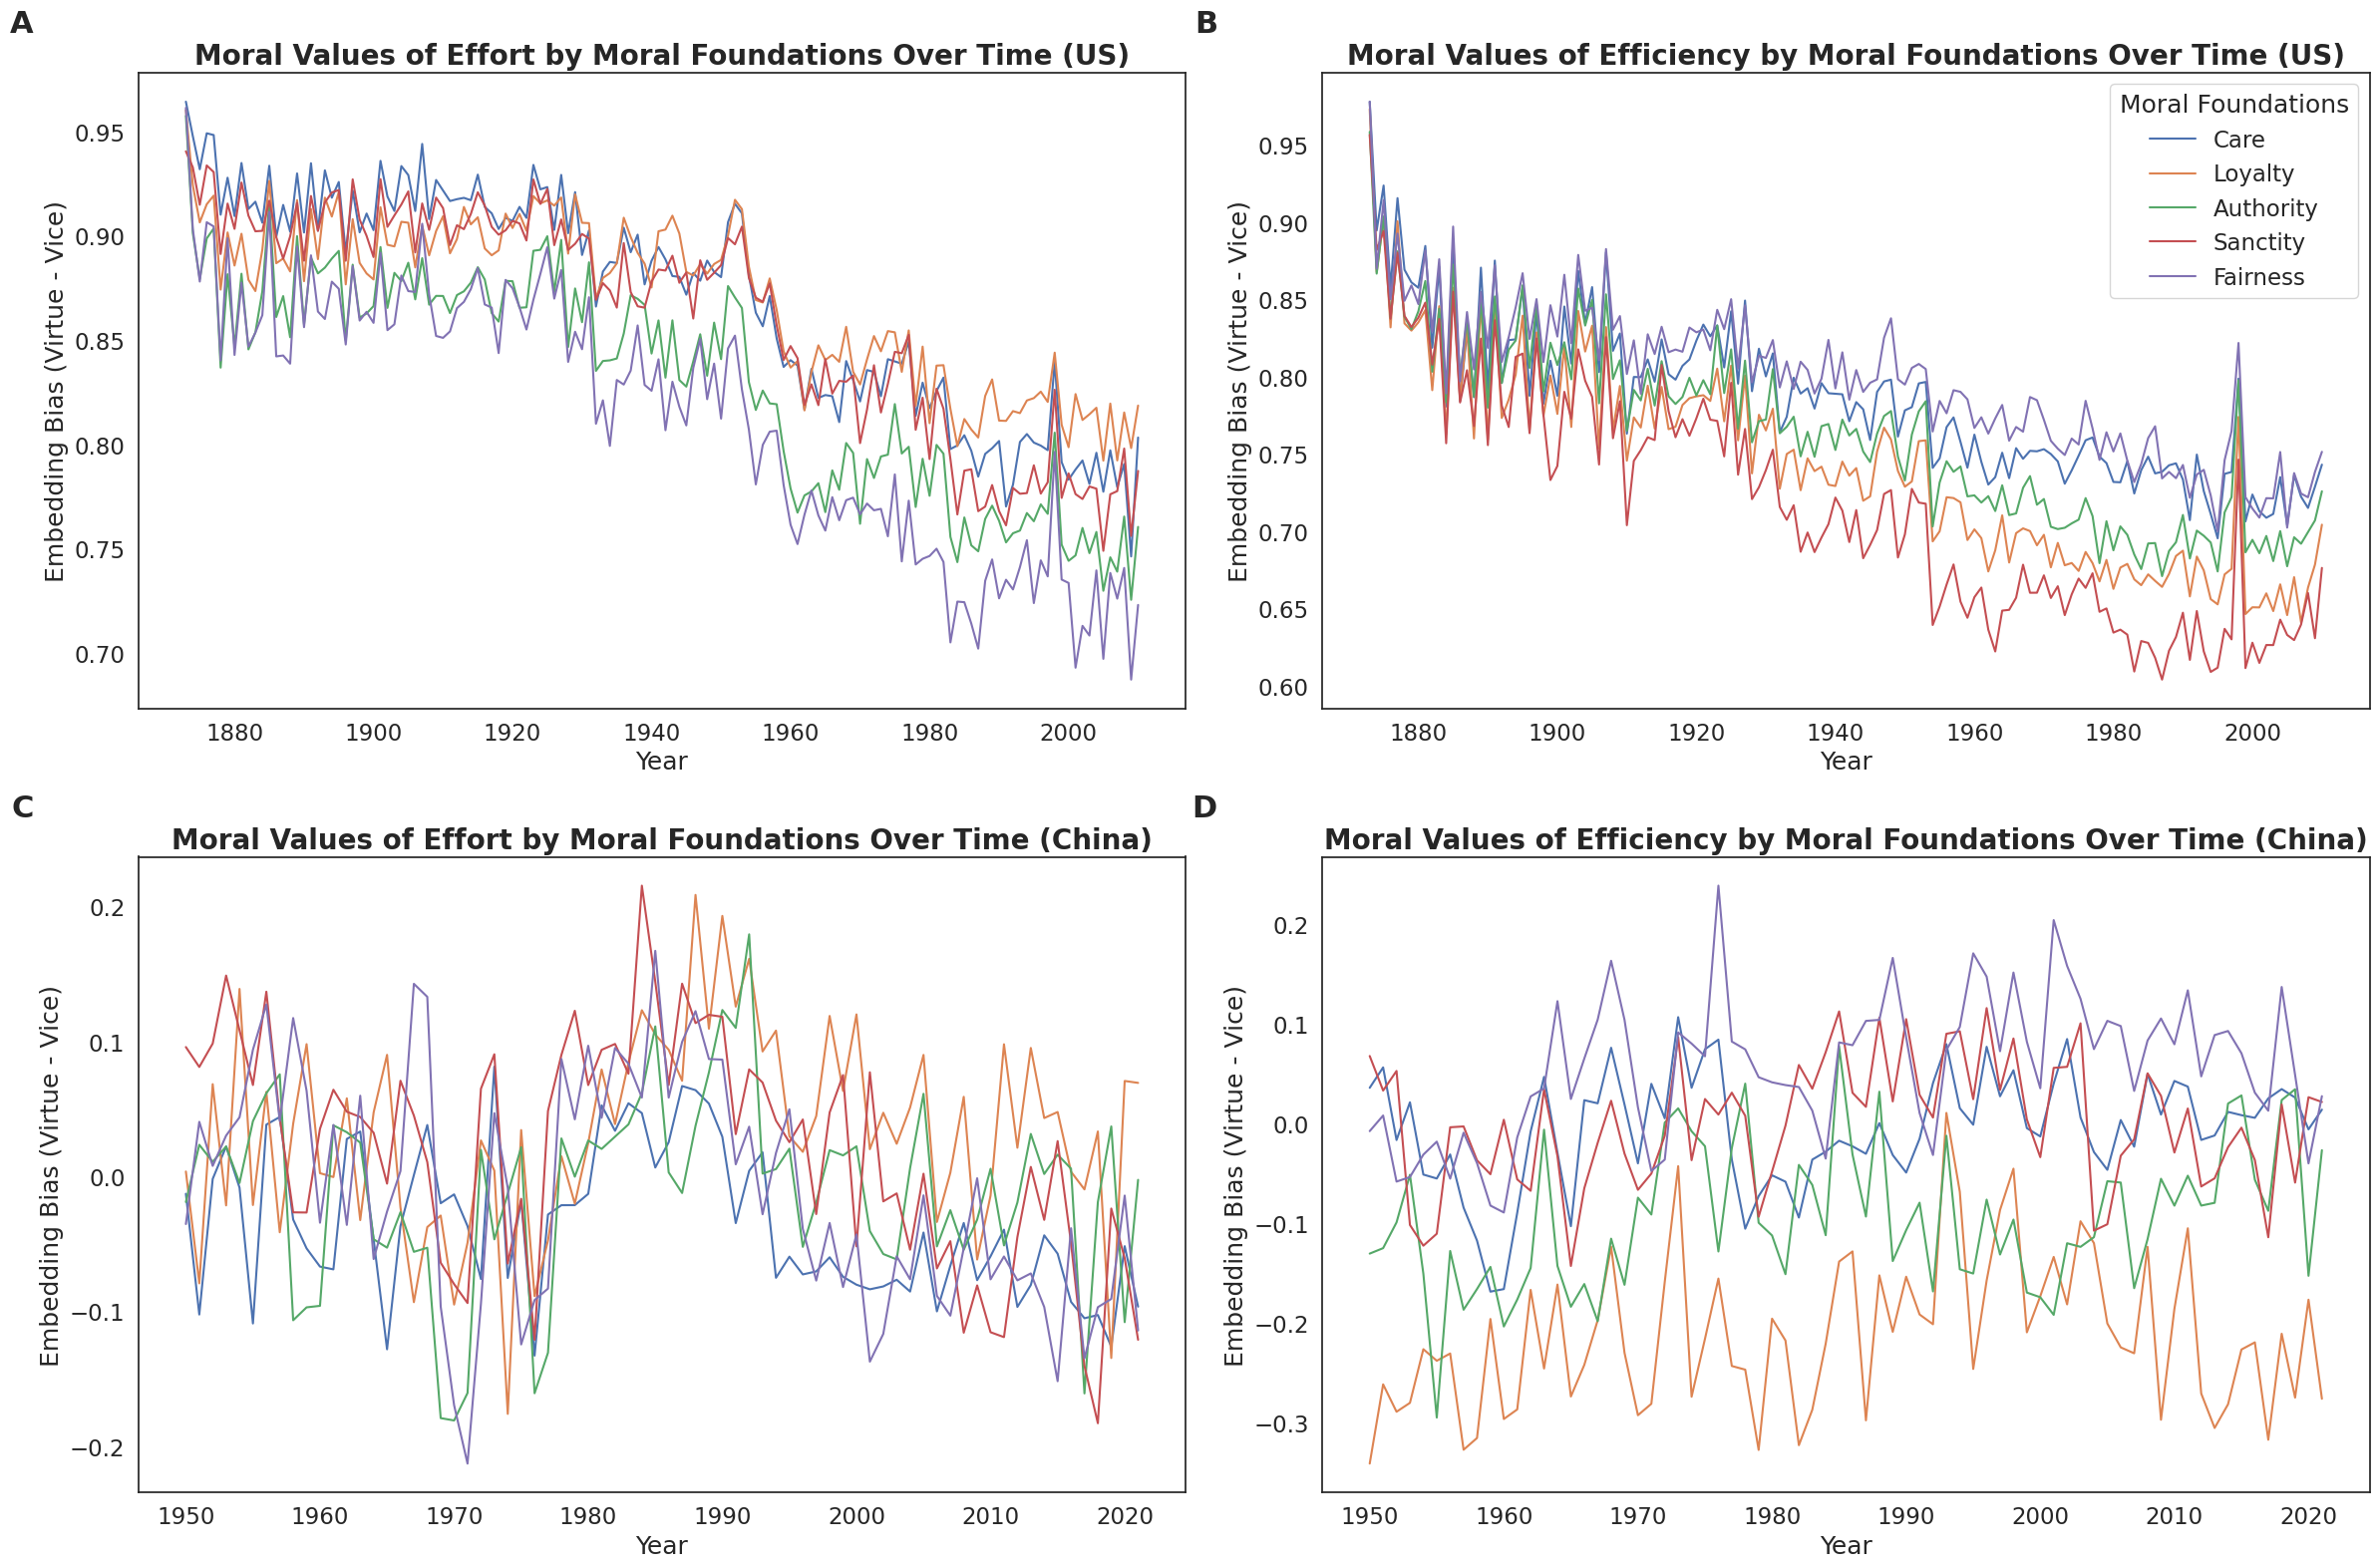

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is preloaded with the necessary data
sns.set(style="white", font_scale=1.5)  # Setting the font scale for larger fonts

foundations = ['care', 'loya', 'auth', 'sanc', 'fare']
foundation_full_names = ['Care', 'Loyalty', 'Authority', 'Sanctity', 'Fairness']

targets = ['effort', 'efficiency']
fig, axs = plt.subplots(2, 2, figsize=(24, 16))  # 2x2 subplot grid

for i, category in enumerate(targets):
    for j, data in enumerate([(df, 'US'), (dfchi, 'China')]):
        ax = axs[j, i]  # Navigate through subplots
        for foundation, name in zip(foundations, foundation_full_names):
            # Suppress legend for the second row by setting the label to "_nolegend_"
            ax.plot(data[0]['year'], data[0][f'{category}_{foundation}'], label=name if j == 0 else "_nolegend_")

        ax.set_xlabel('Year')
        ax.set_ylabel('Embedding Bias (Virtue - Vice)')
        ax.set_title(f'Moral Values of {category.capitalize()} by Moral Foundations Over Time ({data[1]})',fontweight='bold',fontsize=20)
        # Only add a legend to the first row's plots
        if j == 0 and i ==1:
            ax.legend(title='Moral Foundations')
        # add label A B C D to the subplots
        ax.text(-0.1, 1.1,  f'{chr(65 + i + 2*j)}', transform=ax.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

# Sentiments of effort and efficiency

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from tqdm import tqdm
import nltk
nltk.download('vader_lexicon')
# Initialize VADER
sia = SentimentIntensityAnalyzer()

def read_files_and_extract_sentences(start_year, end_year, keywords):
    path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed'  # Adjust to your files' path
    relevant_sentences = defaultdict(list)
    for year in tqdm(range(start_year, end_year + 1)):
        filename = os.path.join(path, f'cleaned_tokens_{year}.txt')
        try:
            with open(filename, 'r') as file:
                for line in file:
                    if any(word in line for word in keywords):
                        relevant_sentences[year].append(line.strip())
        except FileNotFoundError:
            print(f"File not found: {filename}")
    return relevant_sentences


def calculate_sentiments(sentences):
    sentiment_scores = {'pos': [], 'neg': [], 'neu': [], 'compound': []}
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_scores['pos'].append(scores['pos'])
        sentiment_scores['neg'].append(scores['neg'])
        sentiment_scores['neu'].append(scores['neu'])
        sentiment_scores['compound'].append(scores['compound'])
    return sentiment_scores


# Extract sentences
sentences_effort = read_files_and_extract_sentences(1873, 2011, targets['effort'])
sentences_efficiency = read_files_and_extract_sentences(1873, 2011, targets['efficiency'])

# Calculate sentiments with tqdm
sentiments_effort = {year: calculate_sentiments(sentences) for year, sentences in tqdm(sentences_effort.items())}
sentiments_efficiency = {year: calculate_sentiments(sentences) for year, sentences in tqdm(sentences_efficiency.items())}

# save to pipeline folder
df_effort = pd.DataFrame(sentiments_effort)
df_efficiency = pd.DataFrame(sentiments_efficiency)
df_effort.to_csv(os.path.join(pipeline_folder_path, 'sentiments_effort.csv'))
df_efficiency.to_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency.csv'))


[nltk_data] Downloading package vader_lexicon to /home/local/PSYCH-
[nltk_data]     ADS/xuqian_chen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TypeError: list indices must be integers or slices, not str

In [ ]:
import numpy as np
import pandas as pd
# load data
df_effort = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_effort_raw.csv'))
df_efficiency = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency_raw.csv'))
# transpose
mean_compounds = []
years = df_effort.columns[1:]  # Assuming the first column is 'Unnamed: 0' and should be skipped

# Iterate over each year column to calculate the mean compound score
for year in years:
    # Convert the compound score strings to lists (if necessary), then to numpy arrays for mean calculation
    compounds = np.array([float(comp) for comp in df_effort.loc[df_effort['Unnamed: 0'] == 'compound', year].values[0][1:-1].split(', ')])
    mean_compound = np.mean(compounds)
    mean_compounds.append(mean_compound)

# Create a new DataFrame with years and their corresponding mean compound scores
df_effort_us = pd.DataFrame({
    'Year': years,
    'MeanCompound': mean_compounds
})

# Optionally, convert 'Year' to numeric if it's stored as strings
df_effort_us['Year'] = pd.to_numeric(df_effort_us['Year'])

# transpose efficiency
mean_compounds = []
years = df_efficiency.columns[1:]  # Assuming the first column is 'Unnamed: 0' and should be skipped

# Iterate over each year column to calculate the mean compound score
for year in years:
    # Convert the compound score strings to lists (if necessary), then to numpy arrays for mean calculation
    compounds = np.array([float(comp) for comp in df_efficiency.loc[df_efficiency['Unnamed: 0'] == 'compound', year].values[0][1:-1].split(', ')])
    mean_compound = np.mean(compounds)
    mean_compounds.append(mean_compound)

# Create a new DataFrame with years and their corresponding mean compound scores
df_efficiency_us = pd.DataFrame({
    'Year': years,
    'MeanCompound': mean_compounds
})

# Optionally, convert 'Year' to numeric if it's stored as strings
df_efficiency_us['Year'] = pd.to_numeric(df_efficiency_us['Year'])

df_similarity = pd.read_csv(os.path.join(out_folder_path, 'merged_us.csv'))

# Merge data on 'Year'
df_efficiency_us = df_efficiency_us.merge(df_similarity[['year', 'efficiency_vir_vic_diff']], left_on='Year',right_on = 'year', how='inner')
df_effort_us = df_effort_us.merge(df_similarity[['year', 'effort_vir_vic_diff']], left_on='Year',right_on = 'year', how='inner')
# sort by year
df_efficiency_us = df_efficiency_us.sort_values(by='Year')
df_effort_us = df_effort_us.sort_values(by='Year')

# save
df_efficiency_us.to_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency.csv'))
df_effort_us.to_csv(os.path.join(pipeline_folder_path, 'sentiments_effort.csv'))

## load data

In [7]:
df_efficiency_us = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency.csv'))
df_effort_us = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_effort.csv'))
df_efficiency_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency_chi.csv'))
df_effort_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_effort_chi.csv'))

## plot

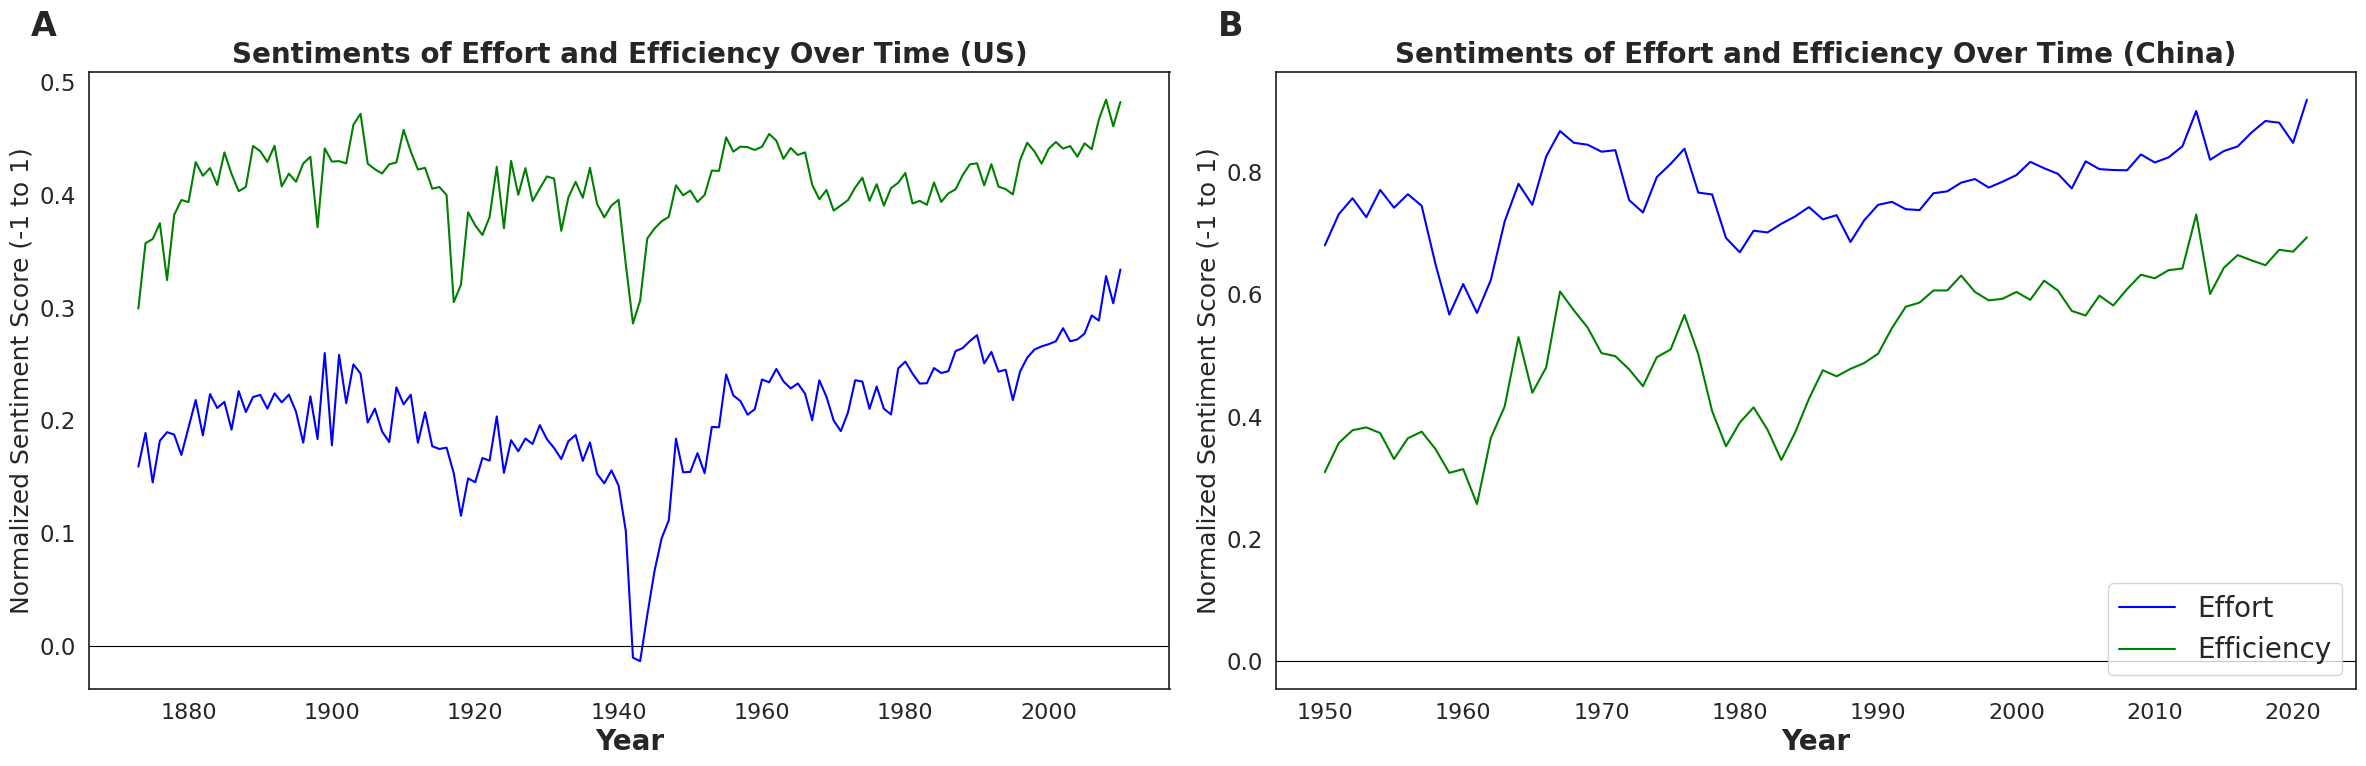

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(24, 8), facecolor='white')

# US Data Plot (VADER)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(df_effort_us['Year'], df_effort_us['MeanCompound'], label='Effort', color='blue')
ax1.plot(df_efficiency_us['Year'], df_efficiency_us['MeanCompound'], label='Efficiency', color='green')
ax1.axhline(0, color='black', linewidth=0.8)  # Neutral line at y = 0
ax1.set_title('Sentiments of Effort and Efficiency Over Time (US)',fontweight='bold',fontsize=20)
ax1.set_xlabel('Year',fontweight='bold',fontsize=20)
ax1.set_ylabel('Normalized Sentiment Score (-1 to 1)',fontsize = 18)
# ax1.legend(fontsize=20)
# increase x-tick font size
ax1.tick_params(axis='x', labelsize=16)
ax1.text(-0.03, 1.1, 'A', transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')



# China Data Plot (SnowNLP, adjusted to -1 to 1 range)
ax2 = plt.subplot(1, 2, 2)
ax2.plot(df_effort_chi['Year'], 2 * df_effort_chi['AverageSentiment'] - 1, label='Effort', color='blue')
ax2.plot(df_efficiency_chi['Year'], 2 * df_efficiency_chi['AverageSentiment'] - 1, label='Efficiency', color='green')
ax2.axhline(0, color='black', linewidth=0.8)  # Neutral line at y = 0
ax2.set_title('Sentiments of Effort and Efficiency Over Time (China)',fontweight='bold',fontsize=20)
ax2.set_xlabel('Year',fontweight='bold',fontsize=20)
ax2.set_ylabel('Normalized Sentiment Score (-1 to 1)',fontsize = 18)
# increase x-tick font size
ax2.tick_params(axis='x', labelsize=16)
ax2.text(-0.03, 1.1, 'B', transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')


# put legend at the bottom right
plt.legend(loc='lower right',fontsize=20)

plt.tight_layout()
plt.show()


## analysis

In [ ]:
# Assuming the 'compound' sentiment score is your IV and 'efficiency_vir_vic_diff' is your DV
y = df_efficiency_us['efficiency_vir_vic_diff']
X = df_efficiency_us[['MeanCompound']]  # Exogenous variable needs to be in DataFrame format

model = run_arimax(y, X)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-918.365, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-886.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-910.156, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-920.249, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-888.015, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-918.517, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-916.300, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-921.648, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-919.891, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-920.083, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-911.995, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-917.775, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.531 seconds
                               SARIMAX Results                                
Dep. Vari

In [ ]:
# effort
y = df_effort_us['effort_vir_vic_diff']
X = df_effort_us[['MeanCompound']]  # Exogenous variable needs to be in DataFrame format

model = run_arimax(y, X)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-849.869, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-825.459, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-847.456, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-875.618, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-827.066, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-860.434, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-862.539, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-871.799, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.353 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  138
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 440.809
Date:                Tue, 28 May 2024   AIC                           -875.618
Time:                        10:41:3

In [ ]:
# test correlation betweenbetween sentiment and bias
from scipy.stats import pearsonr
print(pearsonr(df_efficiency_us['MeanCompound'], df_efficiency_us['efficiency_vir_vic_diff']))
print(pearsonr(df_effort_us['MeanCompound'], df_effort_us['effort_vir_vic_diff']))


PearsonRResult(statistic=0.22422039664498933, pvalue=0.008198473312759877)
PearsonRResult(statistic=0.5725341673786439, pvalue=2.1899767135314445e-13)


## People's Daily

In [ ]:
import os
import matplotlib.pyplot as plt
from snownlp import SnowNLP
from collections import defaultdict
import pickle
from tqdm import tqdm
# Define function to read pickle files and extract sentences

def extract_sentences_from_pickle(data_folder, start_year, end_year, keywords):
    sentiments = defaultdict(list)
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(data_folder, f'cleaned_{year}.pkl')
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                for sentence_list in data:
                    # Convert list to string and check if it contains any keywords
                    sentence = ''.join(sentence_list)
                    if any(keyword in sentence for keyword in keywords):
                        s = SnowNLP(sentence)
                        sentiments[year].append(s.sentiments)  # Sentiments returns the probability of being positive
        except FileNotFoundError:
            print(f"No file found for the year {year}")
    return sentiments

# Define function to plot results
def plot_sentiments(sentiments, title):
    years = sorted(sentiments.keys())
    avg_sentiments = [sum(year_sentiments) / len(year_sentiments) if year_sentiments else 0 for year_sentiments in [sentiments[year] for year in years]]
    
    plt.figure(figsize=(10, 5))
    plt.plot(years, avg_sentiments, marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment Score (Positive Probability)')
    plt.grid(True)
    plt.show()

# Extract sentences and calculate sentiments
chitext_folder = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/PeopleDaily/cleaned_sentences'
effort_sentiments_chi = extract_sentences_from_pickle(chitext_folder, 1950, 2021, targets_chi['effort'])
efficiency_sentiments_chi = extract_sentences_from_pickle(chitext_folder, 1950, 2021, targets_chi['efficiency'])

# Plotting the results
# plot_sentiments(effort_sentiments_chi, 'Sentiment Analysis of Effort over Years')
# plot_sentiments(efficiency_sentiments_chi, 'Sentiment Analysis of Efficiency over Years')


def create_dataframe_from_sentiments(sentiment_dict):
    # Calculate the mean sentiment for each year and create a DataFrame
    data = {year: sum(sentiments) / len(sentiments) if sentiments else None
            for year, sentiments in sentiment_dict.items()}
    df = pd.DataFrame(list(data.items()), columns=['Year', 'AverageSentiment'])
    return df

# Use the function to create DataFrames
df_effort_chi = create_dataframe_from_sentiments(effort_sentiments_chi)
df_efficiency_chi = create_dataframe_from_sentiments(efficiency_sentiments_chi)

# Save to CSV
df_effort_chi.to_csv(os.path.join(pipeline_folder_path, 'sentiments_effort_chi.csv'), index=False)
df_efficiency_chi.to_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency_chi.csv'), index=False)



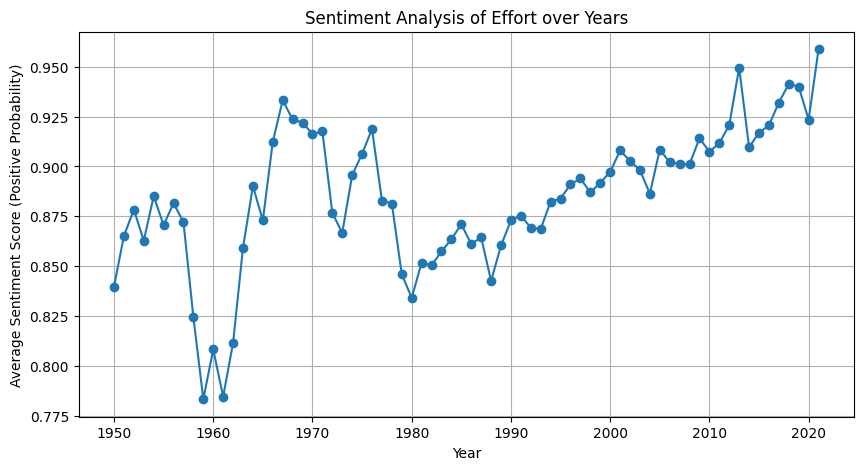

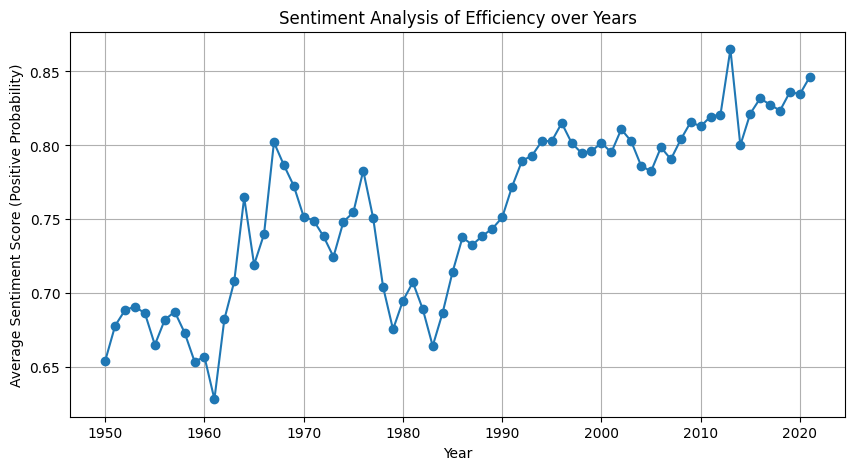

In [ ]:
# Plotting the results
plot_sentiments(effort_sentiments_chi, 'Sentiment Analysis of Effort over Years')
plot_sentiments(efficiency_sentiments_chi, 'Sentiment Analysis of Efficiency over Years')



In [ ]:
import pandas as pd
import os
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Assuming pipeline_folder_path and out_folder_path are defined
df_efficiency_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_efficiency_chi.csv'))
df_effort_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'sentiments_effort_chi.csv'))
df_similarity_chi = pd.read_csv(os.path.join(out_folder_path, 'merged_chi.csv'))

# Merge data on 'Year'
df_efficiency_chi = df_efficiency_chi.merge(df_similarity_chi[['year', 'efficiency_vir_vic_diff']], left_on='Year',right_on = 'year', how='inner')
df_effort_chi = df_effort_chi.merge(df_similarity_chi[['year', 'effort_vir_vic_diff']], left_on='Year',right_on = 'year', how='inner')
# sort by year
df_efficiency_chi = df_efficiency_chi.sort_values(by='Year')
df_effort_chi = df_effort_chi.sort_values(by='Year')


In [ ]:
from pmdarima.arima import AutoARIMA

def run_arimax(y, X):
    # Fit an ARIMAX model
    # y is the target series
    # X is the exogenous series, which must be a DataFrame
    model = AutoARIMA(start_p=1, start_q=1,
                      test='adf',          # use adf test to find optimal d
                      max_p=10, max_q=10,    # maximum p and q
                      m=1,                 # frequency of series
                      d=None,              # let model determine 'd'
                      seasonal=False,      # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      exogenous=X)
    model.fit(y)
    print(model.summary())
    return model

# Assuming the 'compound' sentiment score is your IV and 'efficiency_vir_vic_diff' is your DV
y = df_efficiency_chi['efficiency_vir_vic_diff']
X = df_efficiency_chi[['AverageSentiment']]  # Exogenous variable needs to be in DataFrame format

model = run_arimax(y, X)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-255.879, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-239.186, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-244.371, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-256.940, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-241.172, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-256.823, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-259.096, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-257.929, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-258.867, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-260.830, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-258.866, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-256.909, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-262.636, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-258.347, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [ ]:
# test effort
y = df_effort_chi['effort_vir_vic_diff']
X = df_effort_chi[['AverageSentiment']]  # Exogenous variable needs to be in DataFrame format

model = run_arimax(y, X)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-271.622, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-249.092, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-262.186, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-273.452, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-251.010, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-271.631, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-269.501, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-275.158, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-273.346, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-273.356, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-264.008, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-271.357, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.450 seconds
                               SARIMAX Results                                
Dep. Vari

In [ ]:
# test correlation
print(pearsonr(df_efficiency_chi['AverageSentiment'], df_efficiency_chi['efficiency_vir_vic_diff']))
print(pearsonr(df_effort_chi['AverageSentiment'], df_effort_chi['effort_vir_vic_diff']))

PearsonRResult(statistic=0.44913201036750594, pvalue=7.578888590876406e-05)
PearsonRResult(statistic=0.1774873233337605, pvalue=0.13581919857256097)


## load models

In [ ]:
# Models
# model_folder_path = os.path.join(data_folder_path, 'model')
model_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/model'
model_chi_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/Github/agebias-chi/0_data/model'

models = load_word2vec_models(model_folder_path)
models_chi = load_word2vec_models(model_chi_folder_path)

# Word Frequencies of Effort and Efficiency from Google N-gram

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import requests
import pandas as pd
import os
from extract_cosine_similarities import load_dict , load_word2vec_models, calculate_cosine_similarities

# # Get the current script directory and create paths to the data and output folders
# script_dir = os.path.dirname(os.path.abspath(__file__))
script_dir = os.path.dirname(os.path.abspath('__file__'))
data_folder_path = os.path.join(script_dir, '..', '0_data')
pipeline_folder_path = os.path.join(script_dir, '..', '2_pipeline/preprocessed')
tmp_folder_path = os.path.join(script_dir, '..', '2_pipeline/tmp')

# Targets (e.g., age groups)
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets.json')
targets_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_chi.json')

# Load the targets
targets = load_dict(targets_path)
targets_chi = load_dict(targets_chi_path)

def fetch_ngram_data(word, start_year=1800, end_year=2000, corpus='en-US-2019', smoothing=3):
    """
    Fetches Ngram data for a given word.
    
    :param word: Word to fetch Ngram data for.
    :param start_year: Start year for the Ngram data.
    :param end_year: End year for the Ngram data.
    :param corpus: Corpus ID for Google Ngram Viewer. 15 is for English.
    :param smoothing: Smoothing parameter for the Ngram data.
    :return: DataFrame with year and word frequency.
    """
    base_url = "https://books.google.com/ngrams/json"
    query_string = f"?content={word}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing={smoothing}"
    response = requests.get(base_url + query_string)
    if response.status_code == 200:
        content = response.json()
        if content:
            data = content[0]['timeseries']
            years = list(range(start_year, end_year + 1))
            # Ensure 'data' covers the entire range. If not, pad with None or an appropriate value.
            if len(data) != len(years):
                # Pad data to match the length of years
                data += [None] * (len(years) - len(data))
            return pd.DataFrame({'Year': years, 'Frequency': data})
    return pd.DataFrame()

def plot_word_trends(targets, start_year=1800, end_year=2000, corpus='en-US-2019'):
    """
    Plots word trends for words in the targets dictionary.

    :param targets: Dictionary of target words.
    :param start_year: Start year for the Ngram data.
    :param end_year: End year for the Ngram data.
    """
    if 'zh' in corpus:
        # Ensure matplotlib uses a font that supports Chinese characters
        # matplotlib.rcParams['font.family'] = 'SimHei'
        matplotlib.rcParams['font.family'] = 'Noto Sans CJK JP'
        matplotlib.rcParams['axes.unicode_minus'] = False  # This line is often necessary to display negative signs correctly

    plt.figure(figsize=(14, 6))
    dfall = pd.DataFrame()
    dfall['Year'] = range(start_year, end_year + 1)
    for category, words in targets.items():
        for word in words:
            df = fetch_ngram_data(word, start_year, end_year)
            if not df.empty:
                plt.plot(df['Year'], df['Frequency'], label=f"{word} ({category})")
                
            else:
                print(f"Failed to fetch data for '{word}'")
                df = pd.DataFrame({'Year': range(start_year, end_year + 1),'Frequency' : [None] * (end_year - start_year + 1)})
            dfall[f"{word} ({category})"] = df['Frequency']

    plt.xlabel('Year')
    plt.ylabel('Word Frequency')
    plt.title('Word Trends from Google Ngram Viewer')
    plt.legend()
    plt.show()
    return dfall


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


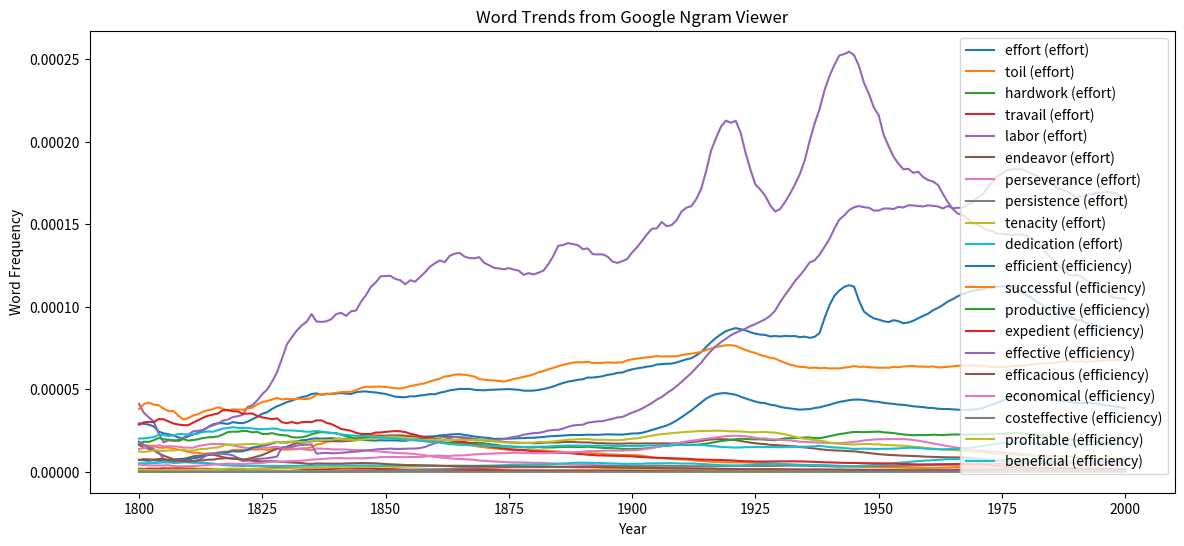

In [ ]:
plot_word_trends(targets)

Failed to fetch data for '力求'
Failed to fetch data for '殚思竭虑'
Failed to fetch data for '刻苦'
Failed to fetch data for '倾注全力'
Failed to fetch data for '力争'
Failed to fetch data for '始终不懈'
Failed to fetch data for '孜孜不息'
Failed to fetch data for '败而不馁'
Failed to fetch data for '坚守不渝'
Failed to fetch data for '躬行实践'
Failed to fetch data for '效益'
Failed to fetch data for '效率'
Failed to fetch data for '效用'
Failed to fetch data for '效能'
Failed to fetch data for '最优化'
Failed to fetch data for '产出率'
Failed to fetch data for '节本降耗'
Failed to fetch data for '利用率'
Failed to fetch data for '增值性'


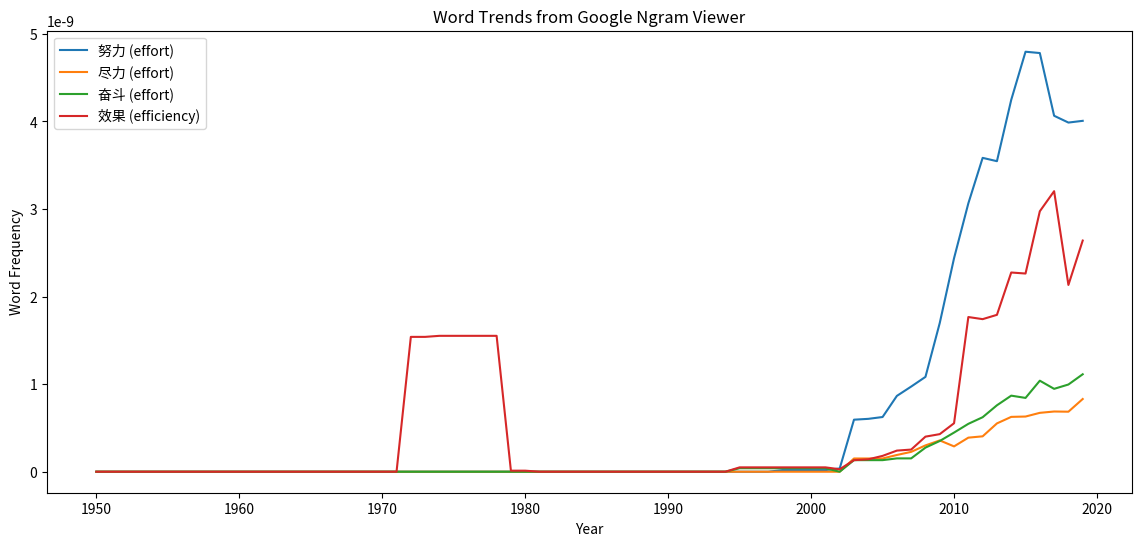

Year   努力 (effort) 力求 (effort)   尽力 (effort) 殚思竭虑 (effort) 刻苦 (effort)  \
0   1950  0.000000e+00        None  0.000000e+00          None        None   
1   1951  0.000000e+00        None  0.000000e+00          None        None   
2   1952  0.000000e+00        None  0.000000e+00          None        None   
3   1953  0.000000e+00        None  0.000000e+00          None        None   
4   1954  0.000000e+00        None  0.000000e+00          None        None   
..   ...           ...         ...           ...           ...         ...   
65  2015  4.795707e-09        None  6.300670e-10          None        None   
66  2016  4.780606e-09        None  6.723270e-10          None        None   
67  2017  4.064409e-09        None  6.875517e-10          None        None   
68  2018  3.986768e-09        None  6.853722e-10          None        None   
69  2019  4.006563e-09        None  8.303126e-10          None        None   

     奋斗 (effort) 倾注全力 (effort) 力争 (effort) 始终不懈 (effort)  ... 效益 (efficiency)  \
0   0.000000e+00          None        None          None  ...            None   
1   0.000000e+00          None        None          None  ...            None   
2   0.000000e+00          None        None          None  ...            None   
3   0.000000e+00          None        None          None  ...            None   
4   0.000000e+00          None        None          None  ...            None   
..           ...           ...         ...           ...  ...             ...   
65  8.427175e-10          None        None          None  ...            None   
66  1.039387e-09          None        None          None  ...            None   
67  9.463364e-10          None        None          None  ...            None   
68  9.959138e-10          None        None          None  ...            None   
69  1.112879e-09          None        None          None  ...            None   

   效率 (efficiency) 效用 (efficiency) 效能 (efficiency) 效果 (efficiency)  \
0             None            None            None    0.000000e+00   
1             None            None            None    0.000000e+00   
2             None            None            None    0.000000e+00   
3             None            None            None    0.000000e+00   
4             None            None            None    0.000000e+00   
..             ...             ...             ...             ...   
65            None            None            None    2.263005e-09   
66            None            None            None    2.973862e-09   
67            None            None            None    3.203224e-09   
68            None            None            None    2.132668e-09   
69            None            None            None    2.639433e-09   

   最优化 (efficiency) 产出率 (efficiency) 节本降耗 (efficiency)  利用率 (efficiency)  \
0              None             None              None              None   
1              None             None              None              None   
2              None             None              None              None   
3              None             None              None              None   
4              None             None              None              None   
..              ...              ...               ...               ...   
65             None             None              None              None   
66             None             None              None              None   
67             None             None              None              None   
68             None             None              None              None   
69             None             None              None              None   

   增值性 (efficiency)  
0              None  
1              None  
2              None  
3              None  
4              None  
..              ...  
65             None  
66             None  
67             None  
68             None  
69             None  

[70 rows x 24 columns]

In [ ]:
dfchi= plot_word_trends(targets_chi,start_year=1950, end_year=2019, corpus='zh-Hans-2019')
dfchi

In [ ]:
dfchi = fetch_ngram_data(targets_chi, start_year=1800, end_year=2000, corpus='zh-Hans-2019', smoothing=3)

In [ ]:
word = targets_chi['effort'][0]
start_year=1800
end_year=2000
corpus='zh-Hans-2019'
smoothing=3
base_url = "https://books.google.com/ngrams/json"
query_string = f"?content={word}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing={smoothing}"
response = requests.get(base_url + query_string)
if response.status_code == 200:
    content = response.json()
    if content:
        data = content[0]['timeseries']
        years = list(range(start_year, end_year + 1))
        dfchi = pd.DataFrame({'Year': years, 'Frequency': data})
dfchi

Year  Frequency
0    1800   0.000000
1    1801   0.000000
2    1802   0.000000
3    1803   0.000000
4    1804   0.000000
..    ...        ...
196  1996   0.000303
197  1997   0.000310
198  1998   0.000317
199  1999   0.000321
200  2000   0.000319

[201 rows x 2 columns]

In [ ]:
targets_chi['effort'][0]

'力求'

In [ ]:
targets_chi

{'effort': ['努力',
  '力求',
  '尽力',
  '殚思竭虑',
  '刻苦',
  '奋斗',
  '倾注全力',
  '力争',
  '始终不懈',
  '孜孜不息',
  '败而不馁',
  '坚守不渝',
  '躬行实践'],
 'efficiency': ['效益',
  '效率',
  '效用',
  '效能',
  '效果',
  '最优化',
  '产出率',
  '节本降耗',
  '利用率',
  '增值性']}

#  COHA: Word frequencies of cultural values

In [ ]:
# run correlation by Year for each word between dfngram and dfcoha
import scipy.stats as stats
from scipy.stats import pearsonr

import pandas as pd

dfngram = pd.read_csv('../0_data/external/culturalvalues_EngAme.csv')
dfcoha = pd.read_csv('../2_pipeline/preprocessed/COHA_list_frequencies_over_time.csv')
df_merged = pd.merge(dfngram, dfcoha, left_on='year',right_on='Year', how='left')
# drop na
df_merged = df_merged.dropna()
# List of cultural value words, assuming they are named the same in dfcoha or adapted accordingly
words = ['indi', 'coll', 'loose', 'tight']
# times 100 to get percentage of words columns
for word in words:
    df_merged[f'{word}_ngram'] = df_merged[f'{word}']*100000
    df_merged[f'{word}_coha'] = df_merged[f'{word}_%']*100
    # Create smoothed columns with a rolling window of 3
    df_merged[f'{word}_coha_smoothed'] = df_merged[f'{word}_coha'].rolling(window=3, center=True).mean()
results = []  # To store results

for word in words:

    # Perform correlation test
    stat, p = pearsonr(df_merged[f'{word}_ngram'], df_merged[f'{word}_coha'])
    results.append({
        'Word': word,
        'Stat': stat,
        'P-value': p
    })
    

# Convert results to a DataFrame for nicer formatting
results_df = pd.DataFrame(results)
print(results_df)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


    Word      Stat       P-value
0   indi  0.715872  4.007849e-23
1   coll  0.885787  1.619799e-47
2  loose  0.793895  2.144519e-31
3  tight  0.720015  1.718965e-23


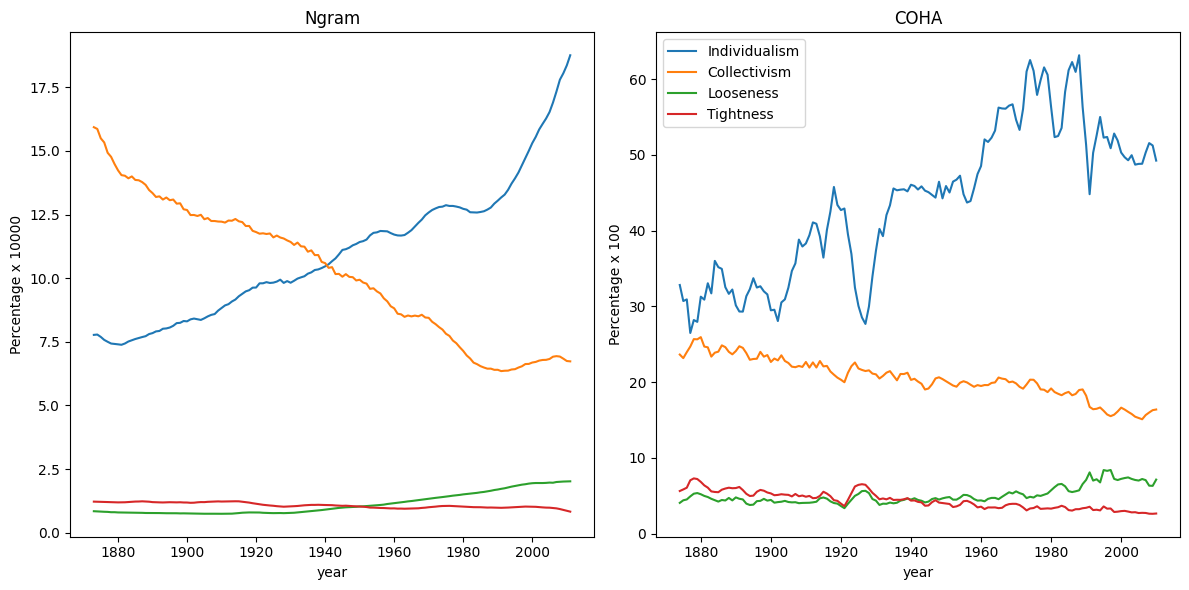

In [ ]:
# plot the four columns of words in two plots side by side
import matplotlib.pyplot as plt
import seaborn as sns
labels = ['Individualism', 'Collectivism', 'Looseness', 'Tightness']
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, word in enumerate(words):
    sns.lineplot(data=df_merged, x='year', y=f'{word}_ngram', ax=axs[0])
    sns.lineplot(data=df_merged, x='year', y=f'{word}_coha_smoothed', ax=axs[1], label=f'{labels[i]}')

axs[0].set_title('Ngram')
axs[1].set_title('COHA')
axs[0].set_ylabel('Percentage x 10000')
axs[1].set_ylabel('Percentage x 100')
plt.tight_layout()
plt.show()

In [ ]:
import os
save_path = '../2_pipeline/preprocessed/ngram_coha_comparison.csv'
df_merged.to_csv(save_path, index=False)

In [ ]:

# load data
df_ngram_coha = pd.read_csv('../2_pipeline/preprocessed/ngram_coha_comparison.csv')
# test ARIMA
from pmdarima import auto_arima
from scipy.stats import pearsonr

indi_coha = df_ngram_coha['indi_coha']
coll_coha = df_ngram_coha['coll_coha']
loose_coha = df_ngram_coha['loose_coha']
tight_coha = df_ngram_coha['tight_coha']

indi_ngram = df_ngram_coha['indi_ngram']
coll_ngram = df_ngram_coha['coll_ngram']
loose_ngram = df_ngram_coha['loose_ngram']
tight_ngram = df_ngram_coha['tight_ngram']

# test ARIMA
model_indi_coha = auto_arima(indi_coha, seasonal=False)
model_coll_coha = auto_arima(coll_coha, seasonal=False)
model_loose_coha = auto_arima(loose_coha, seasonal=False)
model_tight_coha = auto_arima(tight_coha, seasonal=False)

model_indi_ngram = auto_arima(indi_ngram, seasonal=False)
model_coll_ngram = auto_arima(coll_ngram, seasonal=False)
model_loose_ngram = auto_arima(loose_ngram, seasonal=False)
model_tight_ngram = auto_arima(tight_ngram, seasonal=False)

# fit the model
model_indi_coha.fit(indi_coha)
model_coll_coha.fit(coll_coha)
model_loose_coha.fit(loose_coha)
model_tight_coha.fit(tight_coha)

model_indi_ngram.fit(indi_ngram)
model_coll_ngram.fit(coll_ngram)
model_loose_ngram.fit(loose_ngram)
model_tight_ngram.fit(tight_ngram)

# residuals
resid_indi_coha = model_indi_coha.resid()
resid_coll_coha = model_coll_coha.resid()
resid_loose_coha = model_loose_coha.resid()
resid_tight_coha = model_tight_coha.resid()

resid_indi_ngram = model_indi_ngram.resid()
resid_coll_ngram = model_coll_ngram.resid()
resid_loose_ngram = model_loose_ngram.resid()
resid_tight_ngram = model_tight_ngram.resid()

# test correlation
indi_stat, indi_p = pearsonr(resid_indi_coha, resid_indi_ngram)
coll_stat, coll_p = pearsonr(resid_coll_coha, resid_coll_ngram)
loose_stat, loose_p = pearsonr(resid_loose_coha, resid_loose_ngram)
tight_stat, tight_p = pearsonr(resid_tight_coha, resid_tight_ngram)

# print
print(f'Individualism: stat={indi_stat}, p={indi_p}')
print(f'Collectivism: stat={coll_stat}, p={coll_p}')
print(f'Looseness: stat={loose_stat}, p={loose_p}')
print(f'Tightness: stat={tight_stat}, p={tight_p}')

Individualism: stat=0.43442178872387577, p=9.129634545807045e-08
Collectivism: stat=0.8511599734885431, p=3.5711531320092575e-40
Looseness: stat=0.3099061520058474, p=0.0002051604500360211
Tightness: stat=0.6189874643660168, p=4.610302525652944e-16


# replicate without missing words from embeddings

In [ ]:
import os
import pandas as pd
from extract_cosine_similarities import load_dict , load_word2vec_models, calculate_cosine_similarities,create_bias_dataframe

def calculate_cosine_similarities_w_missingwords(models, targets, foundations):
    similarities = {}
    missing_words = {}  # Dictionary to track missing words
    
    for year, model in models.items():
        similarities[year] = {}
        missing_words[year] = {}  # Initialize missing words dictionary for the year
        
        for target_name, target_words in targets.items():
            similarities[year][target_name] = {}
            missing_words[year][target_name] = {}  # Initialize missing words dictionary for the target
            # flatten target words
            target_words = [word for sublist in target_words for word in sublist]
            for foundation_name, foundation_words in foundations.items():
                filtered_target_words = [word for word in target_words if word in model.wv.key_to_index]
                filtered_foundation_words = [word for word in foundation_words if word in model.wv.key_to_index]
                
                # Track missing words
                missing_target_words = set(target_words) - set(filtered_target_words)
                missing_foundation_words = set(foundation_words) - set(filtered_foundation_words)
                missing_words[year][target_name][foundation_name] = {
                    'target_missing': list(missing_target_words),
                    'foundation_missing': list(missing_foundation_words)
                }
                
                # Calculate similarity
                try:
                    similarity = model.wv.n_similarity(filtered_target_words, filtered_foundation_words)
                except:
                    similarity = np.nan
                    print('Not found')

                similarities[year][target_name][foundation_name] = similarity
    
    return similarities, missing_words
def create_missing_words_df(missing_words, targets, foundations):
    rows = []
    for year, yearly_data in missing_words.items():
        for target_name, target_data in yearly_data.items():
            for foundation_name, foundation_info in target_data.items():
                row = {
                    'year': year,
                    'target': target_name,
                    'foundation': foundation_name,
                    'target_missing_count': len(foundation_info['target_missing']),
                    'foundation_missing_count': len(foundation_info['foundation_missing']),
                    'target_missing_words': foundation_info['target_missing'],
                    'foundation_missing_words': foundation_info['foundation_missing']
                }
                rows.append(row)
    
    df_missing = pd.DataFrame(rows)
    return df_missing

# Calculate cosine similarities and missing words
similarities, missing_words = calculate_cosine_similarities_w_missingwords(models, targets, foundations)

# Create DataFrame of missing words
df_missing = create_missing_words_df(missing_words, targets, foundations)

# Save or print the DataFrame
print(df_missing.head())
# Optionally, save to CSV
# df_missing.to_csv(os.path.join(pipeline_folder_path, 'missing_words_summary.csv'), index=False)


   year  target foundation  target_missing_count  foundation_missing_count  \
0  1873  effort   care_vic                     4                       180   
1  1873  effort   care_vir                     4                       111   
2  1873  effort   loya_vic                     4                        33   
3  1873  effort   loya_vir                     4                        73   
4  1873  effort   auth_vic                     4                        89   

                             target_missing_words  \
0  [hardwork, travail, persistence, perseverance]   
1  [hardwork, travail, persistence, perseverance]   
2  [hardwork, travail, persistence, perseverance]   
3  [hardwork, travail, persistence, perseverance]   
4  [hardwork, travail, persistence, perseverance]   

                            foundation_missing_words  
0  [destroyers, stabber, mistreated, ache, assass...  
1  [nurturer, hospitalise, unharmful, rescued, sa...  
2  [heresy, backstabber, deserter, treacherous,

In [ ]:
# get chinese missing words
similarities_chi, missing_words_chi = calculate_cosine_similarities_w_missingwords(models_chi, targets_chi, foundations_chi)
df_missing_chi = create_missing_words_df(missing_words_chi, targets_chi, foundations_chi)
print(df_missing_chi.head())
# df_missing_chi.to_csv(os.path.join(pipeline_folder_path, 'missing_words_summary_chi.csv'), index=False)

   year  target foundation  target_missing_count  foundation_missing_count  \
0  1950  effort   care_vir                    10                         0   
1  1950  effort   care_vic                    10                         0   
2  1950  effort   fare_vir                    10                         0   
3  1950  effort   fare_vic                    10                         1   
4  1950  effort   loya_vir                    10                         0   

                                target_missing_words foundation_missing_words  
0  [倾注全力, 亲身实践, 殚思竭虑, 殚精竭虑, 持之以恒, 孜孜不息, 倾尽全力, 败而不...                       []  
1  [倾注全力, 亲身实践, 殚思竭虑, 殚精竭虑, 持之以恒, 孜孜不息, 倾尽全力, 败而不...                       []  
2  [倾注全力, 亲身实践, 殚思竭虑, 殚精竭虑, 持之以恒, 孜孜不息, 倾尽全力, 败而不...                       []  
3  [倾注全力, 亲身实践, 殚思竭虑, 殚精竭虑, 持之以恒, 孜孜不息, 倾尽全力, 败而不...                     [排外]  
4  [倾注全力, 亲身实践, 殚思竭虑, 殚精竭虑, 持之以恒, 孜孜不息, 倾尽全力, 败而不...                       []  


### display counts of missing words 

In [ ]:
from ast import literal_eval

def safe_literal_eval(s):
    try:
        return literal_eval(s)
    except ValueError:
        # Handle the error or return the input as-is if it's already the correct format
        return s
def count_missing_words(dfmissing):
    df = pd.DataFrame(dfmissing)

    # Evaluate the string representation of lists in the DataFrame
    df['target_missing_words'] = df['target_missing_words'].apply(safe_literal_eval)

    # Flatten the list of missing words and count occurrences across years
    word_counts = df.explode('target_missing_words').groupby('target_missing_words')['year'].nunique()

    # Convert to DataFrame for better readability
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Missing Word', 'Number of Years Missed']


    return word_counts_df


# df_missing = pd.read_csv('../2_pipeline/preprocessed/missing_words_summary.csv')
# df_missing_chi = pd.read_csv('../2_pipeline/preprocessed/missing_words_summary_chi.csv')
df_missing_count  = count_missing_words(df_missing)
df_missing_count_chi  = count_missing_words(df_missing_chi)
# save to csv
df_missing_count.to_csv(os.path.join(pipeline_folder_path, 'missing_words_count.csv'), index=False)
df_missing_count_chi.to_csv(os.path.join(pipeline_folder_path, 'missing_words_count_chi.csv'), index=False)

In [ ]:
df_missing_count = pd.read_csv(os.path.join(pipeline_folder_path, 'missing_words_count.csv'))
df_missing_count_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'missing_words_count_chi.csv'))
df_missing_count_chi['Percentage'] = df_missing_count_chi['Number of Years Missed'] / (2021 - 1950 + 1) * 100
df_missing_count['Percentage'] = df_missing_count['Number of Years Missed'] / (2011 - 1873 + 1) * 100
# sort
df_missing_count = df_missing_count.sort_values('Number of Years Missed', ascending=False)
df_missing_count_chi = df_missing_count_chi.sort_values('Number of Years Missed', ascending=False)
# save to xlsx
df_missing_count.to_excel(os.path.join(pipeline_folder_path, 'missing_words_count.xlsx'), index=False)
df_missing_count_chi.to_excel(os.path.join(pipeline_folder_path, 'missing_words_count_chi.xlsx'), index=False)

In [ ]:
df_missing_count 

Missing Word  Number of Years Missed  Percentage
3       hardwork                      97   69.784173
0  costeffective                      93   66.906475
7        travail                      12    8.633094
1     dedication                       2    1.438849
4   perseverance                       2    1.438849
2    efficacious                       1    0.719424
5    persistence                       1    0.719424
6       tenacity                       1    0.719424

In [ ]:
df_missing_count_chi

Missing Word  Number of Years Missed  Percentage
10         孜孜不息                      72  100.000000
18         败而不馁                      72  100.000000
17         节本降耗                      72  100.000000
15         殚思竭虑                      72  100.000000
1          亲身实践                      72  100.000000
8           增值性                      72  100.000000
7          坚守不渝                      71   98.611111
20         躬行实践                      70   97.222222
4          倾注全力                      70   97.222222
9          始终不懈                      57   79.166667
3          倾尽全力                      53   73.611111
14          最优化                      41   56.944444
0           产出率                      37   51.388889
16         殚精竭虑                      34   47.222222
2            优化                      30   41.666667
11         持之以恒                      13   18.055556
19         身体力行                       7    9.722222
12           效用                       6    8.333333
6           利用率                       1    1.388889
5          全力以赴                       1    1.388889
13           效益                       1    1.388889

## udpate bias with no missing targets

In [ ]:
# Targets (e.g., age groups)
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_deletemissing.json')
targets_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_chi_deletemissing.json')

targets = load_dict(targets_path)
targets_chi = load_dict(targets_chi_path)

similarities = calculate_cosine_similarities(models, targets, foundations)
dfus = create_bias_dataframe(similarities, targets, foundations)
similarities_chi = calculate_cosine_similarities(models_chi, targets_chi, foundations_chi)
dfchi = create_bias_dataframe(similarities_chi, targets_chi, foundations_chi)

# save to preprocessed folder
dfus.to_csv(os.path.join(pipeline_folder_path, 'foundations_deletemissing.csv'), index=False)
dfchi.to_csv(os.path.join(pipeline_folder_path, 'foundations_chi_deletemissing.csv'), index=False)

## update bias with synonyms

In [ ]:
# from extract_cosine_similarities import calculate_cosine_similarities_synonyms
import numpy as np
def calculate_cosine_similarities_synonyms((models: Dict[int, KeyedVectors],
                                  targets: Dict[str, List[List[str]]],
                                  foundations: Dict[str, List[str]]) -> Dict[int, Dict[str, Dict[str, float]]]:
    """
    Calculates the average cosine similarities between groups of target words (including synonyms) and foundation words 
    for each given year using pre-trained word embedding models.

    Parameters:
    - models (Dict[int, KeyedVectors]): A dictionary where keys are years and values are gensim KeyedVectors models.
    - targets (Dict[str, List[List[str]]]): A dictionary where keys are target names and values are lists of lists,
      each containing words and their synonyms.
    - foundations (Dict[str, List[str]]): A dictionary where keys are foundation names and values are lists of words.

    Returns:
    - Dict[int, Dict[str, Dict[str, float]]]: A dictionary with the structure:
      {year: {target_name: {foundation_name: average_similarity}}}
      where average_similarity is the computed average cosine similarity between the target words and foundation words.

    The function processes each year's model, computing similarities between target groups and foundation groups,
    handling cases where words are not found in the model's vocabulary by skipping those calculations.
    In cases where similarities can be calculated, it averages them; if no similarities are computed due to vocabulary issues,
    it assigns NaN.
    """

    similarities = {}
    for year, model in models.items():
        similarities[year] = {}
        for target_name, target_groups in targets.items():
            similarities[year][target_name] = {}
            for foundation_name, foundation_words in foundations.items():
                foundation_vecs = [word for word in foundation_words if word in model.wv.key_to_index]
                
                # Initialize list to store individual synonym group similarities
                group_similarities = []
                
                for target_group in target_groups:
                    # Filter target words to ensure they are in the model's vocabulary
                    target_vecs = [word for word in target_group if word in model.wv.key_to_index]
                    
                    # Calculate similarity for each synonym group
                    if target_vecs and foundation_vecs:  # Ensure both lists are not empty
                        try:
                            similarity = model.wv.n_similarity(target_vecs, foundation_vecs)
                            group_similarities.append(similarity)
                        except:
                            print(f'{year} {target_name} {foundation_name} Not found')
                    
                # Compute the average similarity for the target group if any similarities were calculated
                if group_similarities:
                    average_similarity = np.nanmean(group_similarities)
                else:
                    average_similarity = np.nan
                
                similarities[year][target_name][foundation_name] = average_similarity

    return similarities

# Targets
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_replace_synonyms.json')
targets_chi_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets_chi_replace_synonyms.json')

# Load the targets
targets = load_dict(targets_path)
targets_chi = load_dict(targets_chi_path)

# Calculate cosine similarities
similarities = calculate_cosine_similarities_synonyms(models, targets, foundations)
dfus_syn = create_bias_dataframe(similarities, targets, foundations)
similarities_chi = calculate_cosine_similarities_synonyms(models_chi, targets_chi, foundations_chi)
dfchi_syn = create_bias_dataframe(similarities_chi, targets_chi, foundations_chi)
dfus_syn['inefficient_effort'] = dfus_syn['effort_virtue'] - dfus_syn['efficiency_virtue']
dfchi_syn['inefficient_effort'] = dfchi_syn['effort_virtue'] - dfchi_syn['efficiency_virtue']

# save to preprocessed folder
dfus_syn.to_csv(os.path.join(pipeline_folder_path, 'foundations_replace_synonyms.csv'), index=False)
dfchi_syn.to_csv(os.path.join(pipeline_folder_path, 'foundations_chi_replace_synonyms.csv'), index=False)


### compare with original data

In [ ]:

# test correlation between dfchi and dfchi_ori
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# load data
dfus = pd.read_csv('../2_pipeline/preprocessed/foundations_deletemissing.csv')
dfchi = pd.read_csv('../2_pipeline/preprocessed/foundations_chi_deletemissing.csv')
dfus['inefficient_effort'] = dfus['effort_virtue'] - dfus['efficiency_virtue']
dfchi['inefficient_effort'] = dfchi['effort_virtue'] - dfchi['efficiency_virtue']

dfus_ori = pd.read_csv('../2_pipeline/out/merged_us.csv')
dfchi_ori = pd.read_csv('../2_pipeline/out/merged_chi.csv')
dfus_ori['inefficient_effort'] = dfus_ori['effort_virtue'] - dfus_ori['efficiency_virtue']
dfchi_ori['inefficient_effort'] = dfchi_ori['effort_virtue'] - dfchi_ori['efficiency_virtue']
  
def compare_before_after(dfbefore, dfafter, var,varname, ylabel = "Embedding Bias (Virtue - Vice)"):
    # Merge the two DataFrames
    df_merge = pd.merge(dfbefore, dfafter, on='year', how='inner')
    
    # Perform the correlation test
    stat, p = pearsonr(df_merge[f'{var}_x'], df_merge[f'{var}_y'])
    
    print(f"Correlation of {var} between original and after-revised: stat={stat}, p={p}")
    #  Plot the two variables
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_merge, x='year', y=f'{var}_x', label='Full Dictionary')
    sns.lineplot(data=df_merge, x='year', y=f'{var}_y', label='Pruned Dictionary')
    plt.title(f'Moral Values of {varname} Using Full vs. Pruned Dictionaries')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.show()
    return stat, p
 

US data without missing words
Correlation of effort_vir_vic_diff between original and after-revised: stat=0.999541743755217, p=1.7914777549618985e-208


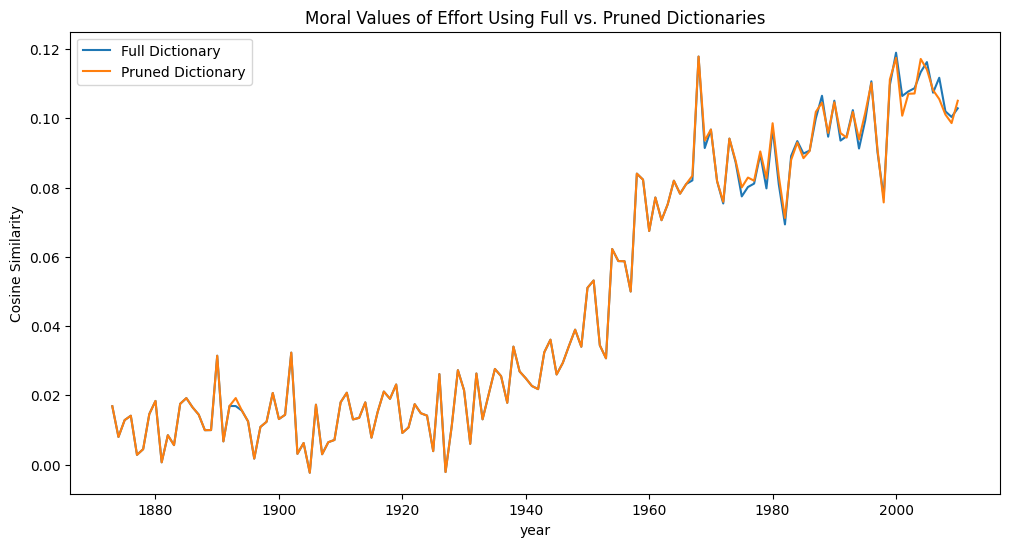

Correlation of efficiency_vir_vic_diff between original and after-revised: stat=0.99454755585895, p=2.0622168681331678e-135


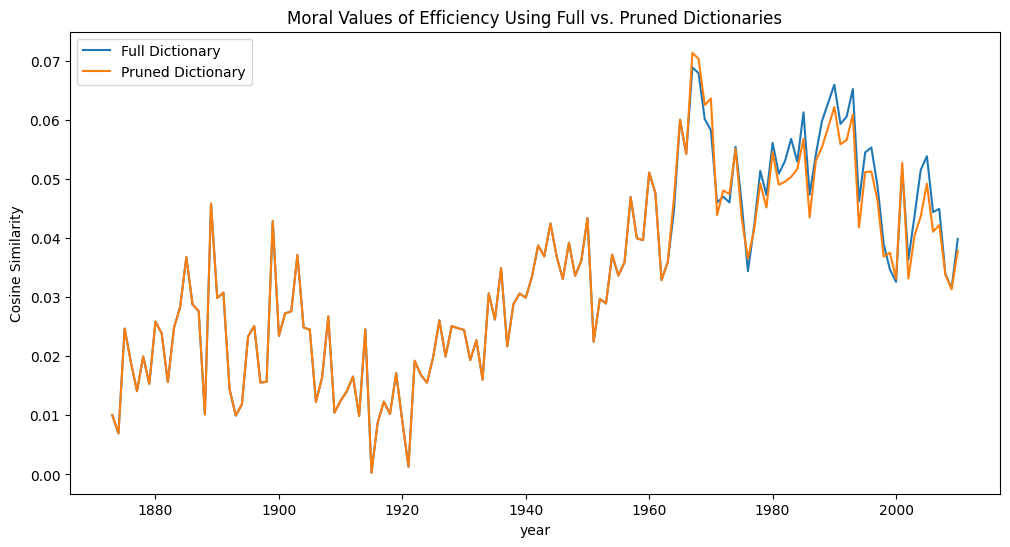

Correlation of inefficient_effort between original and after-revised: stat=0.9295905369765777, p=8.24381594066889e-61


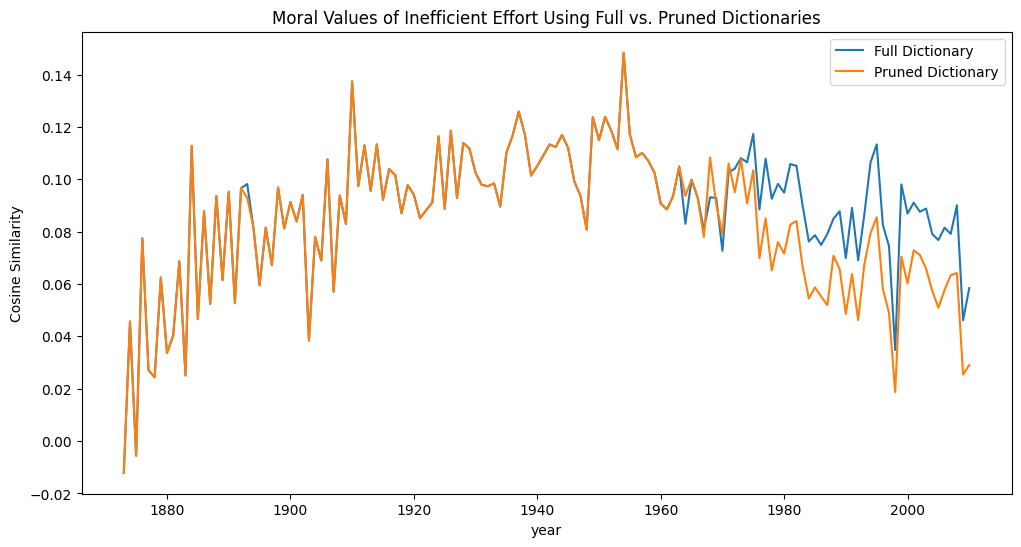

Chinese data without missing words
Correlation of effort_vir_vic_diff between original and after-revised: stat=0.9991359014276401, p=1.9382118944275715e-98


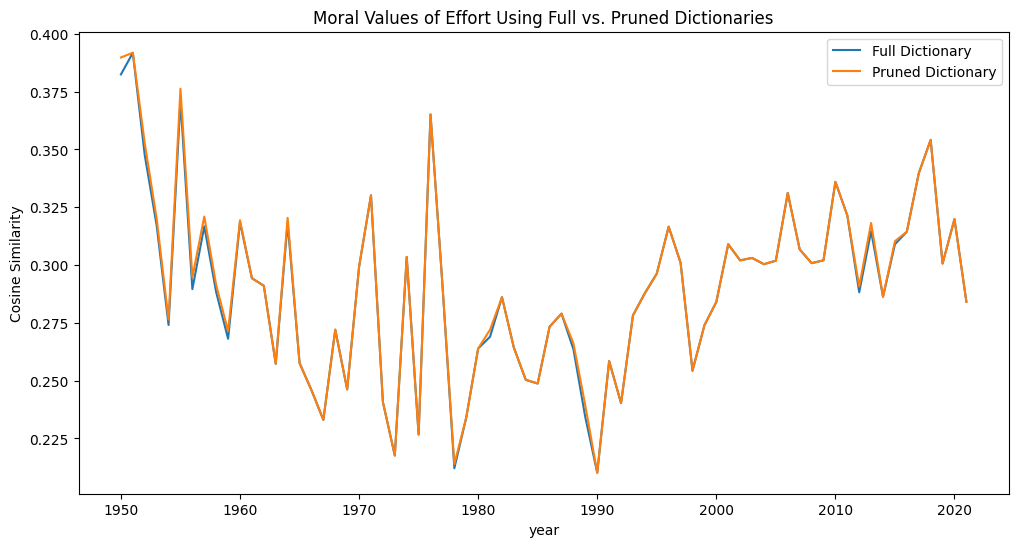

Correlation of efficiency_vir_vic_diff between original and after-revised: stat=0.9982736430168555, p=6.325055911787617e-88


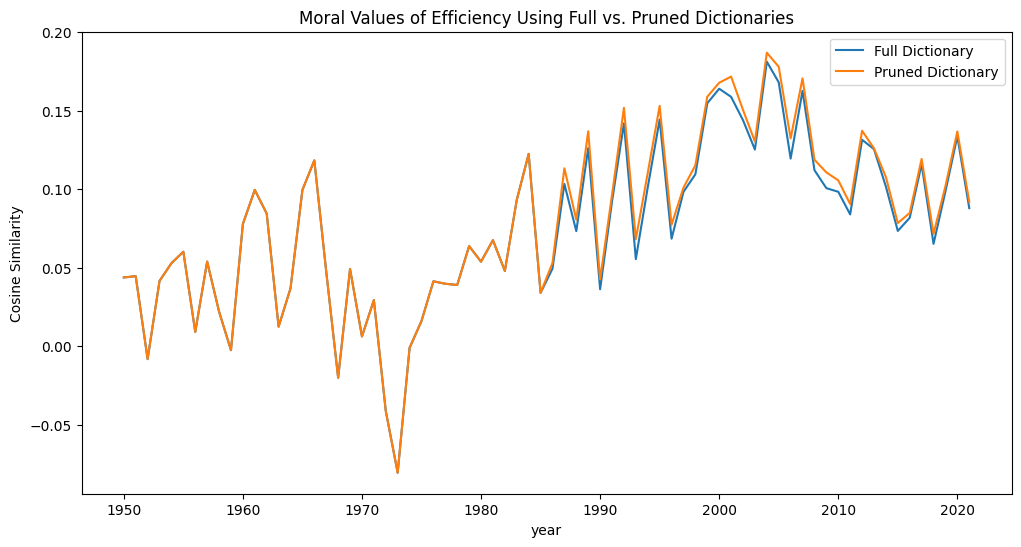

Correlation of inefficient_effort between original and after-revised: stat=0.999765972435073, p=2.7324702873188436e-118


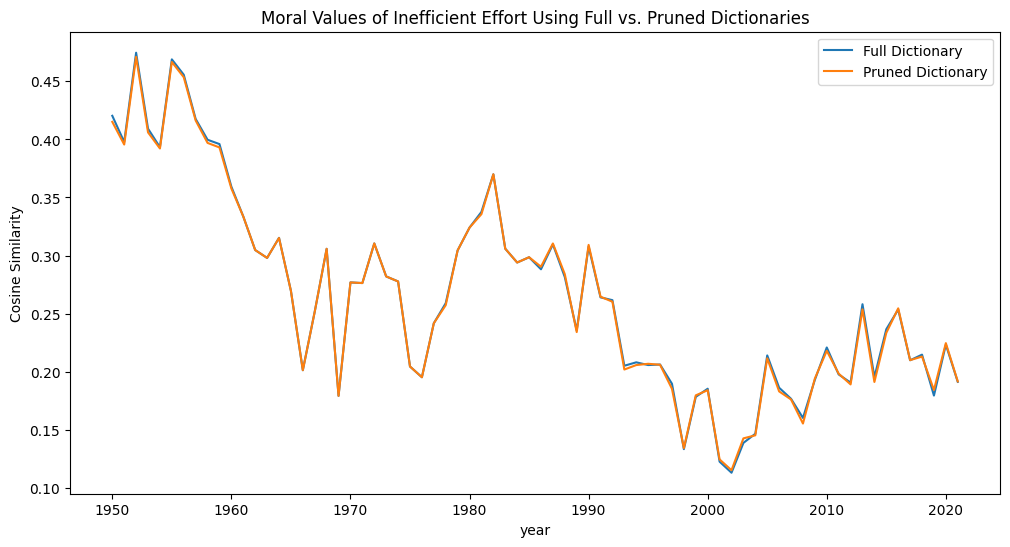

(0.999765972435073, 2.7324702873188436e-118)

In [ ]:

print("US data without missing words")
compare_before_after(dfus_ori, dfus, 'effort_vir_vic_diff','Effort')
compare_before_after(dfus_ori, dfus, 'efficiency_vir_vic_diff','Efficiency')
compare_before_after(dfus_ori, dfus, 'inefficient_effort','Inefficient Effort')

print("Chinese data without missing words")
compare_before_after(dfchi_ori, dfchi, 'effort_vir_vic_diff','Effort')
compare_before_after(dfchi_ori, dfchi, 'efficiency_vir_vic_diff','Efficiency')
compare_before_after(dfchi_ori, dfchi, 'inefficient_effort','Inefficient Effort')

US data with synonyms
Correlation of effort_vir_vic_diff between original and after-revised: stat=0.9882796453454428, p=6.665862262500638e-113


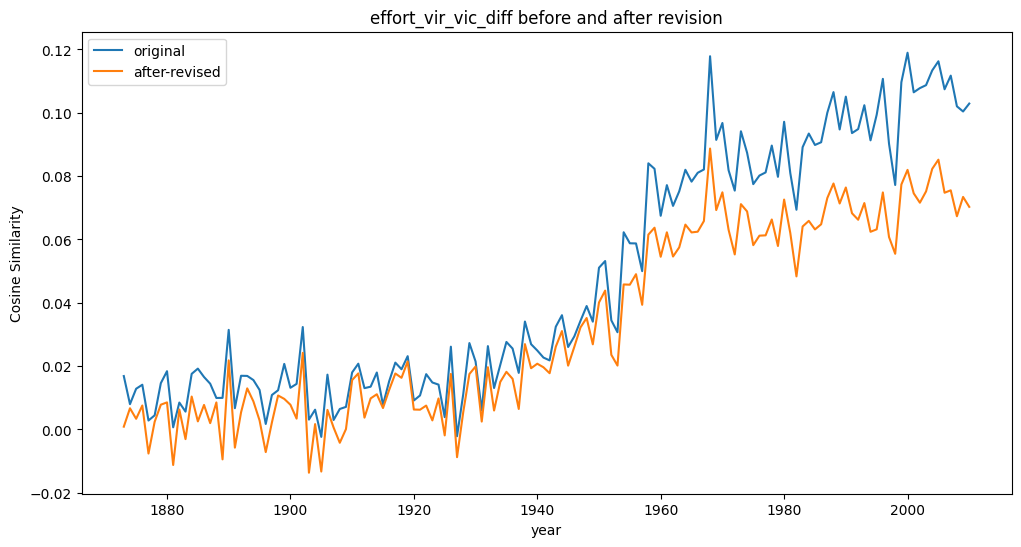

Correlation of efficiency_vir_vic_diff between original and after-revised: stat=0.9915897384141225, p=1.1765889468751007e-122


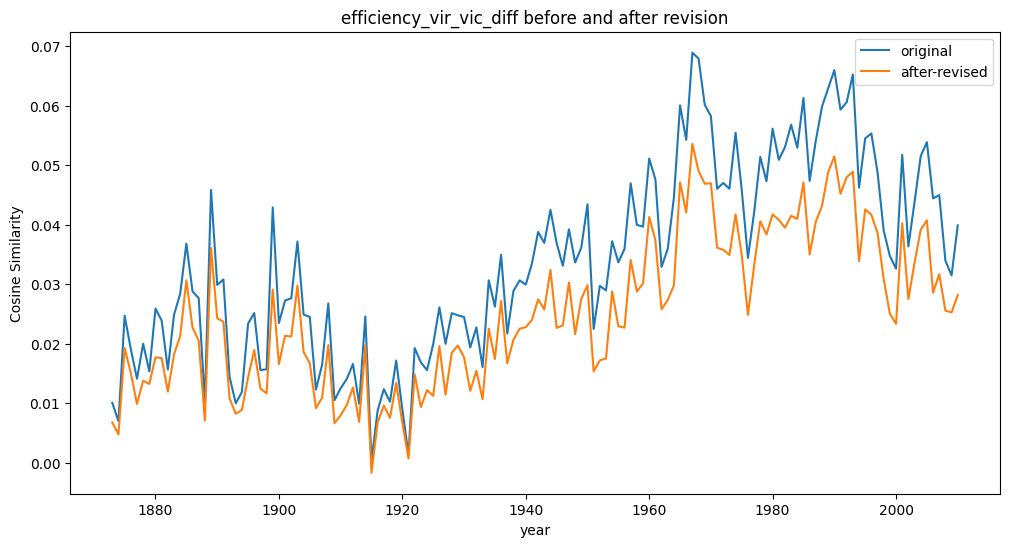

Correlation of inefficient_effort between original and after-revised: stat=0.7701265558875481, p=2.4615520344058394e-28


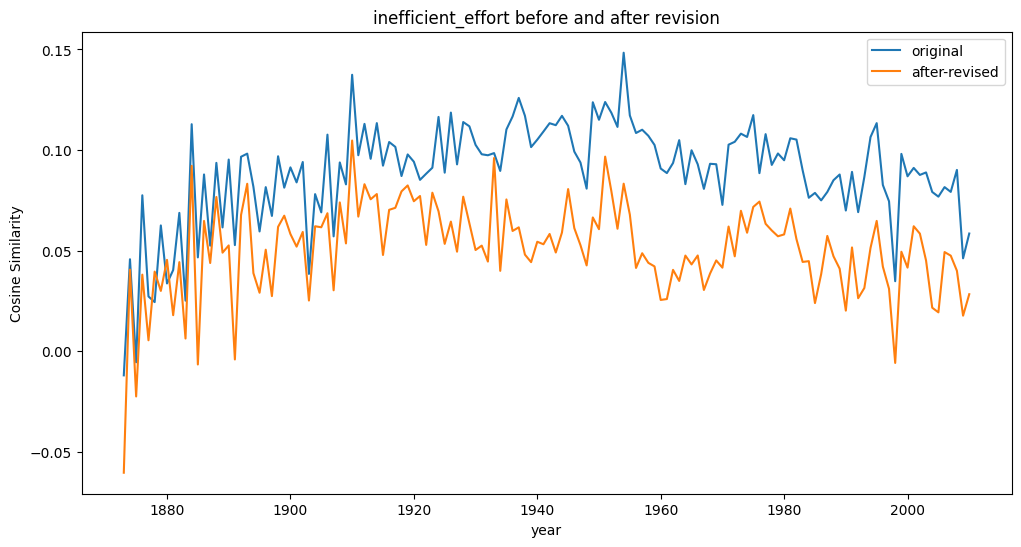

Chinese data with synonyms
Correlation of effort_vir_vic_diff between original and after-revised: stat=0.7025268231522457, p=6.083450876758403e-12


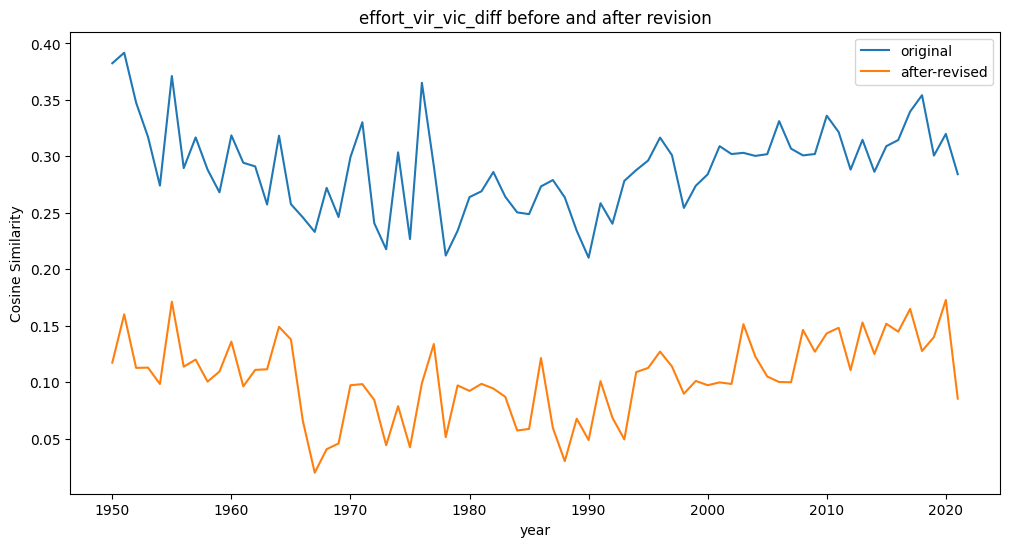

Correlation of efficiency_vir_vic_diff between original and after-revised: stat=0.811078975430061, p=5.79844566359501e-18


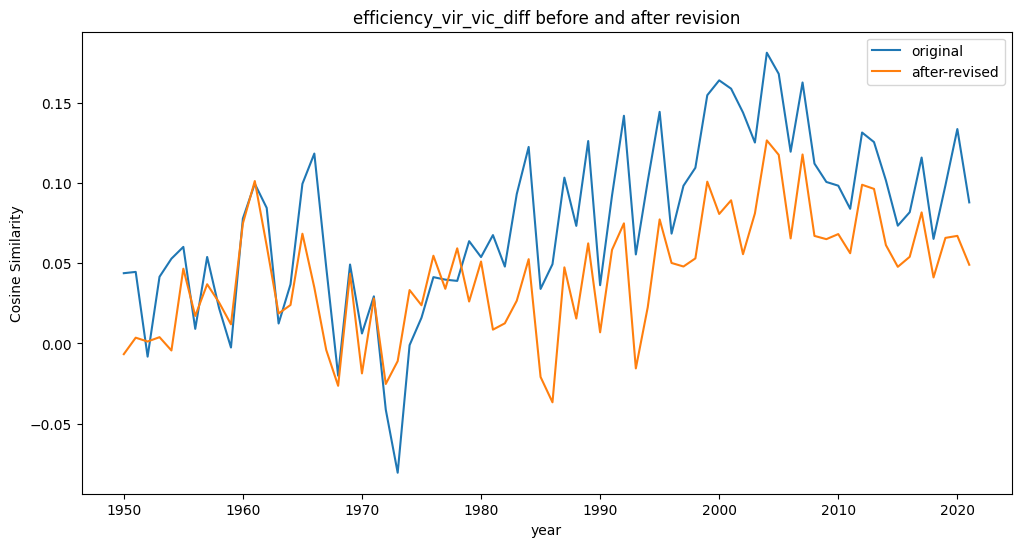

Correlation of inefficient_effort between original and after-revised: stat=0.8680766620864678, p=5.589873063470743e-23


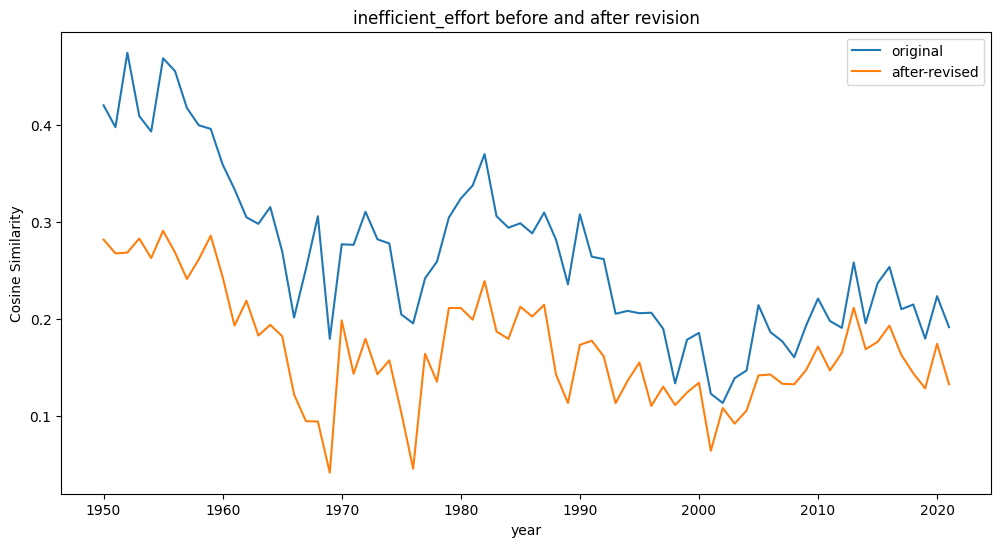

(0.8680766620864678, 5.589873063470743e-23)

In [ ]:
print("US data with synonyms")
compare_before_after(dfus_ori, dfus_syn, 'effort_vir_vic_diff')
compare_before_after(dfus_ori, dfus_syn, 'efficiency_vir_vic_diff')
compare_before_after(dfus_ori, dfus_syn, 'inefficient_effort')

print("Chinese data with synonyms")
compare_before_after(dfchi_ori, dfchi_syn, 'effort_vir_vic_diff')
compare_before_after(dfchi_ori, dfchi_syn, 'efficiency_vir_vic_diff')
compare_before_after(dfchi_ori, dfchi_syn, 'inefficient_effort')


Correlation of Effort between original and pruned dictionaries: r=1.00, p=0.000
Correlation of Efficiency between original and pruned dictionaries: r=0.99, p=0.000
Correlation of Inefficient Effort between original and pruned dictionaries: r=0.93, p=0.000
Correlation of Effort between original and pruned dictionaries: r=1.00, p=0.000
Correlation of Efficiency between original and pruned dictionaries: r=1.00, p=0.000
Correlation of Inefficient Effort between original and pruned dictionaries: r=1.00, p=0.000


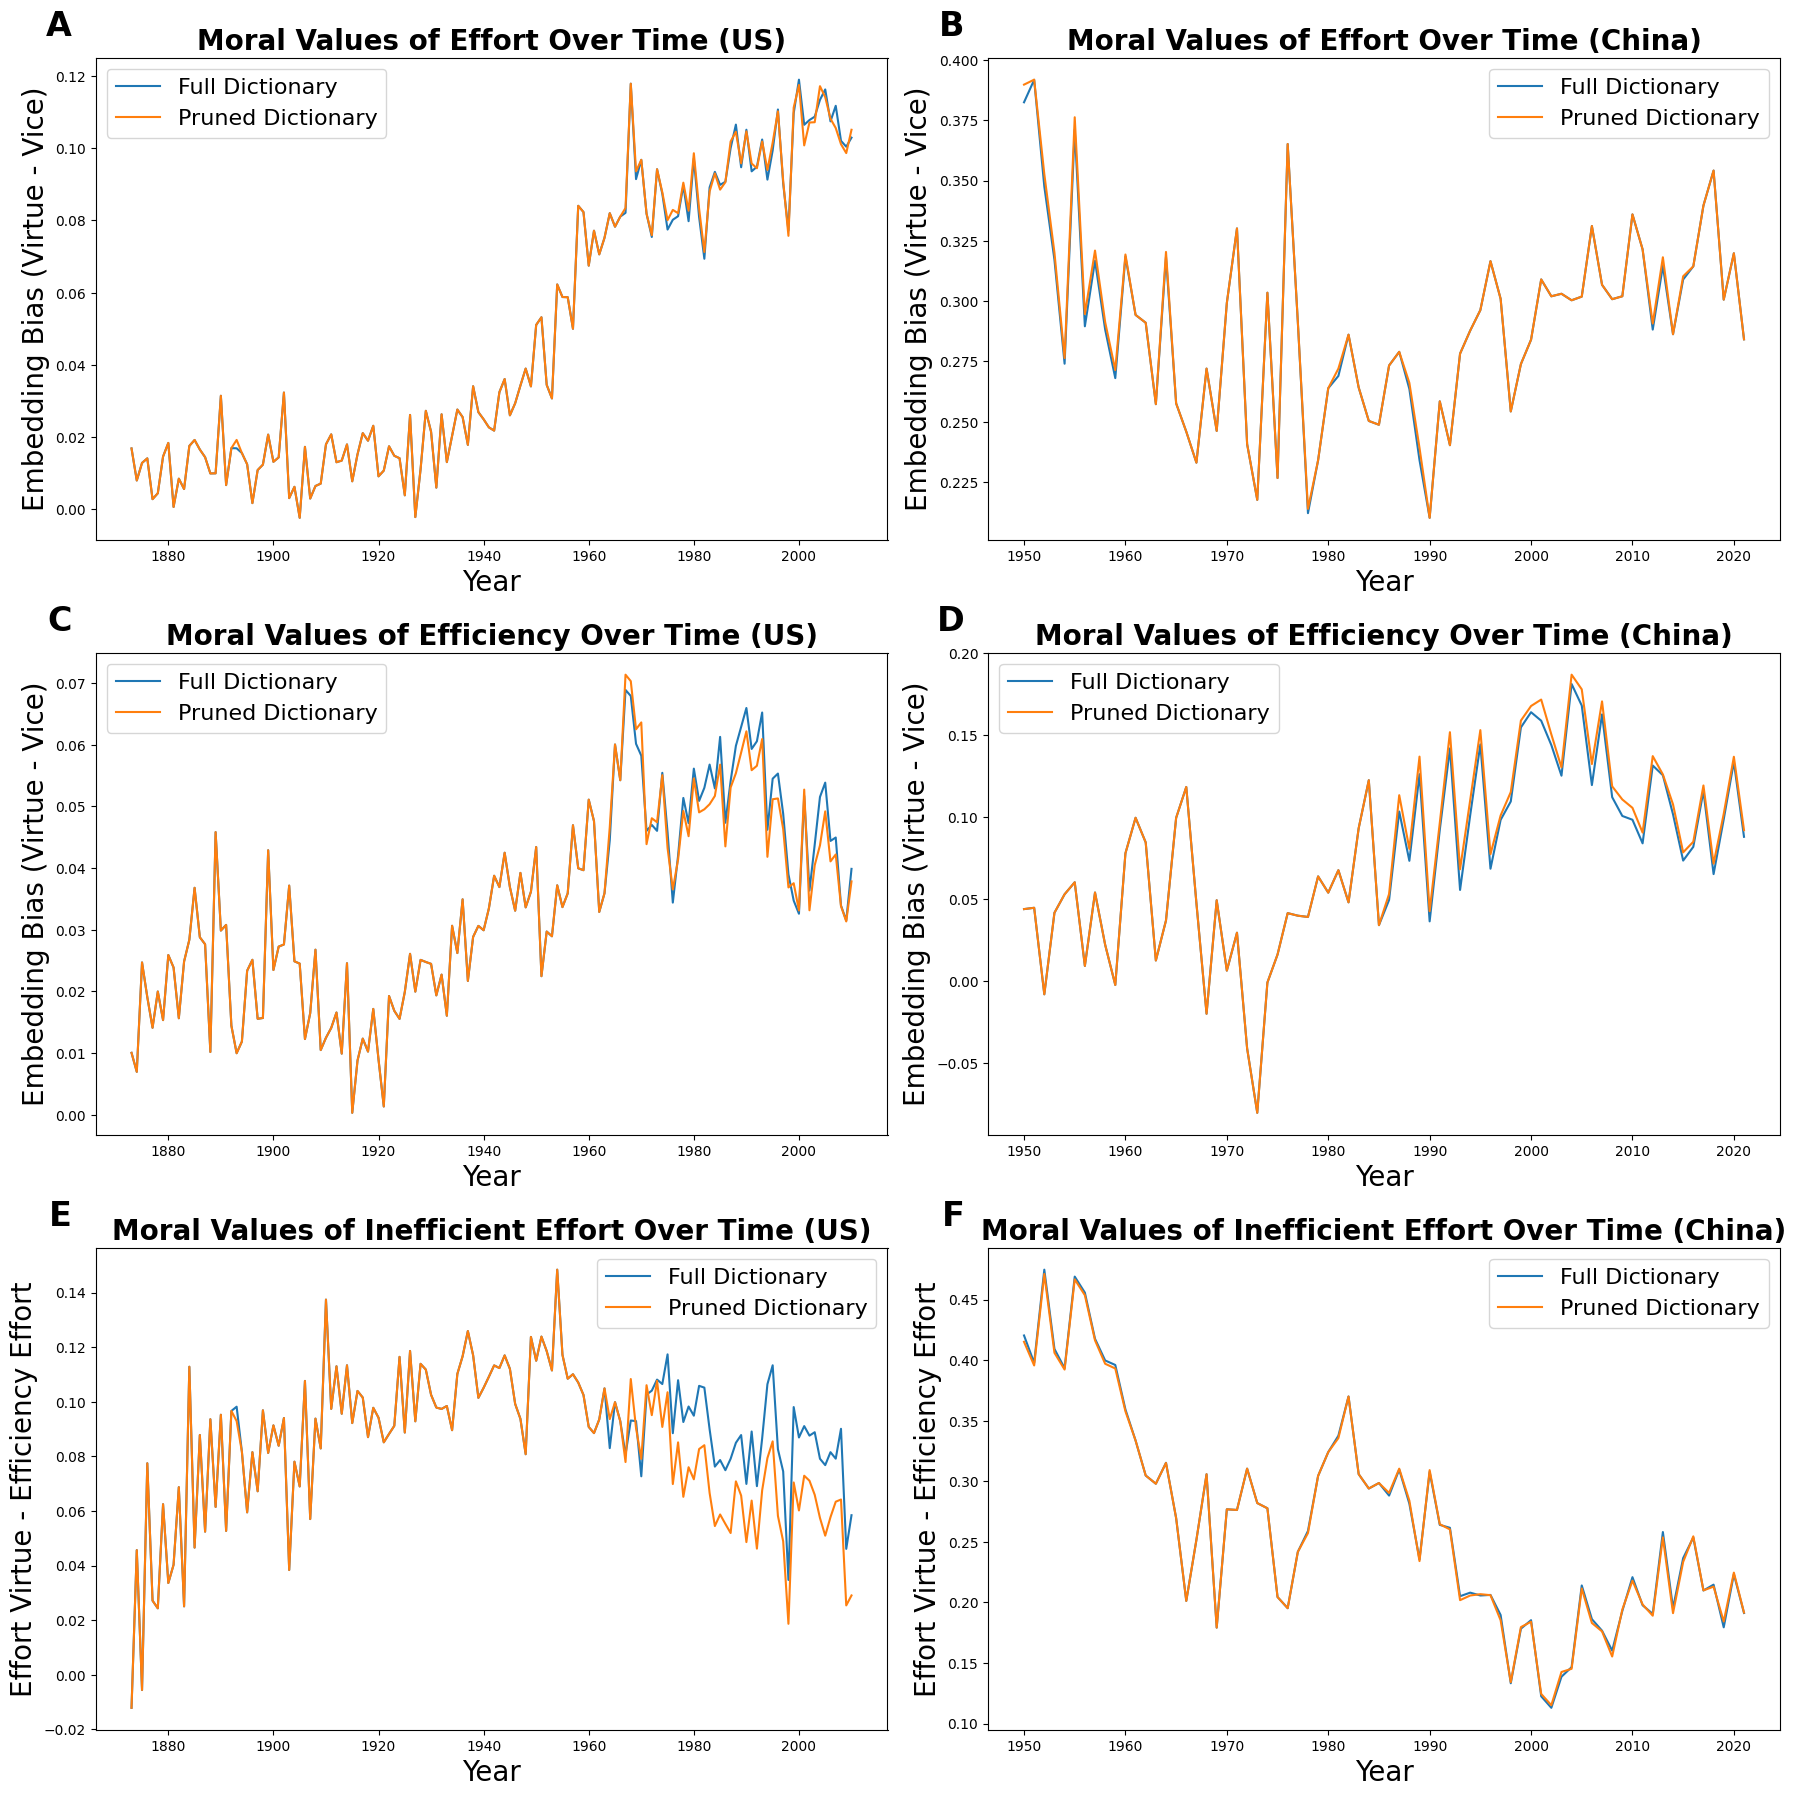

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

def compare_before_after(dfbefore, dfafter, var, varname, ax, ylabel="Embedding Bias (Virtue - Vice)", subplotlabel='A', country='US'):
    # Merge the two DataFrames on 'year' and keep only matched rows
    df_merge = pd.merge(dfbefore, dfafter, on='year', how='inner', suffixes=('_orig', '_pruned'))
    
    # Perform the correlation test
    stat, p = pearsonr(df_merge[f'{var}_orig'], df_merge[f'{var}_pruned'])
    print(f"Correlation of {varname} between original and pruned dictionaries: r={stat:.2f}, p={p:.3f}")
    
    # Plot the results
    sns.lineplot(data=df_merge, x='year', y=f'{var}_orig', label='Full Dictionary', ax=ax)
    sns.lineplot(data=df_merge, x='year', y=f'{var}_pruned', label='Pruned Dictionary', ax=ax)
    ax.set_title(f'Moral Values of {varname} Over Time ({country})', fontweight='bold', fontsize=20)
    ax.text(-0.03, 1.1, subplotlabel, transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
    ax.set_ylabel(ylabel if varname != 'Inefficient Effort' else 'Effort Virtue - Efficiency Effort', fontsize=20)
    ax.set_xlabel('Year', fontsize=20)
    ax.legend(fontsize=16)

# Set up a larger figure to hold all subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 18))  # 3 rows, 2 columns

# Adjust the order of subplots to put US on the first column and China on the second column
# US Data
compare_before_after(dfus_ori, dfus, 'effort_vir_vic_diff', 'Effort', axs[0, 0], subplotlabel='A')
compare_before_after(dfus_ori, dfus, 'efficiency_vir_vic_diff', 'Efficiency', axs[1, 0], subplotlabel='C')
compare_before_after(dfus_ori, dfus, 'inefficient_effort', 'Inefficient Effort', axs[2, 0], subplotlabel='E')

# Chinese Data
compare_before_after(dfchi_ori, dfchi, 'effort_vir_vic_diff', 'Effort', axs[0, 1], subplotlabel='B', country='China')
compare_before_after(dfchi_ori, dfchi, 'efficiency_vir_vic_diff', 'Efficiency', axs[1, 1], subplotlabel='D', country='China')
compare_before_after(dfchi_ori, dfchi, 'inefficient_effort', 'Inefficient Effort', axs[2, 1], subplotlabel='F', country='China')

plt.tight_layout()
plt.show()

In [ ]:
# test whether hard-work, hard-working, hardworking are in the model across the years and organize into a dataframe
word = ['hard-work', 'hard-working', 'hardworking','cost-effective']
years = list(models.keys())
rows = []
for year in years:
    model = models[year]
    for w in word:
        if w in model.wv.key_to_index:
            rows.append({'year': year, 'word': w, 'in_model': True})
        else:
            rows.append({'year': year, 'word': w, 'in_model': False})

df_hardwork = pd.DataFrame(rows)
df_hardwork


year            word  in_model
0    1873       hard-work     False
1    1873    hard-working     False
2    1873     hardworking      True
3    1873  cost-effective     False
4    1874       hard-work     False
..    ...             ...       ...
547  2009  cost-effective     False
548  2010       hard-work     False
549  2010    hard-working     False
550  2010     hardworking      True
551  2010  cost-effective     False

[552 rows x 3 columns]

# Retraining by party and year

## speech_id by party and year

In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# File paths and settings
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
indir = mainpath+'/Congress/hein-bound/'
outdir = mainpath+'/Congress/hein-bound_parsed_party/'
party_full = mainpath+'/Congress/party_full.txt'
first = 43
last = 111
encoding = 'Windows-1252'

# Read and categorize party_full.txt
dfparty = pd.read_csv(party_full, sep='|')
dfparty['party_code'] = dfparty['party'].astype(str)

def process_congress(congress, dfparty, indir, encoding):
    try:
        speaker_map_file = os.path.join(indir, f'{congress:03}_SpeakerMap.txt')
        speech_file = f'speeches_{congress:03}.txt'

        df_speaker_map = pd.read_csv(speaker_map_file, sep='|', encoding=encoding, skiprows=1, header=None,
                                     names=['speakerid', 'speech_id', 'lastname', 'firstname', 'chamber', 'state', 'gender', 'party_code', 'district', 'nonvoting'])

        df_speaker_map = df_speaker_map.merge(dfparty, how='left', on='party_code')
        df_speaker_map['speech_file'] = speech_file

        return df_speaker_map[['speech_id', 'party_code', 'party_full', 'speech_file']]
    except Exception as e:
        print(f"Failed to process congress {congress}: {e}")
        return pd.DataFrame()

results = []

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_congress, congress, dfparty, indir, encoding): congress for congress in range(first, last+1)}
    for future in tqdm(futures, total=len(futures), desc='Processing Congress Sessions'):
        result = future.result()
        if not result.empty:
            results.append(result)
            
# df_speech_metadata = pd.concat(results, ignore_index=True)
# # # save
# df_speech_metadata.to_csv(mainpath+'/Congress/speech_metadata.csv', index=False)
# print("Processing completed.")

Processing Congress Sessions: 100%|██████████| 69/69 [06:49<00:00,  5.93s/it]


In [ ]:
dfyear = pd.read_csv(mainpath+'/Congress/congress_year.csv', sep=',')
dfyear

speech_id  year  filenum
0          430000001  1873       43
1          430000002  1873       43
2          430000003  1873       43
3          430000004  1873       43
4          430000005  1873       43
...              ...   ...      ...
17395879  1110179264  2010      111
17395880  1110179265  2010      111
17395881  1110179266  2010      111
17395882  1110179267  2010      111
17395883  1110179268  2010      111

[17395884 rows x 3 columns]

In [ ]:
import os
import pandas as pd


# File paths and settings
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'

party_full = mainpath+'/Congress/party_full.txt'
encoding = 'Windows-1252'

dfyear = pd.read_csv(mainpath+'/Congress/congress_year.csv', sep=',')
dfmerge_all = pd.DataFrame()
for result in tqdm(results):
    dfresult = result.drop(columns=['party_full'])
    dfresult = dfresult.drop_duplicates()
    dfmerge = pd.merge(dfresult, dfyear, on = 'speech_id', how='left')
    dfmerge_all = pd.concat([dfmerge_all, dfmerge], ignore_index=True)
dfmerge_all.to_csv(mainpath+'/Congress/congress_party_year.csv', index=False)
preprocessed_path ='../2_pipeline/preprocessed/'
# copy the file to preprocessed folder
import shutil
shutil.copy(mainpath+'/Congress/congress_party_year.csv', preprocessed_path)
# df_speech_metadata = pd.read_csv(mainpath+'/Congress/speech_metadata.csv')

# # delete party_full column
# df_speech_metadata = df_speech_metadata.drop(columns=['party_full'])
# # delete duplicate
# df_speech_metadata = df_speech_metadata.drop_duplicates()
# df = pd.merge(df_speech_metadata, dfyear, on = 'speech_id', how='left')
# df.to_csv(mainpath+'/Congress/congress_party_year.csv', index=False)

100%|██████████| 69/69 [08:37<00:00,  7.50s/it]


'../2_pipeline/preprocessed/congress_party_year.csv'

In [ ]:
import pandas as pd
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
dfmerge_all = pd.read_csv(mainpath+'/Congress/congress_party_year.csv')
dfmerge_all

speech_id party_code       speech_file  year  filenum
0          430000002          R  speeches_043.txt  1873       43
1          430000007          R  speeches_043.txt  1873       43
2          430000008          R  speeches_043.txt  1873       43
3          430000010          R  speeches_043.txt  1873       43
4          430000011          R  speeches_043.txt  1873       43
...              ...        ...               ...   ...      ...
13311250  1110120299          D  speeches_111.txt  2010      111
13311251  1110120303          D  speeches_111.txt  2010      111
13311252  1110120587          R  speeches_111.txt  2010      111
13311253  1110134147          D  speeches_111.txt  2010      111
13311254  1110168389          R  speeches_111.txt  2010      111

[13311255 rows x 5 columns]

In [ ]:
# descriptive data for df
# count how many party_code == D grouped by year
dfonlyRD = dfmerge_all[dfmerge_all['party_code'].isin(['D', 'R'])]
dffreq = dfonlyRD.groupby(['year', 'party_code']).size().unstack().fillna(0)
dffreq

party_code      D      R
year                    
1873         1440   3834
1874        14763  45537
1875         8931  21692
1876        31107  38105
1877        16235  16595
...           ...    ...
2006        25984  27566
2007        48926  32876
2008        30499  19873
2009        40021  31878
2010        25599  14345

[138 rows x 2 columns]

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


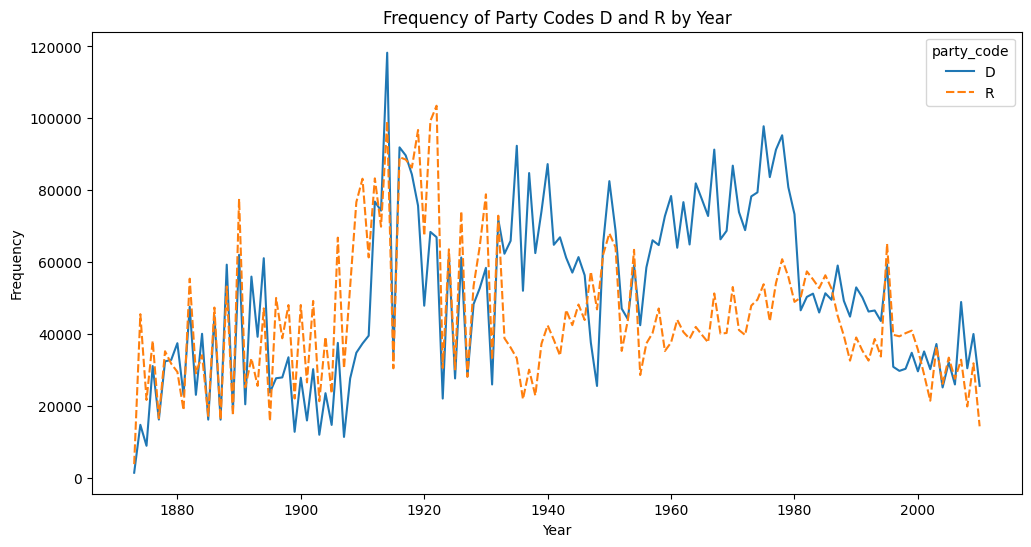

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# plot frequency of party_code == D and party_code == R grouped by year in one plot
# the graph should be a line plot with year on x-axis and frequency on y-axis

plt.figure(figsize=(12, 6))
sns.lineplot(data=dffreq)
plt.title('Frequency of Party Codes D and R by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


speakerid  speech_id  lastname firstname chamber state gender  \
0       43044451  430000002    HAMLIN  HANNIBAL       S    ME      M   
1       43049531  430000007   ANTHONY     HENRY       S    RI      M   
2       43049531  430000008   ANTHONY     HENRY       S    RI      M   
90924   43044451  430000009    HAMLIN  HANNIBAL       S    ME      M   
3       43047111  430000010  CONKLING    ROSCOE       S    NY      M   
...          ...        ...       ...       ...     ...   ...    ...   
73278   43048000  430119297  GARFIELD     JAMES       H    OH      M   
73279   43048000  430119298  GARFIELD     JAMES       H    OH      M   
73280   43060930  430119299    HOLMAN   WILLIAM       H    IN      M   
73281   43060930  430119300    HOLMAN   WILLIAM       H    IN      M   
73282   43052640  430119301     DAWES     HENRY       H    MA      M   

      party_code  district nonvoting  
0              R       NaN    voting  
1              R       NaN    voting  
2              R       NaN    voting  
90924          R       NaN    voting  
3              R       NaN    voting  
...          ...       ...       ...  
73278          R      19.0    voting  
73279          R      19.0    voting  
73280          D       3.0    voting  
73281          D       3.0    voting  
73282          R      11.0    voting  

[96115 rows x 10 columns]

## single congress parsed by party and year

In [ ]:
congress = 60
df = pd.read_csv(mainpath+'/Congress/congress_party_year.csv')
# Only keep rows with party_code 'D' or 'R'
df = df[df['party_code'].isin(['D', 'R'])]
group = df[df['filenum'] == congress]



speech_file_path = os.path.join(indir,group['speech_file'].iloc[0])
years = group['year'].unique()
parties = group['party_code'].unique()


for year in years:
    for party in parties:
        with open(speech_file_path, encoding=encoding) as f:
            print(f"Processing {speech_file_path}")
            print(f"Processing year {year} and party {party}")
            # get speech_id in the group that only has the corresponding year and party
            speech_id_expected = group[(group['year'] == year) & (group['party_code'] == party)]['speech_id']
            # speech_id_expected = group[(group['year'] == year)]['speech_id']
            # make data type as int list
            speech_id_expected = speech_id_expected.astype(int).tolist()
            # print the length of speech_id_expected
            print(f"Number of speech_id_expected: {len(speech_id_expected)}")
            outlines_by_speech_id = {}
            for line in f:
                line = line.strip()
                parts = line.split('|')
                speech_id = parts[0]

                if speech_id != 'speech_id' and int(speech_id) in speech_id_expected:
                    text = parts[1] if len(parts) > 1 else ""
                    parsed = nlp(text)
                    sents = [sent.text for sent in parsed.sents]
                    tokens = [[token.text for token in sent] for sent in parsed.sents]
                    assert len(sents) == len(tokens)

                    outlines_by_speech_id[speech_id] = {
                        'id': speech_id,
                        'sents': sents,
                        'tokens': tokens
                    }
                else:
                    # print(f"Skipping speech {speech_id}")
                    continue
        # make congress_num as 3 digits
        congress_num = str(group['filenum'].values[0]).zfill(3)
        speech_year_party_name = f'speeches_{congress_num}_{year}_{party}'
        # speech_year_party_name = f'speeches_{congress_num}_{year}'
        outfile_json = os.path.join(outdir, f'{speech_year_party_name}.json')
        outfile_text = os.path.join(outdir, f'{speech_year_party_name}.txt')
        print(f"Saving {len(outlines_by_speech_id)} entries to {outfile_json}")

        with open(outfile_json, 'w') as fo_json:
            for line in outlines_by_speech_id:
                fo_json.write(json.dumps(line) + '\n')
                # fo_text.write(' '.join([' '.join(tokens) for tokens in line['tokens']]) + '\n')

Processing /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound/speeches_060.txt
Processing year 1907 and party R
Number of speech_id_expected: 685
Saving 685 entries to /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed_party_year/speeches_060_1907_R.json
Processing /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound/speeches_060.txt
Processing year 1907 and party D
Number of speech_id_expected: 387
Saving 387 entries to /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed_party_year/speeches_060_1907_D.json
Processing /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound/speeches_060.txt
Processing year 1908 and party R
Number of speech_id_expected: 53291
Saving 53291 entries to /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed_party_year/speeches_060_1908_R.json
Processing /home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound/s

In [ ]:
# get the dataframe only year == year and party_code ==party
selected_df = group[(group['year'] == year) & (group['party_code'] == party)]
selected_df['speech_id']

2253529    600000004
2253534    600000019
2253535    600000022
2253537    600000029
2253538    600000032
             ...    
2364607    600001486
2364608    600001488
2364609    600001490
2364610    600001492
2379513    600000269
Name: speech_id, Length: 387, dtype: int64

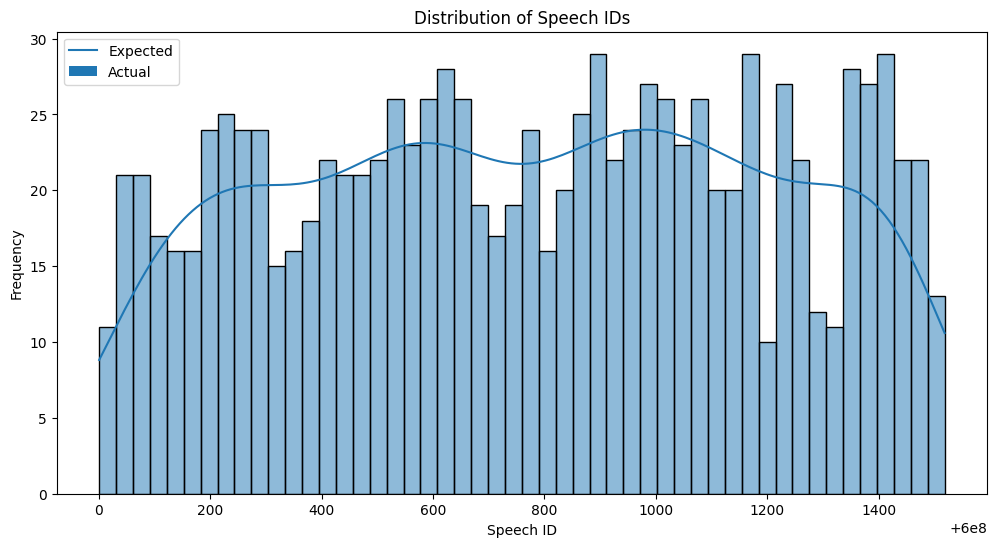

In [ ]:
# check the overlap between speech_id_expected and speech_ids
overlap = set(speech_id_expected) & set(speech_ids)
# visualize the distribition of speech_id_expected and speech_ids
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(data=[speech_id_expected, speech_ids], bins=50, kde=True)
plt.title('Distribution of Speech IDs')
plt.xlabel('Speech ID')
plt.ylabel('Frequency')
plt.legend(['Expected', 'Actual'])
plt.show()


In [ ]:
(len(group))

127473

In [ ]:
# get the speech_file from group datafram
speech_file_name = group['speech_file'].iloc[0]
speech_file_name


'speeches_044.txt'

In [ ]:

# Get the number of available CPU cores and leave one unoccupied
import multiprocessing
num_cores = max(1, multiprocessing.cpu_count() - 1)
num_cores

31

## word2vec training

In [ ]:
import os
import json
import pandas as pd
from gensim.models import Word2Vec
from concurrent.futures import ProcessPoolExecutor
import re
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
# Define directories
pro_dir = '../2_pipeline/preprocessed/'
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
data_dir = mainpath + "/Congress/hein-bound/"
text_dir = mainpath + "/Congress/hein-bound_parsed_party_year/"
model_dir = mainpath + "/Congress/model_by_year_party/"

# Ensure model directory exists
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Read the congressyear.csv into a dataframe
dfresults = pd.read_csv(os.path.join(pro_dir, 'congress_party_year.csv'), dtype={'filenum': str})
dfresults

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


speech_id party_code       speech_file  year filenum
0          430000002          R  speeches_043.txt  1873      43
1          430000007          R  speeches_043.txt  1873      43
2          430000008          R  speeches_043.txt  1873      43
3          430000010          R  speeches_043.txt  1873      43
4          430000011          R  speeches_043.txt  1873      43
...              ...        ...               ...   ...     ...
13311250  1110120299          D  speeches_111.txt  2010     111
13311251  1110120303          D  speeches_111.txt  2010     111
13311252  1110120587          R  speeches_111.txt  2010     111
13311253  1110134147          D  speeches_111.txt  2010     111
13311254  1110168389          R  speeches_111.txt  2010     111

[13311255 rows x 5 columns]

In [ ]:
year = 1873
party = 'D'
df_new = dfresults[(dfresults['year'] == year) & (dfresults['party_code'] == party)]
df_new

speech_id party_code       speech_file  year filenum
11     430000024          D  speeches_043.txt  1873      43
12     430000026          D  speeches_043.txt  1873      43
19     430000039          D  speeches_043.txt  1873      43
20     430000041          D  speeches_043.txt  1873      43
24     430000046          D  speeches_043.txt  1873      43
...          ...        ...               ...   ...     ...
91145  430006838          D  speeches_043.txt  1873      43
94803  430000982          D  speeches_043.txt  1873      43
94804  430000984          D  speeches_043.txt  1873      43
94869  430006043          D  speeches_043.txt  1873      43
94889  430006894          D  speeches_043.txt  1873      43

[1440 rows x 5 columns]

In [ ]:
import os
import json
import pandas as pd
from gensim.models import Word2Vec
from concurrent.futures import ProcessPoolExecutor
import re
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
# Define directories
pro_dir = '../2_pipeline/preprocessed/'
mainpath = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp'
data_dir = mainpath + "/Congress/hein-bound/"
text_dir = mainpath + "/Congress/hein-bound_parsed_party_year/"
model_dir = mainpath + "/Congress/model_by_year_party/"
clean_text_folder = os.path.join(mainpath, 'hein-bound_cleaned_party_year')

# Ensure dirs exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(clean_text_folder):
    os.makedirs(clean_text_folder)

# Read the congressyear.csv into a dataframe
dfresults = pd.read_csv(os.path.join(pro_dir, 'congress_party_year.csv'), dtype={'filenum': str})

def clean_text(text):
	# Remove any non-alphanumeric characters
	text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
	# Convert to lowercase
	text = text.lower()
	# remove digitsπ
	text = re.sub(r'\d+', '', text)

	return text

def train_model_for_year_party(year, party, dfresults):
	model_file = os.path.join(model_dir, f'{year}_{party}.model')
	if not os.path.exists(model_file):
		print(f"Training model for year {year}, party {party}")
		df_new = dfresults[(dfresults['year'] == year) & (dfresults['party_code'] == party)]

		allline = []
		
		for filenum in df_new['filenum'].unique():
			filenum = str(filenum).zfill(3)
			infile = os.path.join(text_dir, f'speeches_{filenum}_{year}_{party}.json')

			if os.path.exists(infile):
				with open(infile, 'r') as f:

					for line in f:
						jline = json.loads(line)
						# Clean each token in each sentence
						for sentence in jline['tokens']:  
							clean_sentence = [clean_text(token) for token in sentence]
							# Remove any empty tokens
							clean_sentence = [token for token in clean_sentence if token]
							allline.append(clean_sentence)
	
		if allline:
			# save the list of sentences of tokens to a json file
			outfile = os.path.join(clean_text_folder, f'{year}_{party}_cleaned.json')
			with open(outfile, 'w') as f:
				json.dump(allline, f)
			num_allline = len(allline)
			print(f"{num_allline} sentences of tokens saved to {outfile}")
			model = Word2Vec(sentences=allline)

			model.save(model_file)
			print(f"Model saved for year {year}, party {party} at {model_file}")
		else:
			print(f"No data to train the model for year {year}, party {party}.")
	else:
		print(f"Model already exists for year {year}, party {party} at {model_file}")


with ProcessPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
	futures = []
	years = range(1939,1941)
	# for year in dfresults['year'].unique():
	for year in years:
		for party in ['D', 'R']:  # Assuming parties are 'D' (Democrat) and 'R' (Republican)
			if (dfresults['party_code'] == party).any():
				futures.append(executor.submit(train_model_for_year_party, year, party, dfresults))

	for future in futures:
		future.result()  # This blocks until the future is complete




In [ ]:

infile = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed_party_year/speeches_076_1940_D.json'
allline = []

with open(infile, 'r') as f:
    for line in f:
        if line.strip():  # Check if the line is not empty
            try:
                jline = json.loads(line)
                # Clean each token in each sentence
                for sentence in jline['tokens']:  
                    clean_sentence = [clean_text(token) for token in sentence]
                    # Remove any empty tokens
                    clean_sentence = [token for token in clean_sentence if token]
                    allline.append(clean_sentence)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                print(f"Skipping line: {line}")

# Print a sample of the processed data to verify
print(allline[:5])

Error decoding JSON: Expecting value: line 1 column 1 (char 0)
Skipping line:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### test word2vec model

In [ ]:
model_path = os.path.join(model_dir, '1873_D.model')
model = Word2Vec.load(model_path)
model.wv.most_similar('freedom')

[('perquisites', 0.9940497875213623),
 ('works', 0.9938217401504517),
 ('preservation', 0.9938133955001831),
 ('withont', 0.9934043884277344),
 ('talent', 0.9933070540428162),
 ('concurrent', 0.992688775062561),
 ('industry', 0.9925636053085327),
 ('tion', 0.9924608469009399),
 ('vicious', 0.9924129843711853),
 ('owner', 0.992342472076416)]

In [ ]:
model_path = os.path.join(model_dir, '1873_R.model')
model = Word2Vec.load(model_path)
model.wv.most_similar('freedom')    

[('judging', 0.9692789912223816),
 ('applicable', 0.9688280820846558),
 ('contested', 0.968436062335968),
 ('essence', 0.9636281728744507),
 ('postal', 0.9628605842590332),
 ('contracts', 0.9626064300537109),
 ('specific', 0.9625869393348694),
 ('regulating', 0.9624670743942261),
 ('machinery', 0.9603631496429443),
 ('embraced', 0.9597426652908325)]

## extract embedding bias

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
from extract_cosine_similarities import load_dict, load_word2vec_models_byparty, calculate_cosine_similarities, create_bias_dataframe
import pandas as pd
import statistics
import random
import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
import json
import nltk

# # # Get the current script directory and create paths to the data and output folders
script_dir = os.path.dirname('/home/local/PSYCH-ADS/xuqian_chen/Github/effort/1_code/test_function.ipynb')
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
pipeline_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/preprocessed')
tmp_folder_path =os.path.join(os.path.dirname(script_dir), '2_pipeline/tmp')
# Models
model_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/model_by_year_party'
Rmodels,Dmodels = load_word2vec_models_byparty(model_folder_path)

# Load dictionaries
# Evaluations
foundations_path = os.path.join(data_folder_path, 'wordlist', 'dict_foundations.json')
foundations = load_dict(foundations_path)
evaluations_set= {'foundations': foundations}

# Targets (e.g., age groups)
targets_path = os.path.join(data_folder_path, 'wordlist', 'dict_targets.json')

foundations = load_dict(foundations_path)

targets = load_dict(targets_path)

# loop through Rmodels and Dmodels
for party, models in {'R': Rmodels, 'D': Dmodels}.items():
    for name, evaluations in evaluations_set.items():
        # Calculate cosine similarities
        similarities = calculate_cosine_similarities(models, targets, evaluations)
        
        # Calculate embedding bias
        dfbias = create_bias_dataframe(similarities, targets, evaluations)
       
        # Save the DataFrame as a CSV
        csv_filepath = os.path.join(pipeline_folder_path, f'{name}_{party}.csv')
        dfbias.to_csv(csv_filepath, index=False)
        
    

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


1873 efficiency care_vic Not found
1873 efficiency care_vir Not found
1873 efficiency loya_vic Not found
1873 efficiency loya_vir Not found
1873 efficiency auth_vic Not found
1873 efficiency auth_vir Not found
1873 efficiency sanc_vic Not found
1873 efficiency sanc_vir Not found
1873 efficiency fare_vic Not found
1873 efficiency fare_vir Not found


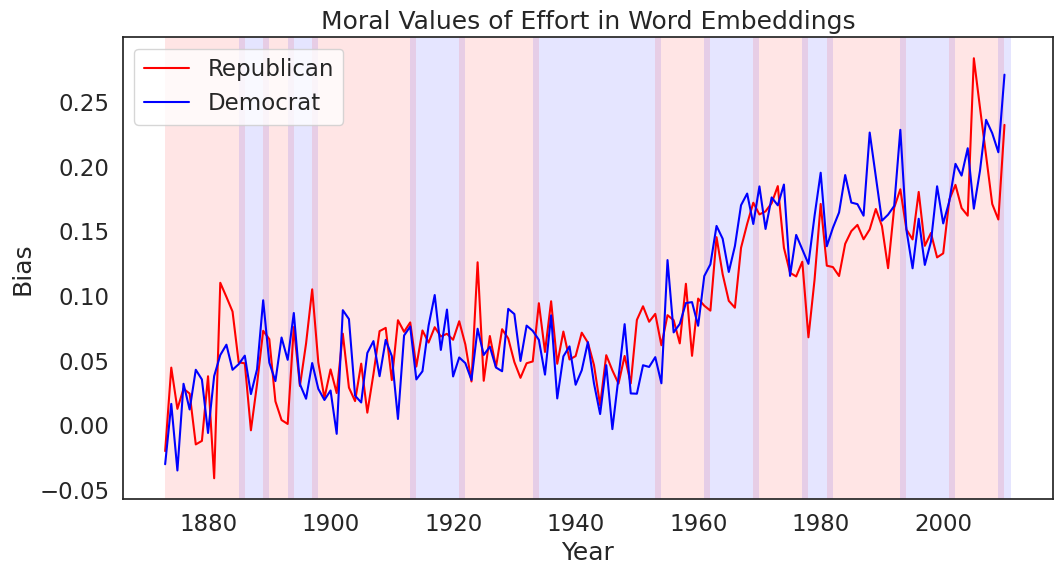

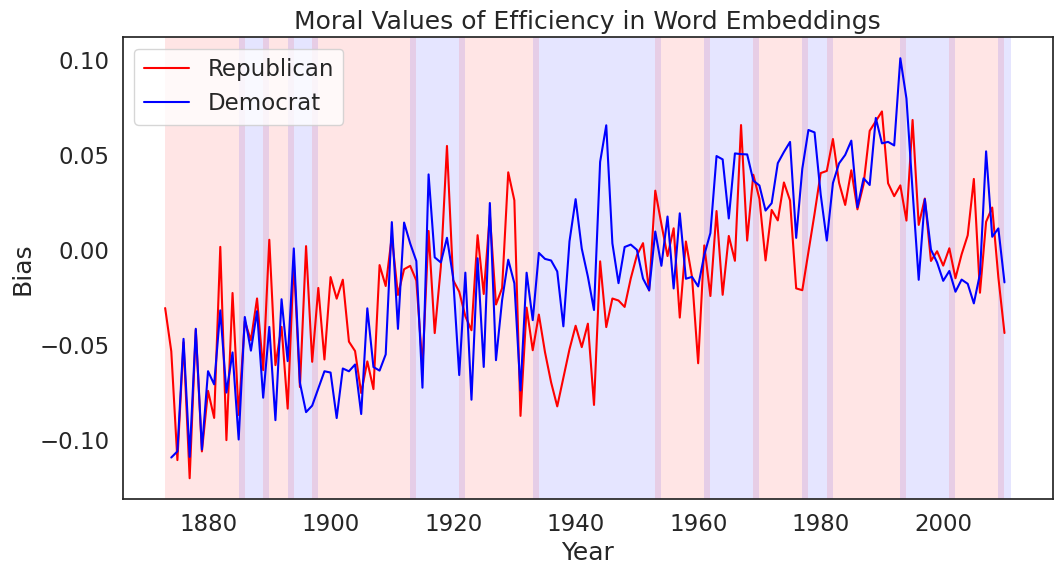

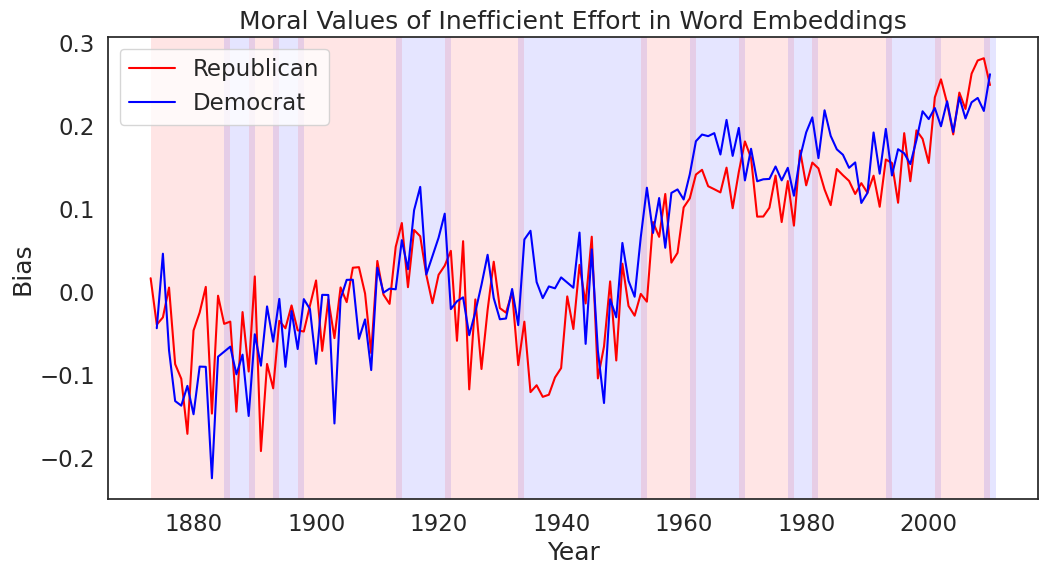

In [9]:
# plot the bias dataframe across years
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

script_dir = os.path.dirname('/home/local/PSYCH-ADS/xuqian_chen/Github/effort/1_code/test_function.ipynb')
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
pipeline_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/preprocessed')
tmp_folder_path =os.path.join(os.path.dirname(script_dir), '2_pipeline/tmp')
external_path = os.path.join(os.path.dirname(script_dir), '0_data/external')
# Load the bias DataFrames
Rdfbias = pd.read_csv(os.path.join(pipeline_folder_path, 'foundations_R.csv'))
Ddfbias = pd.read_csv(os.path.join(pipeline_folder_path, 'foundations_D.csv'))
# load party_government_year
party_government_year = pd.read_csv(os.path.join(external_path, 'party_government_year.csv'))
# merge by year
dfbias = pd.merge(Rdfbias, Ddfbias, on='year', suffixes=('_R', '_D'))

# Merge this with the party_government_year to get the party information per year
dfbias = dfbias.merge(party_government_year[['year', 'Presidency_party']], on='year', how='left')

dfbias['effort_R-D'] = dfbias['effort_vir_vic_diff_R'] - dfbias['effort_vir_vic_diff_D']
# delete duplicate rows
dfbias = dfbias.drop_duplicates()
# Plot the bias DataFrames
plt.figure(figsize=(12, 6))

sns.lineplot(data=dfbias, x='year', y='effort_vir_vic_diff_R',color='red',label='Republican')
sns.lineplot(data=dfbias, x='year', y='effort_vir_vic_diff_D', color='blue',label='Democrat')

plt.title('Moral Values of Effort in Word Embeddings')
# sns.lineplot(data=dfbias, x='year', y='effort_R-D', color='black')
party_colors = {
    'Republican': 'red',
    'Democrat': 'blue'
}

for _, row in dfbias.iterrows():
    plt.axvspan(row['year'],row['year']+1, facecolor=party_colors[row['Presidency_party']], alpha=0.1,edgecolor='none')

plt.xlabel('Year')
plt.ylabel('Bias')
plt.show()

# another plot about efficiency
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfbias, x='year', y='efficiency_vir_vic_diff_R',color='red',label='Republican')
sns.lineplot(data=dfbias, x='year', y='efficiency_vir_vic_diff_D', color='blue',label='Democrat')
plt.title('Moral Values of Efficiency in Word Embeddings')
party_colors = {
    'Republican': 'red',
    'Democrat': 'blue'
}

for _, row in dfbias.iterrows():
    plt.axvspan(row['year'],row['year']+1, facecolor=party_colors[row['Presidency_party']], alpha=0.1,edgecolor='none')

plt.xlabel('Year')
plt.ylabel('Bias')
plt.show()

# another plot about inefficient effort
plt.figure(figsize=(12, 6))
dfbias['inefficient_effort_R'] = dfbias['effort_virtue_R'] - dfbias['efficiency_virtue_R']
dfbias['inefficient_effort_D'] = dfbias['effort_virtue_D'] - dfbias['efficiency_virtue_D']
sns.lineplot(data=dfbias, x='year', y='inefficient_effort_R',color='red',label='Republican')
sns.lineplot(data=dfbias, x='year', y='inefficient_effort_D', color='blue',label='Democrat')
plt.title('Moral Values of Inefficient Effort in Word Embeddings')
party_colors = {
    'Republican': 'red',
    'Democrat': 'blue'
}

for _, row in dfbias.iterrows():
    plt.axvspan(row['year'],row['year']+1, facecolor=party_colors[row['Presidency_party']], alpha=0.1,edgecolor='none')

plt.xlabel('Year')
plt.ylabel('Bias')
plt.show()


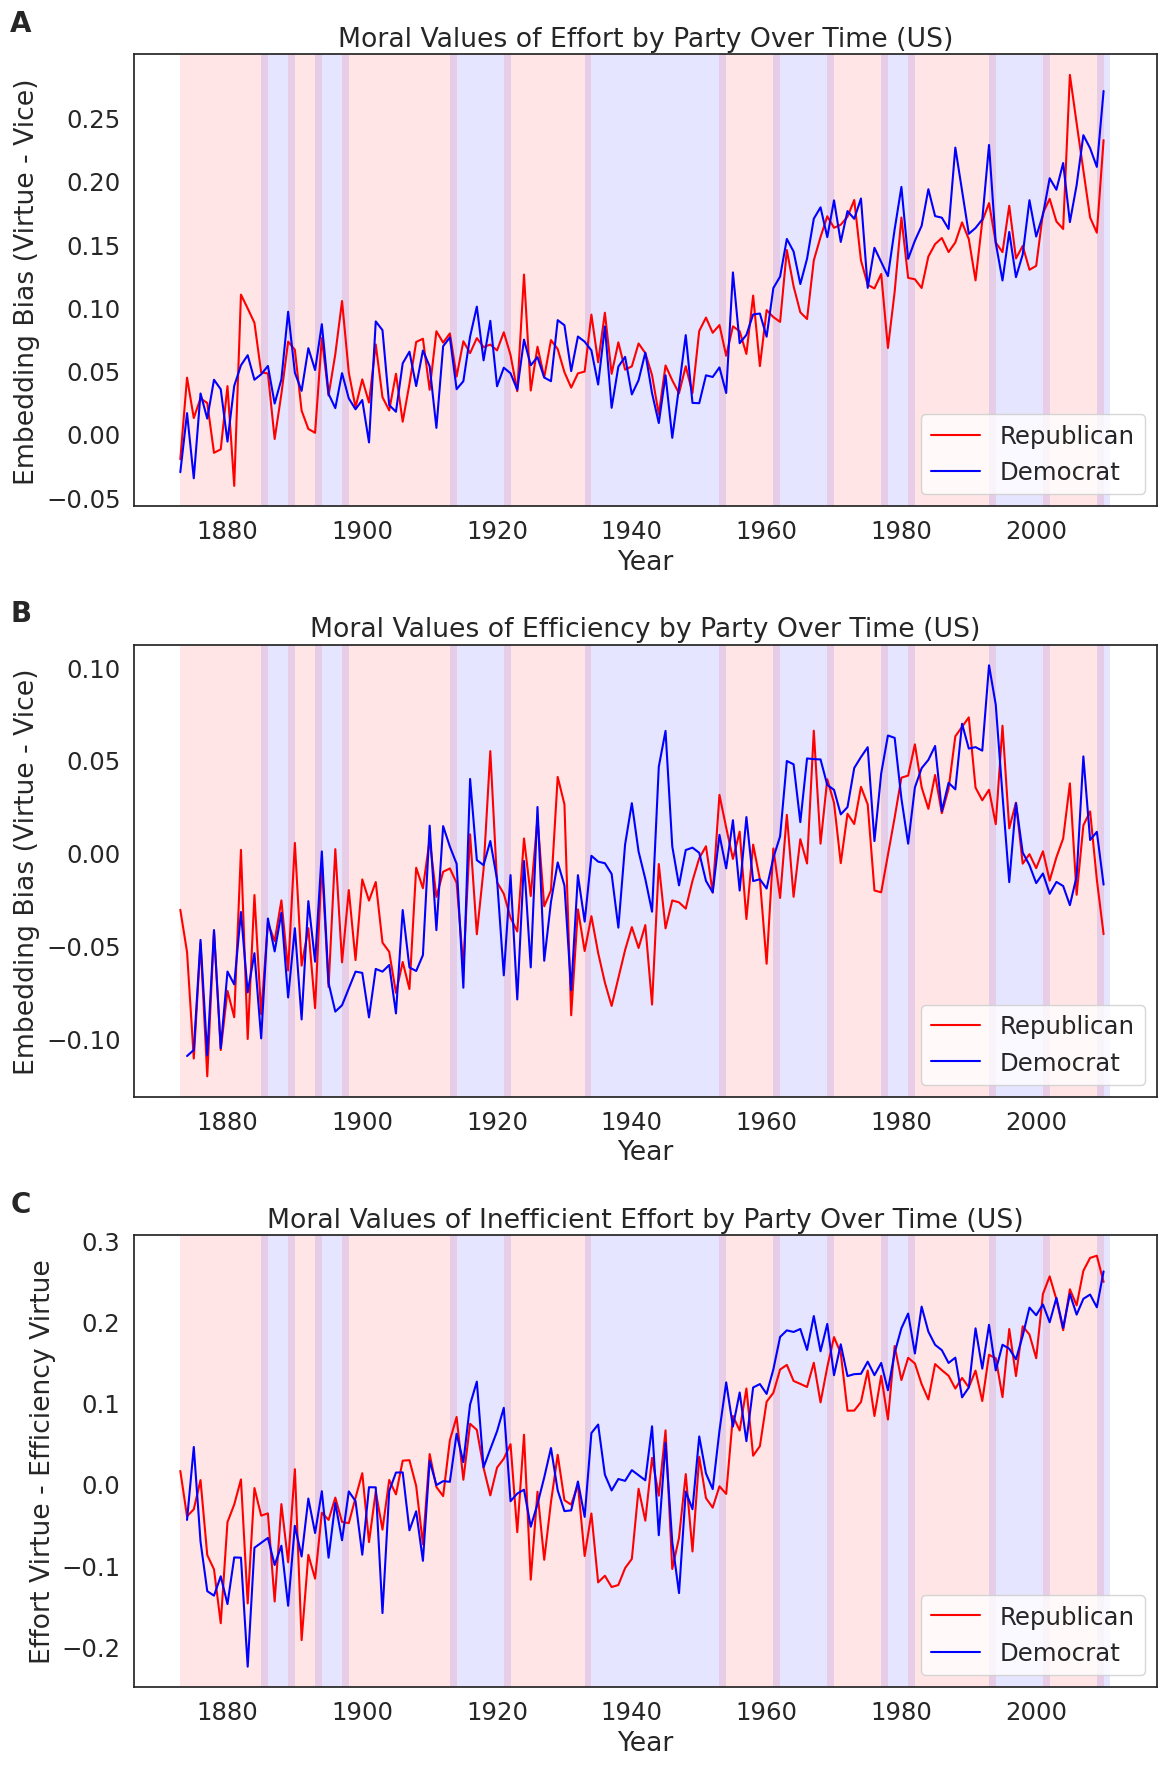

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style
sns.set(style="white", font_scale=1.6)

# Create a figure to hold the subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# Define the labels for each subplot
subplot_labels = ['A', 'B', 'C']

# Plot for Effort
sns.lineplot(ax=axs[0], data=dfbias, x='year', y='effort_vir_vic_diff_R', color='red', label='Republican')
sns.lineplot(ax=axs[0], data=dfbias, x='year', y='effort_vir_vic_diff_D', color='blue', label='Democrat')
axs[0].text(-0.1, 1.1, subplot_labels[0], transform=axs[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
axs[0].set_title('Moral Values of Effort by Party Over Time (US)')
axs[0].set_ylabel('Embedding Bias (Virtue - Vice)')
axs[0].set_xlabel('Year')
# Plot for Efficiency
sns.lineplot(ax=axs[1], data=dfbias, x='year', y='efficiency_vir_vic_diff_R', color='red', label='Republican')
sns.lineplot(ax=axs[1], data=dfbias, x='year', y='efficiency_vir_vic_diff_D', color='blue', label='Democrat')
axs[1].text(-0.1, 1.1, subplot_labels[1], transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
axs[1].set_title('Moral Values of Efficiency by Party Over Time (US)')
axs[1].set_ylabel('Embedding Bias (Virtue - Vice)')
axs[1].set_xlabel('Year')
# Plot for Inefficient Effort
sns.lineplot(ax=axs[2], data=dfbias, x='year', y='inefficient_effort_R', color='red', label='Republican')
sns.lineplot(ax=axs[2], data=dfbias, x='year', y='inefficient_effort_D', color='blue', label='Democrat')
axs[2].text(-0.1, 1.1, subplot_labels[2], transform=axs[2].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
axs[2].set_title('Moral Values of Inefficient Effort by Party Over Time (US)')
axs[2].set_ylabel('Effort Virtue - Efficiency Virtue')
axs[2].set_xlabel('Year')
# Adding background color based on presidency
party_colors = {'Republican': 'red', 'Democrat': 'blue'}
for ax in axs:
    for _, row in dfbias.iterrows():
        ax.axvspan(row['year'], row['year']+1, facecolor=party_colors[row['Presidency_party']], alpha=0.1, edgecolor='none')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()

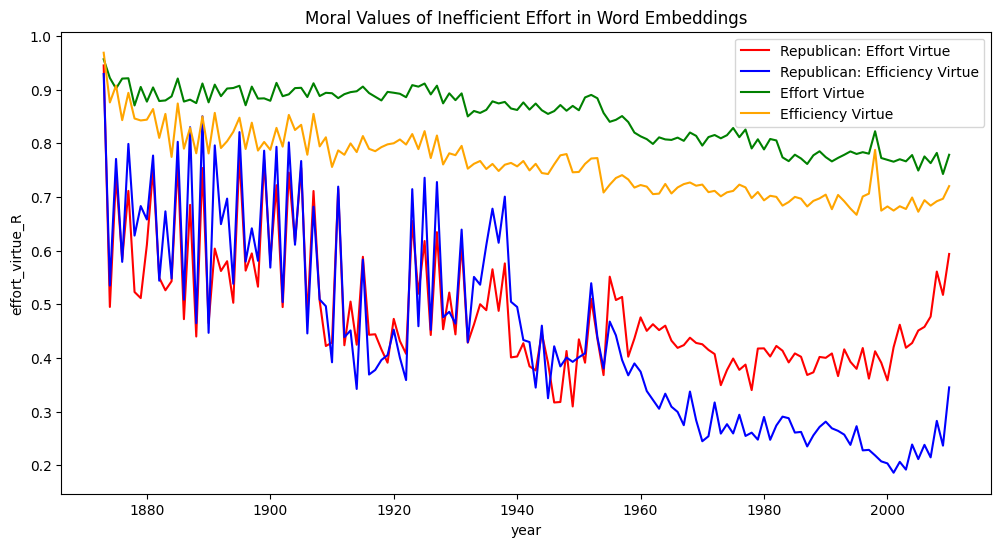

In [ ]:

df = pd.read_csv(os.path.join(pipeline_folder_path, 'foundations.csv'))
# plot effort virtue and vice for each party
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfbias, x='year', y='effort_virtue_R',color='red',label='Republican: Effort Virtue')
sns.lineplot(data=dfbias, x='year', y='efficiency_virtue_R', color='blue',label='Republican: Efficiency Virtue')
# plot effort virtue and efficiency virtue from df
sns.lineplot(data=df, x='year', y='effort_virtue',color='green',label='Effort Virtue')
sns.lineplot(data=df, x='year', y='efficiency_virtue', color='orange',label='Efficiency Virtue')
plt.title('Moral Values of Inefficient Effort in Word Embeddings')
plt.show()

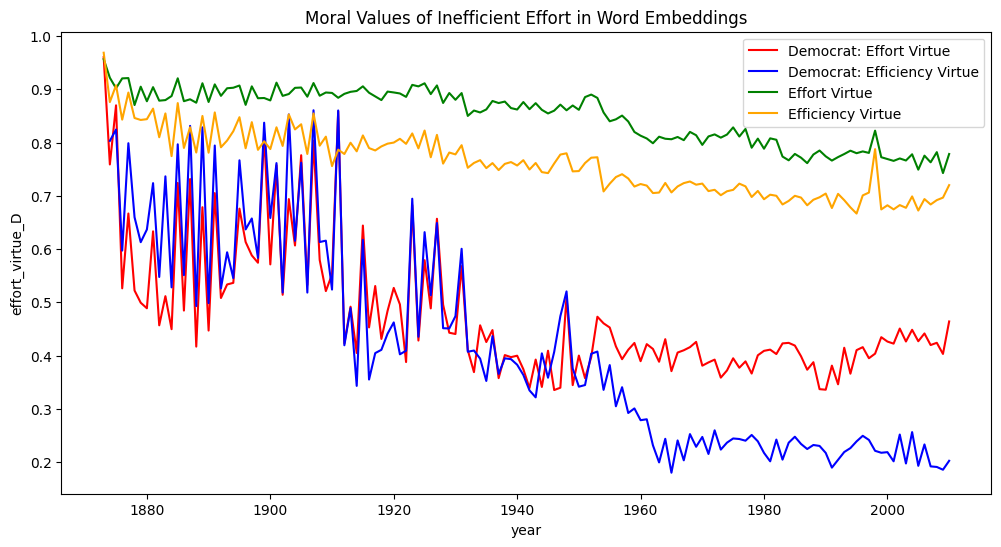

In [ ]:
# plot effort virtue and effort vice for each party
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfbias, x='year', y='effort_virtue_D',color='red',label='Democrat: Effort Virtue')
sns.lineplot(data=dfbias, x='year', y='efficiency_virtue_D', color='blue',label='Democrat: Efficiency Virtue')
# plot effort virtue and efficiency virtue from df
sns.lineplot(data=df, x='year', y='effort_virtue',color='green',label='Effort Virtue')
sns.lineplot(data=df, x='year', y='efficiency_virtue', color='orange',label='Efficiency Virtue')
plt.title('Moral Values of Inefficient Effort in Word Embeddings')
plt.show()


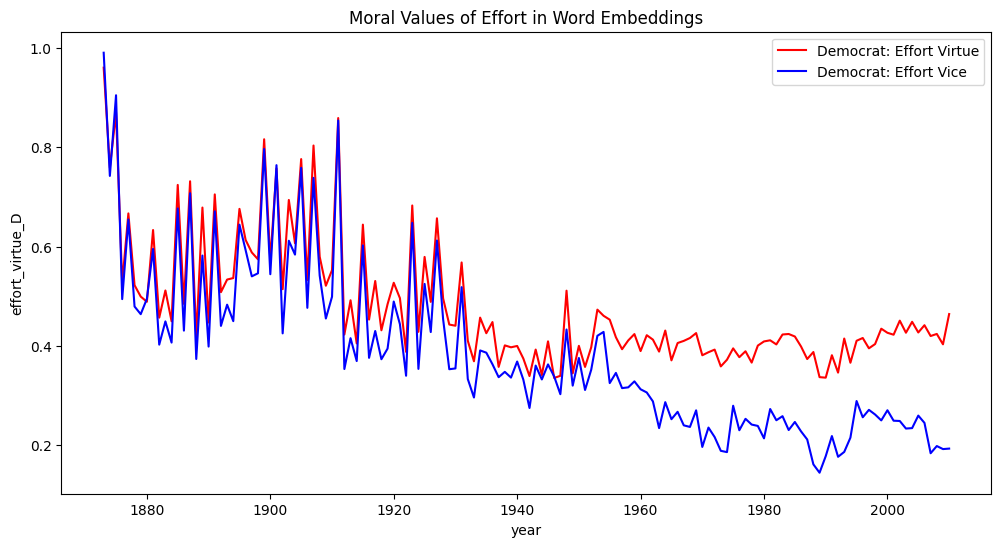

In [ ]:
# plot effort virtue and vice for democrat
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfbias, x='year', y='effort_virtue_D',color='red',label='Democrat: Effort Virtue')
sns.lineplot(data=dfbias, x='year', y='effort_vice_D', color='blue',label='Democrat: Effort Vice')
plt.title('Moral Values of Effort in Word Embeddings')
plt.show()


In [ ]:
dfbias.columns

Index(['year', 'effort_care_vic_R', 'efficiency_care_vic_R',
       'effort_care_vir_R', 'efficiency_care_vir_R', 'effort_loya_vic_R',
       'efficiency_loya_vic_R', 'effort_loya_vir_R', 'efficiency_loya_vir_R',
       'effort_auth_vic_R', 'efficiency_auth_vic_R', 'effort_auth_vir_R',
       'efficiency_auth_vir_R', 'effort_sanc_vic_R', 'efficiency_sanc_vic_R',
       'effort_sanc_vir_R', 'efficiency_sanc_vir_R', 'effort_fare_vic_R',
       'efficiency_fare_vic_R', 'effort_fare_vir_R', 'efficiency_fare_vir_R',
       'effort_care_R', 'effort_loya_R', 'effort_auth_R', 'effort_sanc_R',
       'effort_fare_R', 'effort_virtue_R', 'effort_vice_R',
       'effort_vir_vic_diff_R', 'efficiency_care_R', 'efficiency_loya_R',
       'efficiency_auth_R', 'efficiency_sanc_R', 'efficiency_fare_R',
       'efficiency_virtue_R', 'efficiency_vice_R', 'efficiency_vir_vic_diff_R',
       'effort_care_vic_D', 'efficiency_care_vic_D', 'effort_care_vir_D',
       'efficiency_care_vir_D', 'effort_loya_vic_D

## correlation test

In [ ]:
# test correlation between effort_vir_vic_diff_R and effort_vir_vic_diff_D
import scipy.stats as stats
from scipy.stats import pearsonr

stat, p = pearsonr(dfbias['effort_vir_vic_diff_R'], dfbias['effort_vir_vic_diff_D'])
print(f"Correlatio of effort: {stat}, p-value: {p}")
# efficiency, deal with NaN
dfbias_complete = dfbias.dropna()
stat, p = pearsonr(dfbias_complete['efficiency_vir_vic_diff_R'], dfbias_complete['efficiency_vir_vic_diff_D'])
print(f"Correlatio of efficiency: {stat}, p-value: {p}")

dfbias['ineffcient_effort_R'] = dfbias['effort_vir_vic_diff_R'] - dfbias['efficiency_vir_vic_diff_R']
dfbias['ineffcient_effort_D'] = dfbias['effort_vir_vic_diff_D'] - dfbias['efficiency_vir_vic_diff_D']
# inefficient effort, deal with NaN
dfbias = dfbias.dropna()
stat, p = pearsonr(dfbias['ineffcient_effort_R'], dfbias['ineffcient_effort_D'])
print(f"Correlatio of inefficient effort: {stat}, p-value: {p}")

Correlatio of effort: 0.8641976876514585, p-value: 6.77324452734925e-47
Correlatio of efficiency: 0.7233387703230272, p-value: 6.68628247507122e-26
Correlatio of inefficient effort: 0.6471761862036249, p-value: 2.0922559407280308e-19


## ARIMA test

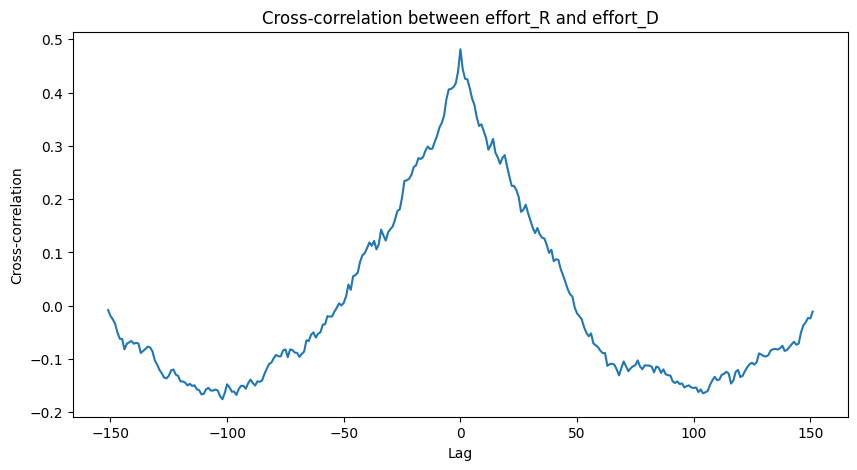

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute cross-correlation
cross_corr = np.correlate(dfbias['effort_vir_vic_diff_R'] - np.mean(dfbias['effort_vir_vic_diff_R']), dfbias['effort_vir_vic_diff_D'] - np.mean(dfbias['effort_vir_vic_diff_D']), mode='full')
lags = np.arange(-len(dfbias['effort_vir_vic_diff_D']) + 1, len(dfbias['effort_vir_vic_diff_D']))

# Plot cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(lags, cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between effort_R and effort_D')
plt.show()


In [ ]:
from pmdarima import auto_arima
from scipy.stats import pearsonr

# Extract the relevant columns
effort_R = dfbias['effort_vir_vic_diff_R']
effort_D = dfbias['effort_vir_vic_diff_D']
efficiency_R = dfbias['efficiency_vir_vic_diff_R']
efficiency_D = dfbias['efficiency_vir_vic_diff_D']
inefficient_effort_R = dfbias['ineffcient_effort_R']
inefficient_effort_D = dfbias['ineffcient_effort_D']

# fit ARIMA
model_effort_R = auto_arima(effort_R, seasonal=False)
model_effort_D = auto_arima(effort_D, seasonal=False)
model_efficiency_R = auto_arima(efficiency_R, seasonal=False)
model_efficiency_D = auto_arima(efficiency_D, seasonal=False)
model_inefficient_effort_R = auto_arima(inefficient_effort_R, seasonal=False)
model_inefficient_effort_D = auto_arima(inefficient_effort_D, seasonal=False)

# extract residuals
residuals_effort_R = model_effort_R.resid()
residuals_effort_D = model_effort_D.resid()
residuals_efficiency_R = model_efficiency_R.resid()
residuals_efficiency_D = model_efficiency_D.resid()
residuals_inefficient_effort_R = model_inefficient_effort_R.resid()
residuals_inefficient_effort_D = model_inefficient_effort_D.resid()

# compute pearson correlation
effort_corr, effort_p = pearsonr(residuals_effort_R, residuals_effort_D)
efficiency_corr, efficiency_p = pearsonr(residuals_efficiency_R, residuals_efficiency_D)
inefficient_effort_corr, inefficient_effort_p = pearsonr(residuals_inefficient_effort_R, residuals_inefficient_effort_D)

# Print the results
print(f"ARIMA residuals - Effort correlation: {effort_corr}, p-value: {effort_p}")
print(f"ARIMA residuals - Efficiency correlation: {efficiency_corr}, p-value: {efficiency_p}")
print(f"ARIMA residuals - Inefficient effort correlation: {inefficient_effort_corr}, p-value: {inefficient_effort_p}")


ARIMA residuals - Effort correlation: 0.3106437293299128, p-value: 9.817032362558202e-05
ARIMA residuals - Efficiency correlation: 0.45963844479144017, p-value: 2.5727469759815293e-09
ARIMA residuals - Inefficient effort correlation: 0.45846266494206245, p-value: 2.857563703857796e-09


### party government data
source: https://history.house.gov/Institution/Presidents-Coinciding/Party-Government/


In [ ]:
party_government = pd.read_csv(external_path+'party_government.csv')
party_government.columns

Index(['Congress', 'House Majority', 'Senate Majority', 'Presidency',
       'Party Government'],
      dtype='object')

In [ ]:
import pandas as pd
external_path = '../0_data/external/'
party_government = pd.read_csv(external_path+'party_government.csv')
# clean the footnote digits
col_to_clean = ['Congress', 'House Majority', 'Senate Majority', 'Presidency', 'Party Government']
for col in col_to_clean:
    party_government[col] = party_government[col].str.replace('\d+', '')

# transform Congress columns (cell format:35th (1857–1859)) into years and create a new dataframe with year as a row
party_government['start_year'], party_government['end_year'] = party_government['Congress'].str.extract(r'(\d{4})–(\d{4})').astype(int).T.values
# expand years
def expand_years(row):
    return pd.Series(range(row['start_year'], row['end_year']+1))
years = party_government.apply(expand_years, axis=1).stack().reset_index(level=1, drop=True).astype(int)
party_government_year = party_government.loc[years.index].copy()
party_government_year['year'] = years
party_government_year['Presidency_party'] = party_government_year['Presidency'].str.extract(r'(\w+)')
party_government_year = party_government_year.reset_index(drop=True)
party_government_year.to_csv(external_path+'party_government_year.csv', index=False)
party_government_year

Congress House Majority Senate Majority           Presidency  \
0     35th (1857–1859)      Democrats       Democrats  Democrat (Buchanan)   
1     35th (1857–1859)      Democrats       Democrats  Democrat (Buchanan)   
2     35th (1857–1859)      Democrats       Democrats  Democrat (Buchanan)   
3     36th (1859–1861)    Republicans       Democrats  Democrat (Buchanan)   
4     36th (1859–1861)    Republicans       Democrats  Democrat (Buchanan)   
..                 ...            ...             ...                  ...   
247  117th (2021–2023)      Democrats     Democrats14     Democrat (Biden)   
248  117th (2021–2023)      Democrats     Democrats14     Democrat (Biden)   
249  118th (2023–2025)    Republicans       Democrats     Democrat (Biden)   
250  118th (2023–2025)    Republicans       Democrats     Democrat (Biden)   
251  118th (2023–2025)    Republicans       Democrats     Democrat (Biden)   

    Party Government  start_year  end_year  year Presidency_party  
0            Unified        1857      1859  1857         Democrat  
1            Unified        1857      1859  1858         Democrat  
2            Unified        1857      1859  1859         Democrat  
3            Divided        1859      1861  1859         Democrat  
4            Divided        1859      1861  1860         Democrat  
..               ...         ...       ...   ...              ...  
247          Unified        2021      2023  2022         Democrat  
248          Unified        2021      2023  2023         Democrat  
249          Divided        2023      2025  2023         Democrat  
250          Divided        2023      2025  2024         Democrat  
251          Divided        2023      2025  2025         Democrat  

[252 rows x 9 columns]

# Difficulty as Improvement

In [ ]:
from extract_cosine_similarities import load_dict, load_word2vec_models, calculate_cosine_similarities, create_bias_dataframe
import pandas as pd
import statistics
import random
import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
import json
import nltk
# nltk.download('words')
from nltk.corpus import words
# # Get the current script directory and create paths to the data and output folders
script_dir = os.path.dirname('/home/local/PSYCH-ADS/xuqian_chen/Github/effort/1_code/test_function.ipynb')
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
pipeline_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/preprocessed')
tmp_folder_path =os.path.join(os.path.dirname(script_dir), '2_pipeline/tmp')
# # Models
# model_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/model'
# models = load_word2vec_models(model_folder_path)

# Targets
dict_path = os.path.join(data_folder_path, 'wordlist', 'dict_difficulty_improvement.json')
dict = load_dict(dict_path)
dict_path_chi = os.path.join(data_folder_path, 'wordlist', 'dict_difficulty_improvement_chi.json')
dict_chi = load_dict(dict_path_chi)

evaluations_set= {'Improvement': dict['Improvement'],'Impossibility': dict['Impossibility'],"Importance": dict['Importance']}
targets_set = {'Difficulty':dict['Difficulty']}
evaluations_chi_set = {'Improvement': dict_chi['Improvement'],'Impossibility': dict_chi['Impossibility'],"Importance": dict_chi['Importance']}
targets_chi_set = {'Difficulty':dict_chi['Difficulty']}
# Calculate cosine similarities
diff_improve_similarity = calculate_cosine_similarities(models,targets_set, evaluations_set)
dfus = create_bias_dataframe(diff_improve_similarity,targets_set, evaluations_set)
# save the dataframe to preprocessed folder
dfus.to_csv(os.path.join(pipeline_folder_path, 'bias_difficulty_improvement.csv'), index=False)

# Calculate cosine similarities
diff_improve_similarity_chi = calculate_cosine_similarities(models_chi,targets_chi_set, evaluations_chi_set)
dfchi = create_bias_dataframe(diff_improve_similarity_chi,targets_chi_set, evaluations_chi_set)
# save the dataframe to preprocessed folder
dfchi.to_csv(os.path.join(pipeline_folder_path, 'bias_difficulty_improvement_chi.csv'), index=False)

## load data and plot

In [ ]:
import pandas as pd
import os
script_dir = os.path.dirname('/home/local/PSYCH-ADS/xuqian_chen/Github/effort/1_code/test_function.ipynb')
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
pipeline_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/preprocessed')
dfdiff = pd.read_csv(os.path.join(pipeline_folder_path, 'bias_difficulty_improvement.csv'))
dfdiff_chi = pd.read_csv(os.path.join(pipeline_folder_path, 'bias_difficulty_improvement_chi.csv'))
# set year as integer
dfeffort = pd.read_csv('../2_pipeline/out/merged_us.csv')
dfeffort_chi = pd.read_csv('../2_pipeline/out/merged_chi.csv')
# merge by year
dfus = pd.merge(dfdiff, dfeffort, on='year', how='left')
dfchi = pd.merge(dfdiff_chi, dfeffort_chi, on='year', how='left')

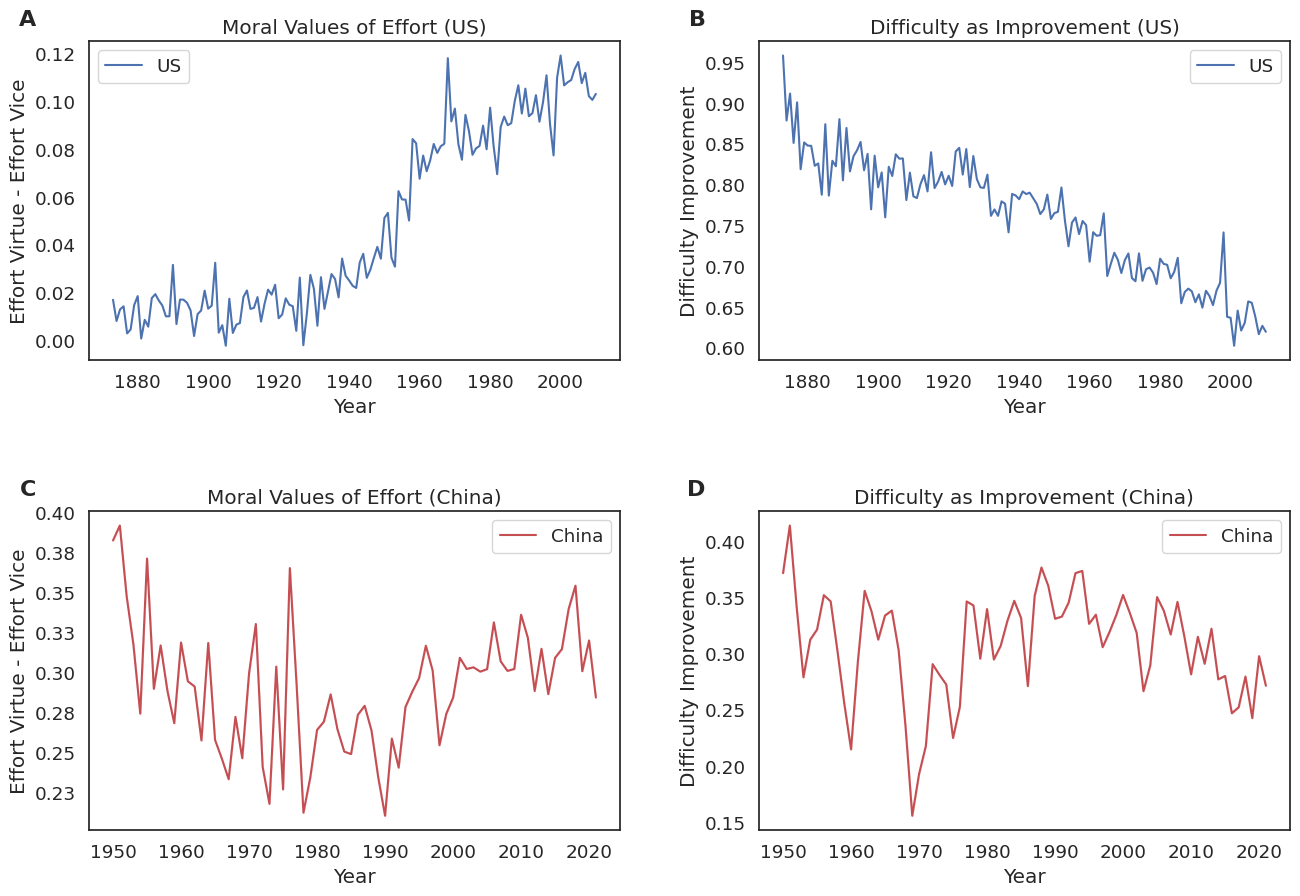

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


# Adjust plot settings
sns.set(style="white", font_scale=1.2)  # Increase font scale for better readability

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Adjusted for better fit

# Define the plots for US data
sns.lineplot(data=dfus, x='year', y='effort_vir_vic_diff', ax=axs[0, 0], color='b', label='US')
axs[0, 0].set_title('Moral Values of Effort (US)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Effort Virtue - Effort Vice')
axs[0, 0].text(-0.1, 1.1, 'A', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

sns.lineplot(data=dfus, x='year', y='Difficulty_Improvement', ax=axs[0,1], color='b', label='US')
axs[0, 1].set_title('Difficulty as Improvement (US)')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Difficulty Improvement')
axs[0, 1].text(-0.1, 1.1, 'B', transform=axs[0,1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Define the plots for China data
sns.lineplot(data=dfchi, x='year', y='effort_vir_vic_diff', ax=axs[1,0], color='r', label='China')
axs[1, 0].set_title('Moral Values of Effort (China)')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Effort Virtue - Effort Vice')
# make y ticks only 2 decimal
axs[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
axs[1, 0].text(-0.1, 1.1, 'C',  transform=axs[1,0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

sns.lineplot(data=dfchi, x='year', y='Difficulty_Improvement', ax=axs[1, 1], color='r', label='China')
axs[1, 1].set_title('Difficulty as Improvement (China)')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Difficulty Improvement')
axs[1, 1].text(-0.1, 1.1, 'D', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Improve layout
plt.tight_layout(pad=3.0)  # Add padding to prevent overlap
plt.show()


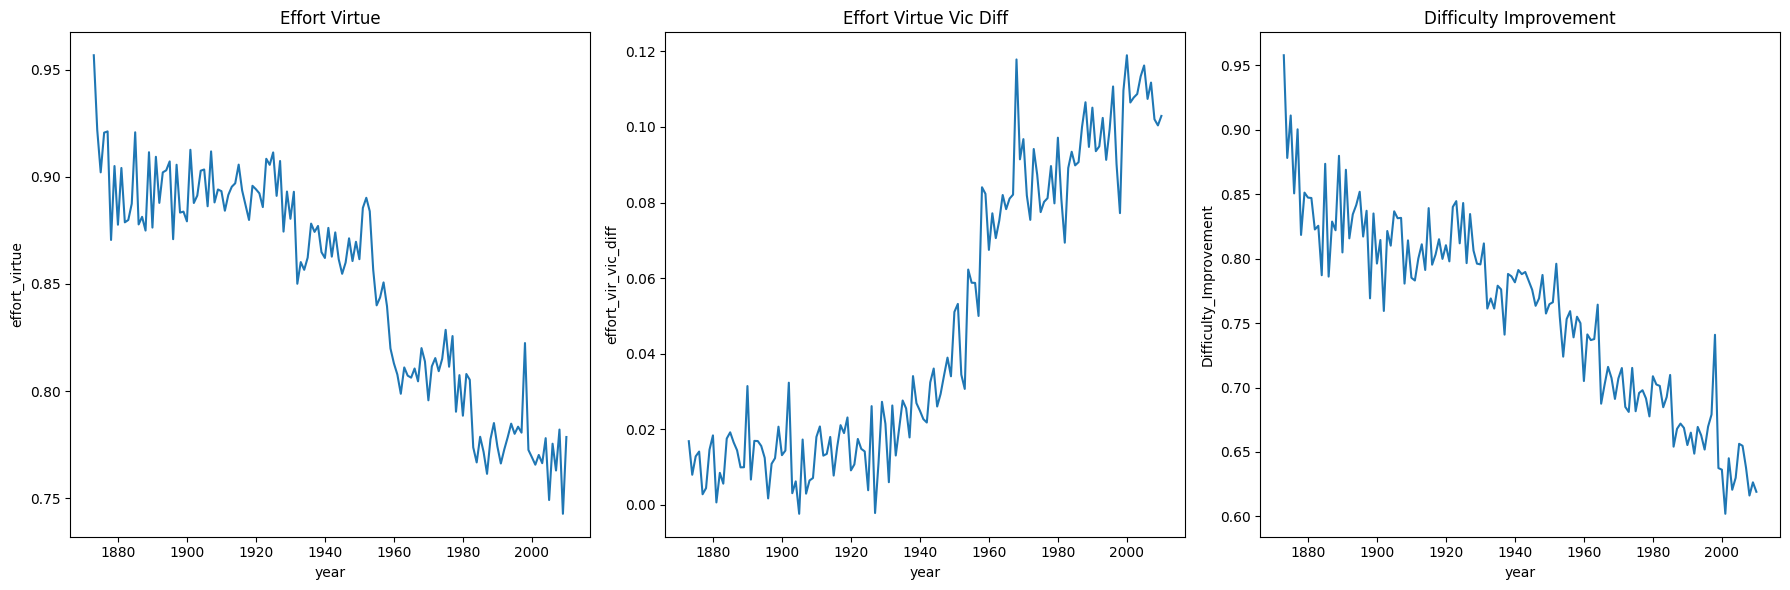

In [ ]:
# plot side by side of effort_virture, effort_vir_vic_diff and difficulty_improvement
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.lineplot(data=dfus, x='year', y='effort_virtue', ax=axs[0])
sns.lineplot(data=dfus, x='year', y='effort_vir_vic_diff', ax=axs[1])
sns.lineplot(data=dfus, x='year', y='Difficulty_Improvement', ax=axs[2])
axs[0].set_title('Effort Virtue')
axs[1].set_title('Effort Virtue Vic Diff')
axs[2].set_title('Difficulty Improvement')
plt.tight_layout()
plt.show()


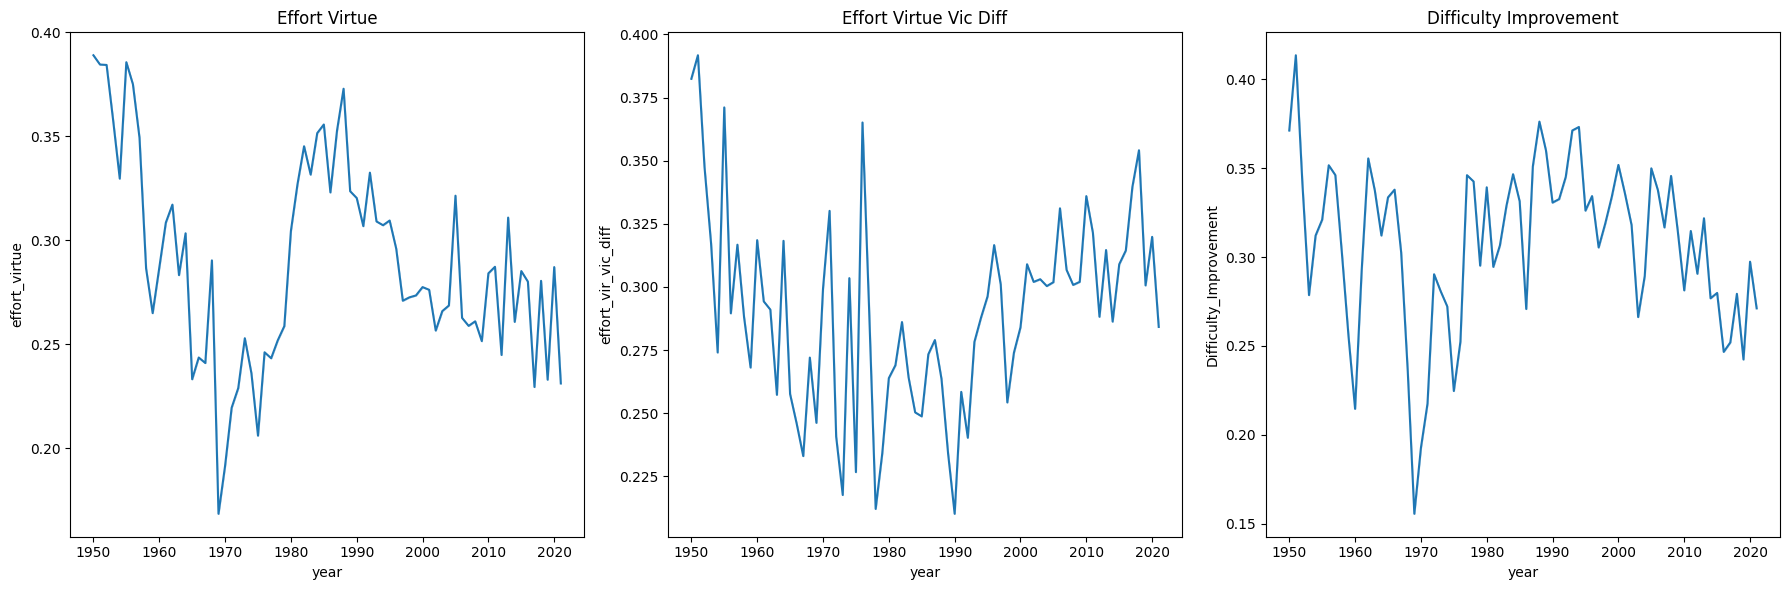

In [ ]:
# plot chi
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.lineplot(data=dfchi, x='year', y='effort_virtue', ax=axs[0])
sns.lineplot(data=dfchi, x='year', y='effort_vir_vic_diff', ax=axs[1])
sns.lineplot(data=dfchi, x='year', y='Difficulty_Improvement', ax=axs[2])
axs[0].set_title('Effort Virtue')
axs[1].set_title('Effort Virtue Vic Diff')
axs[2].set_title('Difficulty Improvement')
plt.tight_layout()
plt.show()


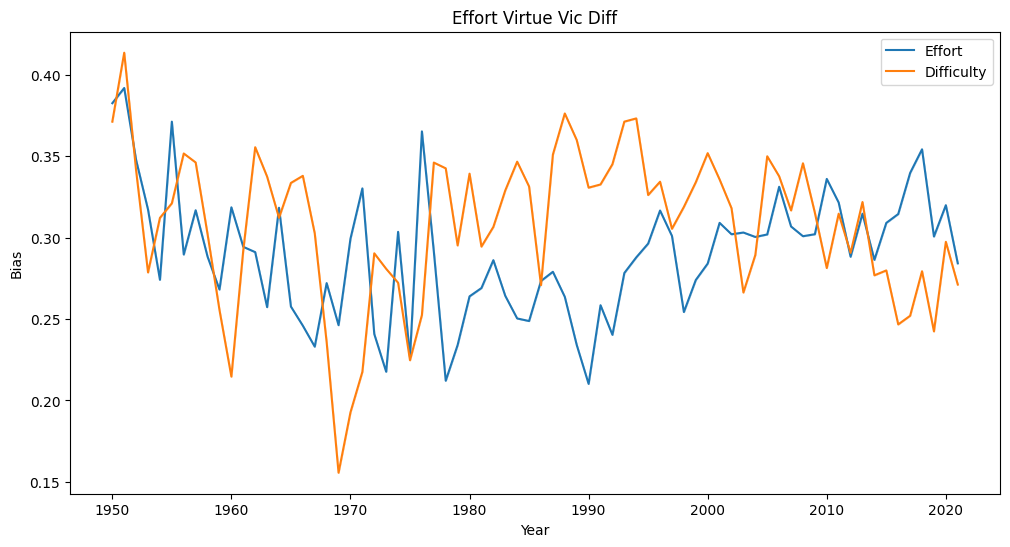

In [ ]:
# only one plot effort_vir_vice for chi
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfchi, x='year', y='effort_vir_vic_diff',label = 'Effort')
# add a line for difficulty
sns.lineplot(data=dfchi, x='year', y='Difficulty_Improvement',label = 'Difficulty')
plt.title('Effort Virtue Vic Diff')
plt.xlabel('Year')
plt.ylabel('Bias')
plt.show()

In [ ]:
# test correlation between effort_virtue and difficulty_improvement
import scipy.stats as stats
from scipy.stats import pearsonr
corr, p = pearsonr(dfus['effort_virtue'], dfus['Difficulty_Improvement'])
print(f'Correlation between effort_virtue and difficulty_improvement: {corr:.3f}, p-value: {p:.3f}')

# test correlation between effort_virtue_vic_diff and difficulty_improvement
corr, p = pearsonr(dfus['effort_vir_vic_diff'], dfus['Difficulty_Improvement'])
print(f'Correlation between effort_virtue_vic_diff and difficulty_improvement: {corr:.3f}, p-value: {p:.3f}')

Correlation between effort_virtue and difficulty_improvement: 0.940, p-value: 0.000
Correlation between effort_virtue_vic_diff and difficulty_improvement: -0.910, p-value: 0.000


In [ ]:
# test correlation between effort_virtue_vic_diff and difficulty_improvement in dfchin
corr, p = pearsonr(dfchi['effort_vir_vic_diff'], dfchi['Difficulty_Improvement'])
print(f'Correlation between effort_virtue_vic_diff and difficulty_improvement: {corr:.3f}, p-value: {p:.3f}')

# test correlation between effort_virtue and difficulty_improvement in dfchi
corr, p = pearsonr(dfchi['effort_virtue'], dfchi['Difficulty_Improvement'])
print(f'Correlation between effort_virtue and difficulty_improvement: {corr:.3f}, p-value: {p:.3f}')

Correlation between effort_virtue_vic_diff and difficulty_improvement: 0.007, p-value: 0.803
Correlation between effort_virtue and difficulty_improvement: 0.630, p-value: 0.000


In [ ]:
# test ARIMA
from pmdarima import auto_arima
from scipy.stats import pearsonr

# Extract the relevant columns
effort_virtue = dfus['effort_virtue']
effort_vir_vic_diff = dfus['effort_vir_vic_diff']
difficulty_improvement = dfus['Difficulty_Improvement']

# fit ARIMA
model_effort_virtue = auto_arima(effort_virtue, seasonal=False)
model_effort_vir_vic_diff = auto_arima(effort_vir_vic_diff, seasonal=False)
model_difficulty_improvement = auto_arima(difficulty_improvement, seasonal=False)

# extract residuals
residuals_effort_virtue = model_effort_virtue.resid()
residuals_effort_vir_vic_diff = model_effort_vir_vic_diff.resid()
residuals_difficulty_improvement = model_difficulty_improvement.resid()

# compute pearson correlation
effort_virtue_corr, effort_virtue_p = pearsonr(residuals_effort_virtue, residuals_difficulty_improvement)
effort_vir_vic_diff_corr, effort_vir_vic_diff_p = pearsonr(residuals_effort_vir_vic_diff, residuals_difficulty_improvement)
virtue_virvic_corr, virtue_virvic_p = pearsonr(residuals_effort_virtue, residuals_effort_vir_vic_diff)

# Print the results in 3 digits
print(f"ARIMA residuals - Effort Virtue correlation with Difficulty Improvement: {effort_virtue_corr:.3f}, p-value: {effort_virtue_p:.3f}")
print(f"ARIMA residuals - Effort Virtue Vic Diff correlation with Difficulty Improvement: {effort_vir_vic_diff_corr:.3f}, p-value: {effort_vir_vic_diff_p:.3f}")
print(f"ARIMA residuals - Effort Virtue correlation with Effort Virtue Vic Diff: {virtue_virvic_corr:.3f}, p-value: {virtue_virvic_p:.3f}")


ARIMA residuals - Effort Virtue correlation with Difficulty Improvement: 0.965, p-value: 0.000
ARIMA residuals - Effort Virtue Vic Diff correlation with Difficulty Improvement: 0.092, p-value: 0.285
ARIMA residuals - Effort Virtue correlation with Effort Virtue Vic Diff: 0.100, p-value: 0.241


In [ ]:
# test ARIMA for chi
from pmdarima import auto_arima
from scipy.stats import pearsonr

# Extract the relevant columns
effort_virtue = dfchi['effort_virtue']
effort_vir_vic_diff = dfchi['effort_vir_vic_diff']
difficulty_improvement = dfchi['Difficulty_Improvement']

# fit ARIMA
model_effort_virtue = auto_arima(effort_virtue, seasonal=False)
model_effort_vir_vic_diff = auto_arima(effort_vir_vic_diff, seasonal=False)
model_difficulty_improvement = auto_arima(difficulty_improvement, seasonal=False)

# extract residuals
residuals_effort_virtue = model_effort_virtue.resid()
residuals_effort_vir_vic_diff = model_effort_vir_vic_diff.resid()
residuals_difficulty_improvement = model_difficulty_improvement.resid()

# compute pearson correlation
effort_virtue_corr, effort_virtue_p = pearsonr(residuals_effort_virtue, residuals_difficulty_improvement)
effort_vir_vic_diff_corr, effort_vir_vic_diff_p = pearsonr(residuals_effort_vir_vic_diff, residuals_difficulty_improvement)
virtue_virvic_corr, virtue_virvic_p = pearsonr(residuals_effort_virtue, residuals_effort_vir_vic_diff)

# Print the results in 3 digits
print(f"ARIMA residuals - Effort Virtue correlation with Difficulty Improvement: {effort_virtue_corr:.3f}, p-value: {effort_virtue_p:.3f}")
print(f"ARIMA residuals - Effort Virtue Vic Diff correlation with Difficulty Improvement: {effort_vir_vic_diff_corr:.3f}, p-value: {effort_vir_vic_diff_p:.3f}")
print(f"ARIMA residuals - Effort Virtue correlation with Effort Virtue Vic Diff: {virtue_virvic_corr:.3f}, p-value: {virtue_virvic_p:.3f}")

ARIMA residuals - Effort Virtue correlation with Difficulty Improvement: 0.766, p-value: 0.000
ARIMA residuals - Effort Virtue Vic Diff correlation with Difficulty Improvement: 0.557, p-value: 0.000
ARIMA residuals - Effort Virtue correlation with Effort Virtue Vic Diff: 0.758, p-value: 0.000


# Data Scale

## count the tokens

In [ ]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Paths to directories
congress_path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/Congress/hein-bound_parsed'
peoples_daily_path = '/home/local/PSYCH-ADS/xuqian_chen/YES_lab/Amber/nlp/PeopleDaily/cleaned_sentences'

def count_tokens_in_txt(file_path):
    with open(file_path, 'r') as file:
        return sum(len(line.split()) for line in file)

def count_tokens_in_pkl(file_path):
    with open(file_path, 'rb') as file:
        sentences = pickle.load(file)
        return sum(len(sentence) for sentence in sentences)

# Dictionary to store token counts
token_counts_us = {'Year': [], 'token_counts': []}
token_counts_chi = {'Year': [], 'token_counts': []}

# Process Congress files
for year in range(1873, 2012):
    file_path = os.path.join(congress_path, f'cleaned_tokens_{year}.txt')
    if os.path.exists(file_path):
        token_counts_us['Year'].append(year)
        token_counts_us['token_counts'].append(count_tokens_in_txt(file_path))
    else:
        token_counts_us['Year'].append(year)
        token_counts_us['token_counts'].append(0)

# Process People's Daily files
for year in range(1950, 2023):
    file_path = os.path.join(peoples_daily_path, f'cleaned_{year}.pkl')

    if os.path.exists(file_path):
        token_counts_chi['Year'].append(year)
        token_counts_chi['token_counts'].append(count_tokens_in_pkl(file_path))
    else:
        token_counts_chi['Year'].append(year)
        token_counts_chi['token_counts'].append(0)



# Convert to DataFrame
df_token_counts_us = pd.DataFrame(token_counts_us)
df_token_counts_chi = pd.DataFrame(token_counts_chi)
# delete the rows if token_counts is 0
df_token_counts_us = df_token_counts_us[df_token_counts_us['token_counts'] != 0]
df_token_counts_chi = df_token_counts_chi[df_token_counts_chi['token_counts'] != 0]

# save
df_token_counts_us.to_csv('../2_pipeline/out/token_counts_us.csv', index=False)
df_token_counts_chi.to_csv('../2_pipeline/out/token_counts_chi.csv', index=False)

## plot and descriptve data

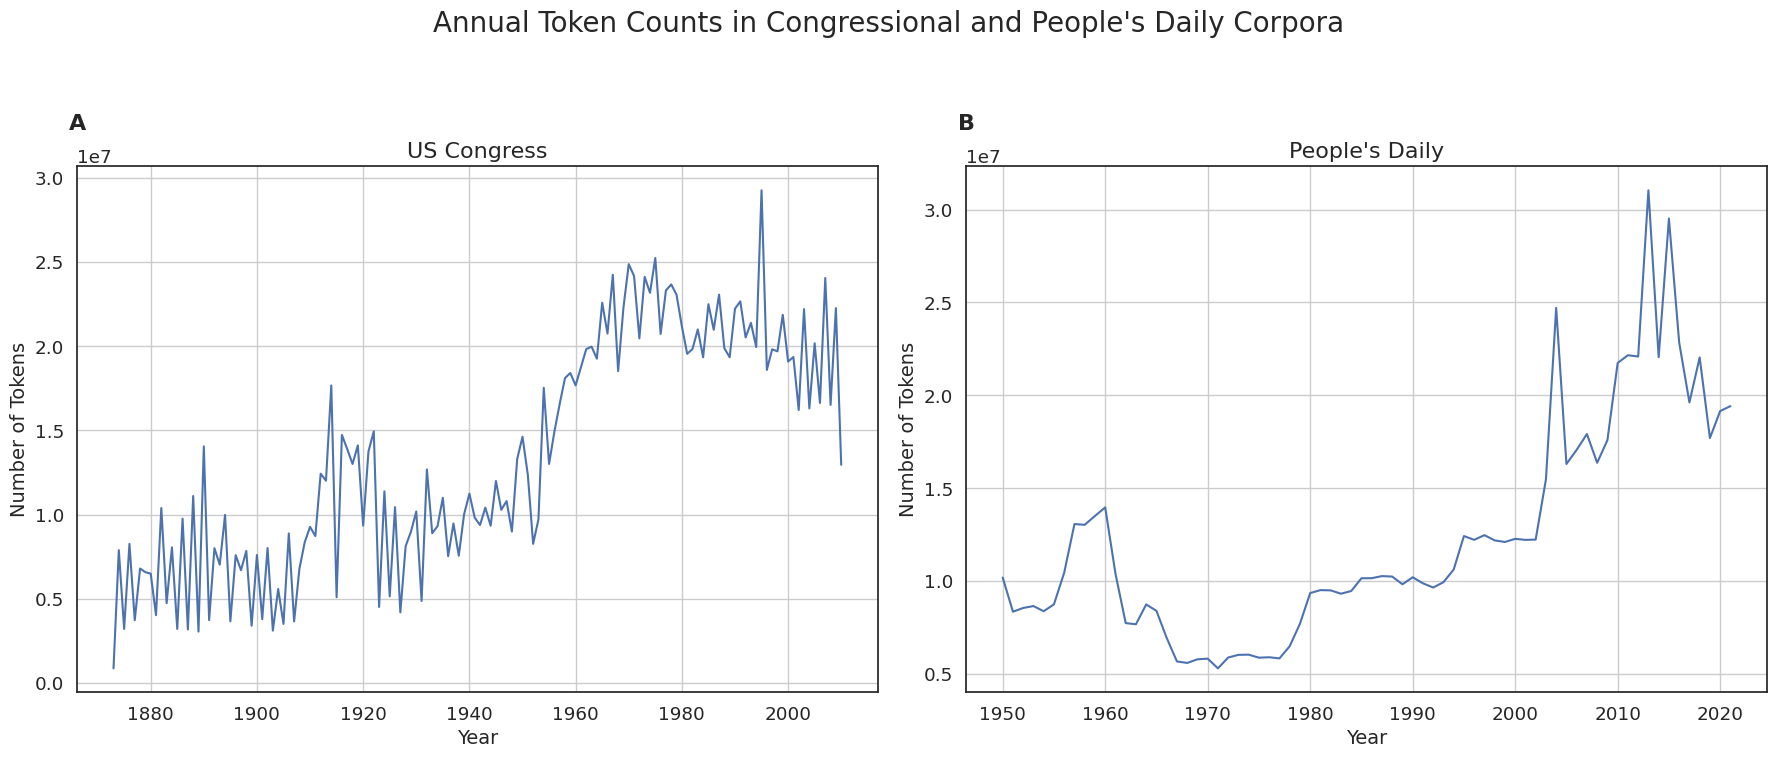

Descriptive Statistics for US Token Counts:
Mean: 13,402,205
Median: 12,392,612
Standard Deviation: 6,774,128

Descriptive Statistics for China Token Counts:
Mean: 12,295,981
Median: 10,216,760
Standard Deviation: 5,922,110


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the token counts
df_token_counts_us = pd.read_csv('../2_pipeline/out/token_counts_us.csv')
df_token_counts_chi = pd.read_csv('../2_pipeline/out/token_counts_chi.csv')


# Setting plot style and size
plt.figure(figsize=(18, 8), facecolor='white')
plt.suptitle('Annual Token Counts in Congressional and People\'s Daily Corpora', fontsize=20)

# Plot for US corpus
ax1 = plt.subplot(1, 2, 1)
ax1.plot(df_token_counts_us['Year'], df_token_counts_us['token_counts'], label='US Congress')
ax1.set_title('US Congress', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Tokens', fontsize=14)

ax1.grid(True)
# Adding label 'A' in the upper left corner
ax1.text(-0.01, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

# Plot for China corpus
ax2 = plt.subplot(1, 2, 2)
ax2.plot(df_token_counts_chi['Year'], df_token_counts_chi['token_counts'], label='People\'s Daily')
ax2.set_title('People\'s Daily', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Tokens', fontsize=14)

ax2.grid(True)
# Adding label 'B' in the upper left corner
ax2.text(-0.01, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')

# Adjust layout to make space for the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Print descriptive statistics for both US and China
print("Descriptive Statistics for US Token Counts:")
print(f"Mean: {df_token_counts_us['token_counts'].mean():,.0f}")
print(f"Median: {df_token_counts_us['token_counts'].median():,.0f}")
print(f"Standard Deviation: {df_token_counts_us['token_counts'].std():,.0f}\n")

print("Descriptive Statistics for China Token Counts:")
print(f"Mean: {df_token_counts_chi['token_counts'].mean():,.0f}")
print(f"Median: {df_token_counts_chi['token_counts'].median():,.0f}")
print(f"Standard Deviation: {df_token_counts_chi['token_counts'].std():,.0f}")


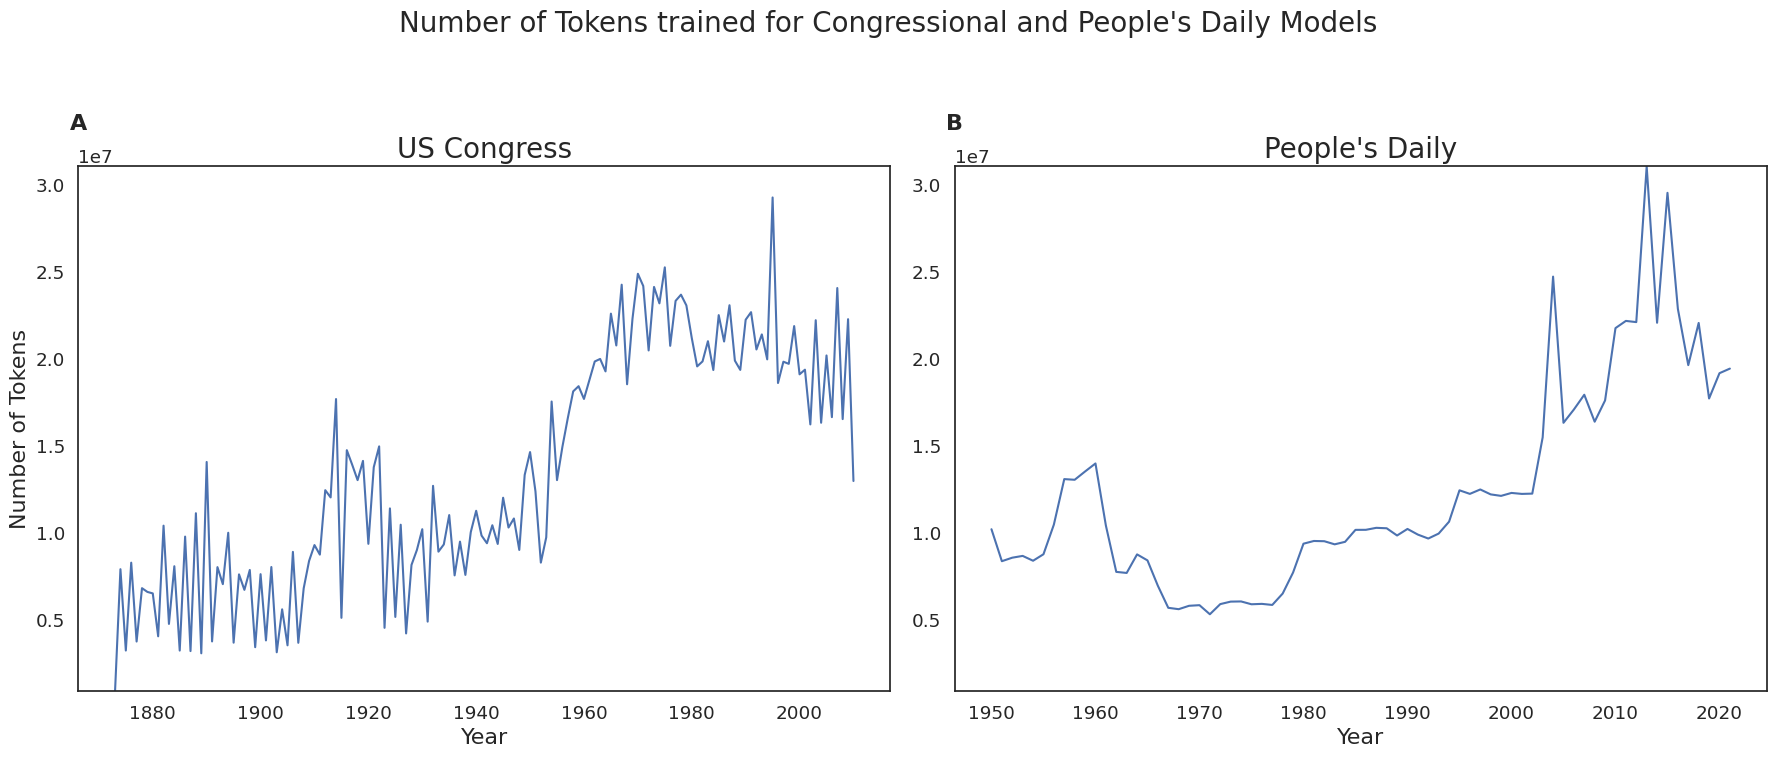

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Setting plot style and size
plt.figure(figsize=(18, 8), facecolor='white')
plt.suptitle('Number of Tokens trained for Congressional and People\'s Daily Models', fontsize=20)

# Finding the global min and max for a unified y-axis
global_min = min(df_token_counts_us['token_counts'].min(), df_token_counts_chi['token_counts'].min())
global_max = max(df_token_counts_us['token_counts'].max(), df_token_counts_chi['token_counts'].max())

# Plot for US corpus
ax1 = plt.subplot(1, 2, 1)
ax1.plot(df_token_counts_us['Year'], df_token_counts_us['token_counts'], label='US Congress')
ax1.set_title('US Congress', fontsize=20)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Number of Tokens', fontsize=16)
ax1.set_ylim(global_min, global_max)  # Set y-axis limits

# Adding label 'A' in the upper left corner
ax1.text(-0.01, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

# Plot for China corpus
ax2 = plt.subplot(1, 2, 2, sharey=ax1)  # Share y-axis with ax1
ax2.plot(df_token_counts_chi['Year'], df_token_counts_chi['token_counts'], label='People\'s Daily')
ax2.set_title('People\'s Daily', fontsize=20)
ax2.set_xlabel('Year', fontsize=16)


# Adding label 'B' in the upper left corner
ax2.text(-0.01, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')

# Adjust layout to make space for the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [ ]:

# Print descriptive statistics for both US and China
print("Descriptive Statistics for US Token Counts:")
print(f"Mean: {df_token_counts_us['token_counts'].mean():,.0f}")
print(f"Median: {df_token_counts_us['token_counts'].median():,.0f}")
print(f"Standard Deviation: {df_token_counts_us['token_counts'].std():,.0f}")
print(f"Minimum: {df_token_counts_us['token_counts'].min():,.0f}")
print(f"Maximum: {df_token_counts_us['token_counts'].max():,.0f}\n")

print("Descriptive Statistics for China Token Counts:")
print(f"Mean: {df_token_counts_chi['token_counts'].mean():,.0f}")
print(f"Median: {df_token_counts_chi['token_counts'].median():,.0f}")
print(f"Standard Deviation: {df_token_counts_chi['token_counts'].std():,.0f}")
print(f"Minimum: {df_token_counts_chi['token_counts'].min():,.0f}")
print(f"Maximum: {df_token_counts_chi['token_counts'].max():,.0f}")


Descriptive Statistics for US Token Counts:
Mean: 13,402,205
Median: 12,392,612
Standard Deviation: 6,774,128
Minimum: 867,210
Maximum: 29,252,016

Descriptive Statistics for China Token Counts:
Mean: 12,295,981
Median: 10,216,760
Standard Deviation: 5,922,110
Minimum: 5,292,965
Maximum: 31,038,064


# inter-rater reliability

In [ ]:
import pandas as pd

# Load the Excel file
file_path = os.path.join(data_folder_path,'wordlist' ,'Development of Effort Dictionaries.xlsx')

# Read data from each sheet
df_effort_eng = pd.read_excel(file_path, sheet_name='Effort_Eng')
df_efficiency_eng = pd.read_excel(file_path, sheet_name='Efficiency_Eng')
df_effort_chi = pd.read_excel(file_path, sheet_name='Effort_Chi',skiprows=3)
df_efficiency_chi = pd.read_excel(file_path, sheet_name='Efficiency_Chi',skiprows=3)
# delete the rows index more than 50
df_efficiency_chi = df_efficiency_chi[df_efficiency_chi.index < 50]
df_effort_chi = df_effort_chi[df_effort_chi.index < 50]
# change Rater2in index 11, 12,13 to 4 in df_efficiency_chi
df_efficiency_chi.loc[11:13, 'Rater2'] = 4
# # only keep rows where Words in the targets dictionary
# df_effort_eng = df_effort_eng[df_effort_eng['Word'].isin(targets['effort'])]
# df_efficiency_eng = df_efficiency_eng[df_efficiency_eng['Word'].isin(targets['efficiency'])]
# df_effort_chi = df_effort_chi[df_effort_chi['Word'].isin(targets_chi['effort'])]
# df_efficiency_chi = df_efficiency_chi[df_efficiency_chi['Word'].isin(targets_chi['efficiency'])]

import pingouin as pg

def calculate_icc(dataframe, rater1_col, rater2_col):
    # Ensure the ratings are numeric and filter out invalid rows
    valid_data = dataframe[[rater1_col, rater2_col]].dropna()
    valid_data[rater1_col] = pd.to_numeric(valid_data[rater1_col], errors='coerce')
    valid_data[rater2_col] = pd.to_numeric(valid_data[rater2_col], errors='coerce')
    
    if valid_data.empty:
        print("No valid data to compute ICC.")
        return None
    
    # Reshape data for ICC calculation: Pingouin expects wide format
    valid_data['ID'] = range(len(valid_data))
    data_long = pd.melt(valid_data, id_vars='ID', value_vars=[rater1_col, rater2_col])
    
    # Calculate ICC
    icc_results = pg.intraclass_corr(data=data_long, targets='ID', raters='variable', ratings='value',nan_policy='omit').round(3)
    # Select the appropriate type of ICC based on your study design:
    # - 'ICC1': Each target is rated by a different rater (random raters)
    # - 'ICC2', 'ICC3': Each target is rated by the same raters (fixed raters), and so on.
    icc_value = icc_results[icc_results['Type'] == 'ICC2']['ICC'].iloc[0]
    return icc_value

# Example usage with your data
# Assuming df_effort_eng, df_efficiency_eng, df_effort_chi, df_efficiency_chi are loaded properly
icc_effort_eng = calculate_icc(df_effort_eng, 'Rater3', 'Rater4')
icc_efficiency_eng = calculate_icc(df_efficiency_eng, 'Rater3', 'Rater4')
icc_effort_chi = calculate_icc(df_effort_chi, 'Rater1', 'Rater2')
icc_efficiency_chi = calculate_icc(df_efficiency_chi, 'Rater1', 'Rater2')

print("ICC for Effort (Eng):", icc_effort_eng)
print("ICC for Efficiency (Eng):", icc_efficiency_eng)
print("ICC for Effort (Chi):", icc_effort_chi)
print("ICC for Efficiency (Chi):", icc_efficiency_chi)



ICC for Effort (Eng): 0.875
ICC for Efficiency (Eng): 0.674
ICC for Effort (Chi): 0.763
ICC for Efficiency (Chi): 0.507


# Bayesian Change Point Detection Plots

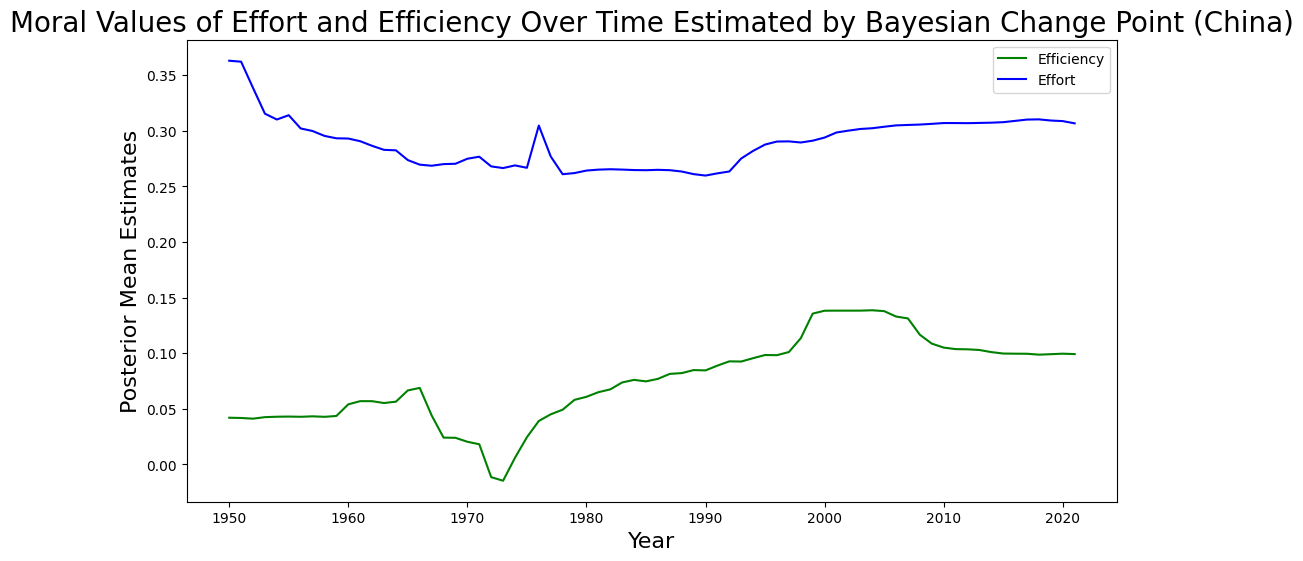

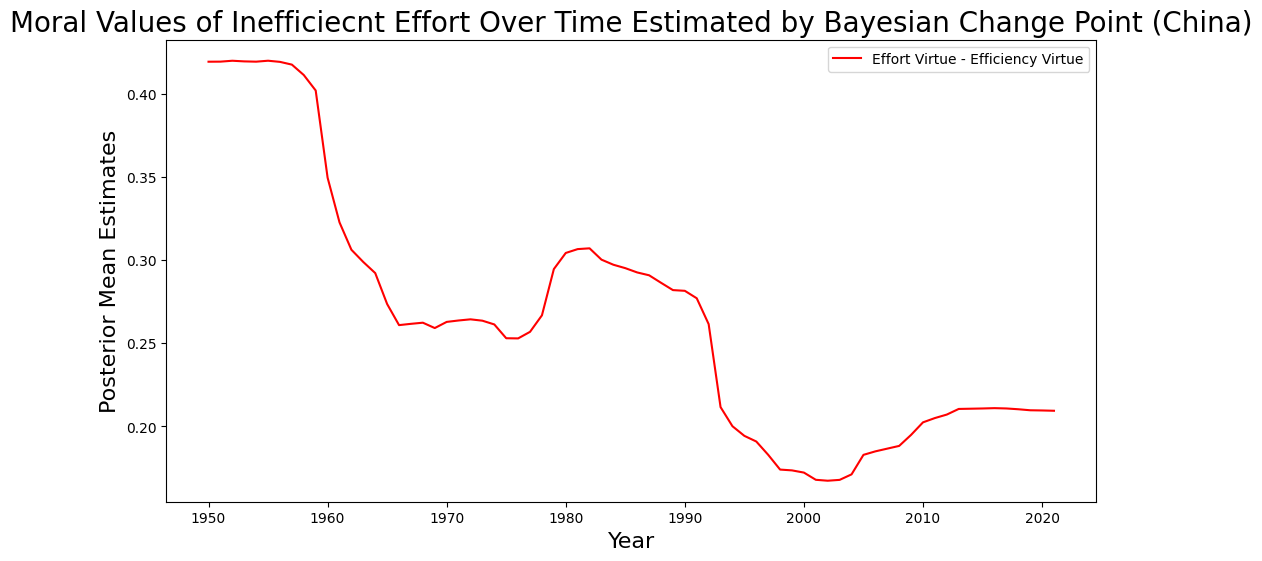

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
folder_path = os.path.join(output_folder_path, 'results','bcp/')
chi_efficiency = pd.read_csv(f'{folder_path}chi_efficiency.csv').sort_values('Year')
chi_effort = pd.read_csv(f'{folder_path}chi_effort.csv').sort_values('Year')
chi_effort_efficiency_virtue = pd.read_csv(f'{folder_path}chi_effort_efficiency_virtue.csv').sort_values('Year')
us_efficiency = pd.read_csv(f'{folder_path}efficiency_us.csv').sort_values('Year')
us_effort = pd.read_csv(f'{folder_path}effort_us.csv').sort_values('Year')
us_effort_efficiency_virtue = pd.read_csv(f'{folder_path}us_effort_efficiency_virtue.csv').sort_values('Year')
# Plot efficiency and effort means in one plot
plt.figure(figsize=(12, 6))
plt.plot(chi_efficiency['Year'], chi_efficiency['Means'], label='Efficiency', color='green')
plt.plot(chi_effort['Year'], chi_effort['Means'], label='Effort', color='blue')
plt.title('Moral Values of Effort and Efficiency Over Time Estimated by Bayesian Change Point (China)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Posterior Mean Estimates', fontsize=16)
plt.legend()

plt.show()

# Plot effort and efficiency virtue mean
plt.figure(figsize=(12, 6))
plt.plot(chi_effort_efficiency_virtue['Year'], chi_effort_efficiency_virtue['Means'], label='Effort Virtue - Efficiency Virtue', color='red')
plt.title('Moral Values of Inefficiecnt Effort Over Time Estimated by Bayesian Change Point (China)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Posterior Mean Estimates', fontsize=16)
plt.legend()

plt.show()

# You can add the plotting code for US data similarly by loading respective CSV files


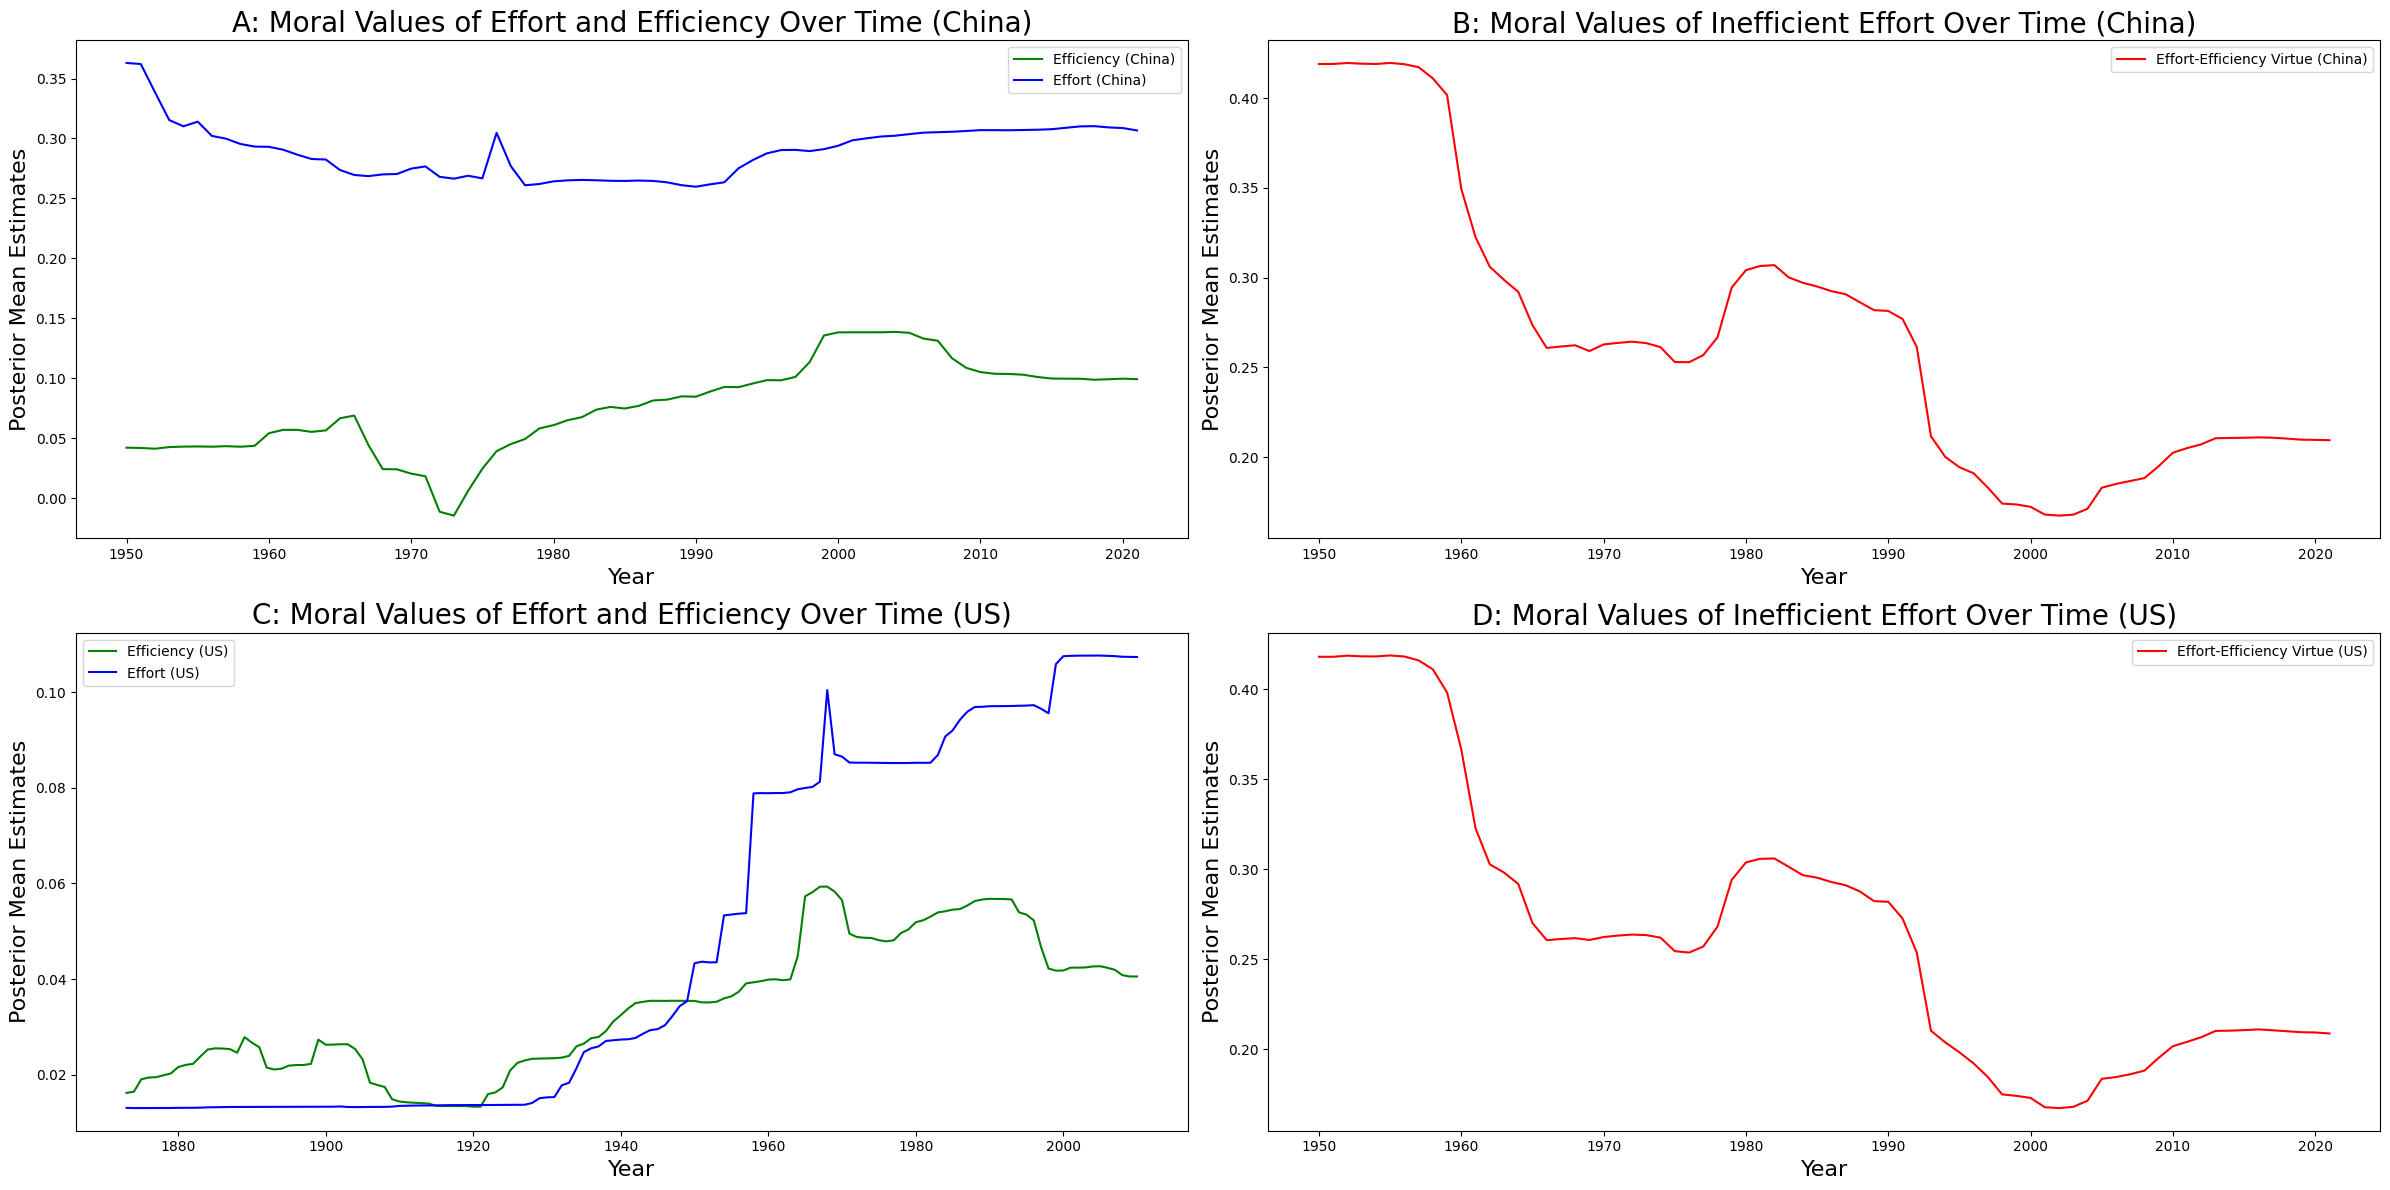

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# US data
us_efficiency = pd.read_csv(f'{folder_path}efficiency_us.csv').sort_values('Year')
us_effort = pd.read_csv(f'{folder_path}effort_us.csv').sort_values('Year')
us_effort_efficiency_virtue = pd.read_csv(f'{folder_path}effort_efficiency_virtue.csv').sort_values('Year')

# Setup the plot
fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Plot for China
axs[0, 0].plot(chi_efficiency['Year'], chi_efficiency['Means'], label='Efficiency (China)', color='green')
axs[0, 0].plot(chi_effort['Year'], chi_effort['Means'], label='Effort (China)', color='blue')
axs[0, 0].set_title('A: Moral Values of Effort and Efficiency Over Time (China)', fontsize=20)
axs[0, 0].set_xlabel('Year', fontsize=16)
axs[0, 0].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[0, 0].legend()

axs[0, 1].plot(chi_effort_efficiency_virtue['Year'], chi_effort_efficiency_virtue['Means'], label='Effort-Efficiency Virtue (China)', color='red')
axs[0, 1].set_title('B: Moral Values of Inefficient Effort Over Time (China)', fontsize=20)
axs[0, 1].set_xlabel('Year', fontsize=16)
axs[0, 1].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[0, 1].legend()

# Plot for US
axs[1, 0].plot(us_efficiency['Year'], us_efficiency['Means'], label='Efficiency (US)', color='green')
axs[1, 0].plot(us_effort['Year'], us_effort['Means'], label='Effort (US)', color='blue')
axs[1, 0].set_title('C: Moral Values of Effort and Efficiency Over Time (US)', fontsize=20)
axs[1, 0].set_xlabel('Year', fontsize=16)
axs[1, 0].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[1, 0].legend()

axs[1, 1].plot(us_effort_efficiency_virtue['Year'], us_effort_efficiency_virtue['Means'], label='Effort-Efficiency Virtue (US)', color='red')
axs[1, 1].set_title('D: Moral Values of Inefficient Effort Over Time (US)', fontsize=20)
axs[1, 1].set_xlabel('Year', fontsize=16)
axs[1, 1].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


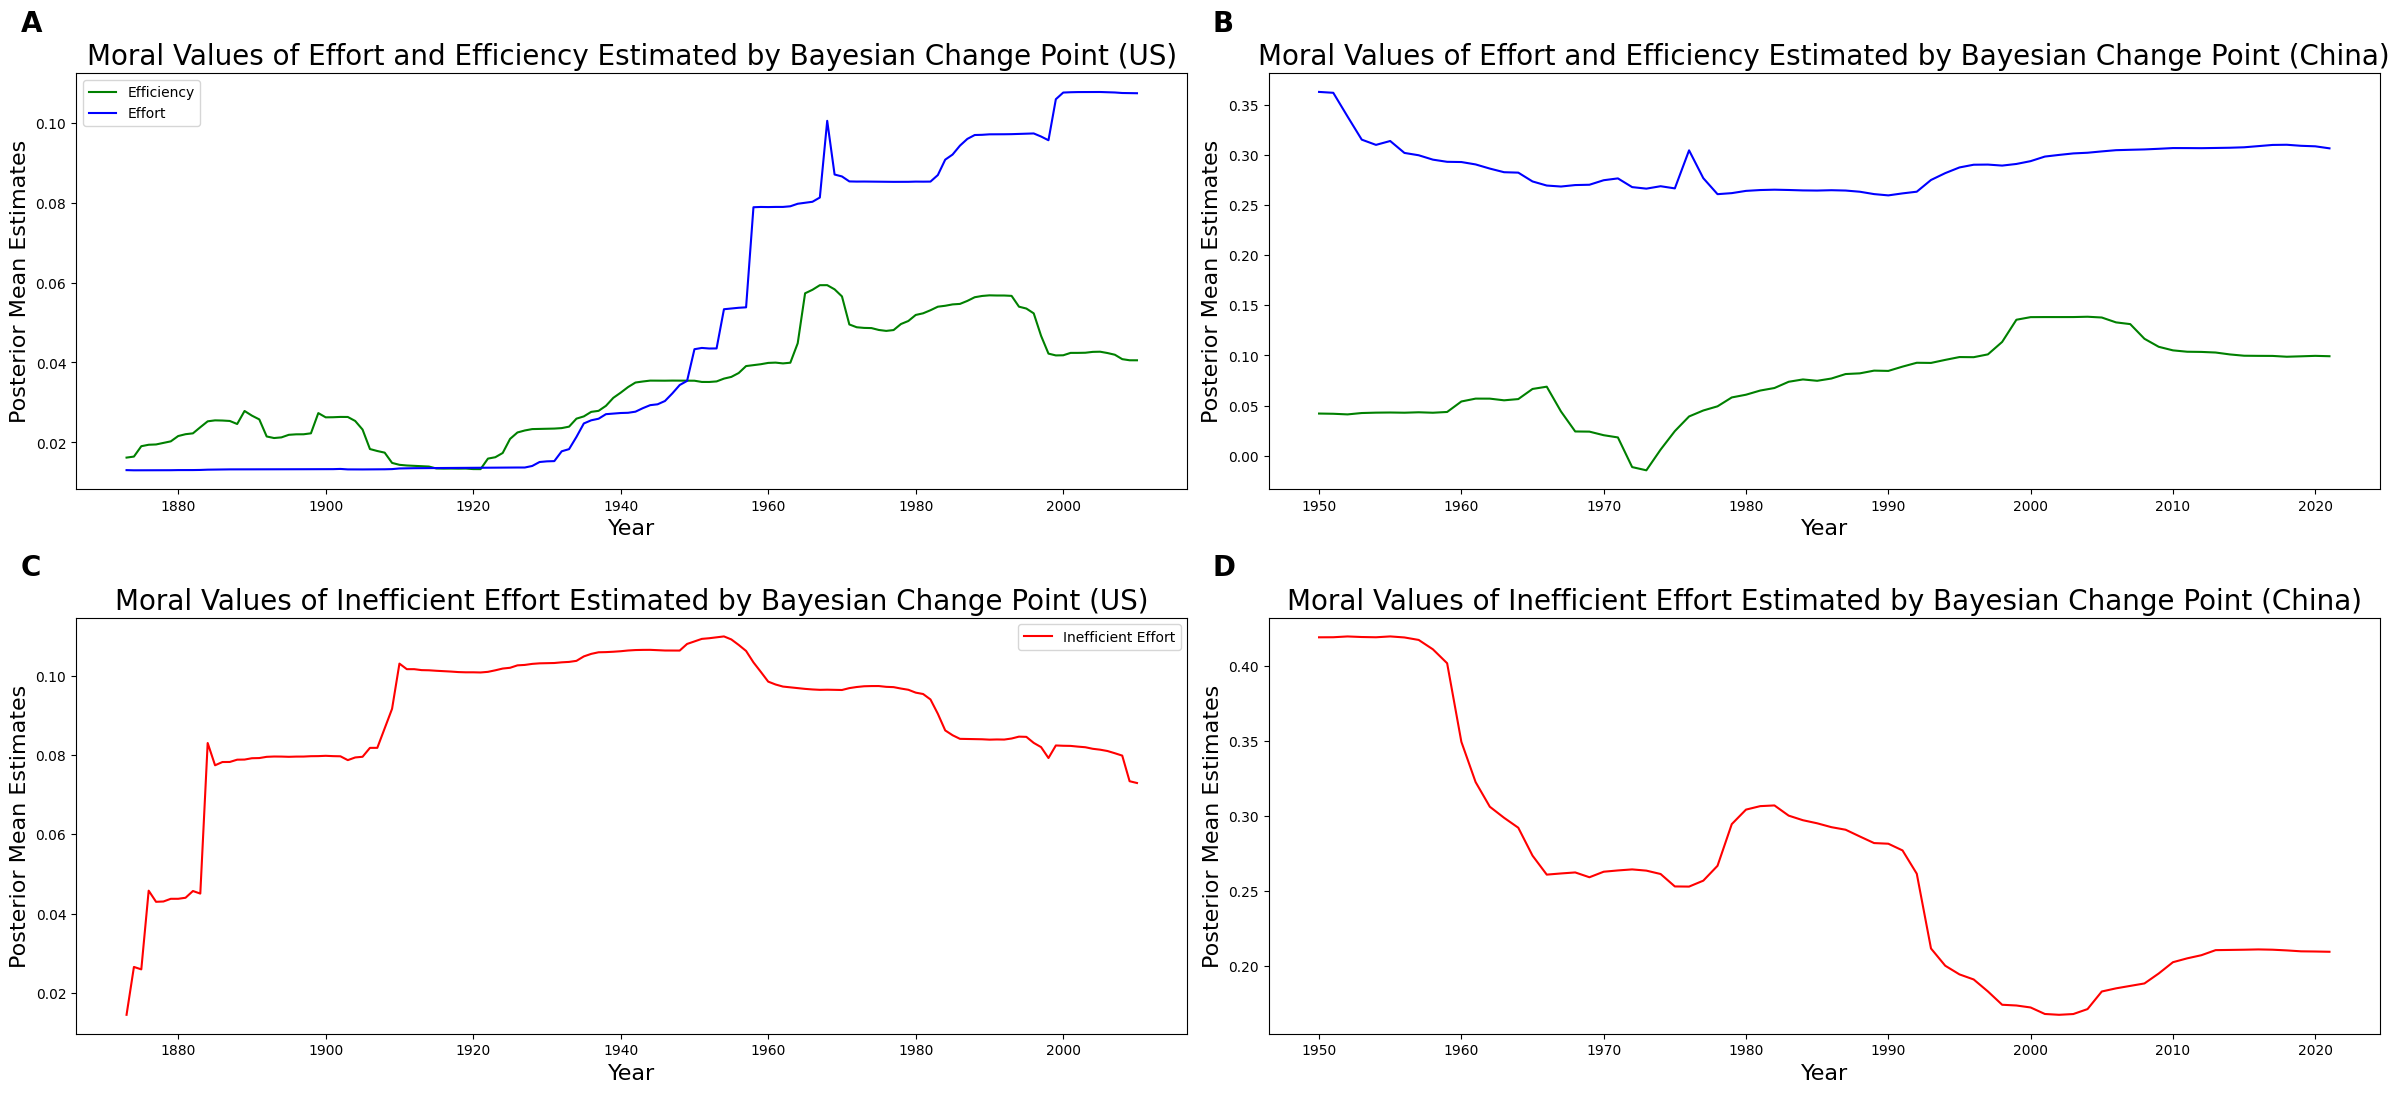

In [ ]:
import matplotlib.pyplot as plt

# Assuming the data is already loaded and sorted
# Define where each set of data is plotted
subplot_label_positions = (-0.05, 1.1)  # Position for subplot labels

# Setup the plot
fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Plot for US
axs[0, 0].plot(us_efficiency['Year'], us_efficiency['Means'], label='Efficiency', color='green')
axs[0, 0].plot(us_effort['Year'], us_effort['Means'], label='Effort', color='blue')
axs[0, 0].set_title('Moral Values of Effort and Efficiency Estimated by Bayesian Change Point (US)', fontsize=20)
axs[0, 0].set_xlabel('Year', fontsize=16)
axs[0, 0].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[0, 0].legend()
axs[0, 0].annotate('A', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

axs[1, 0].plot(us_effort_efficiency_virtue['Year'], us_effort_efficiency_virtue['Means'], label='Inefficient Effort', color='red')
axs[1, 0].set_title('Moral Values of Inefficient Effort Estimated by Bayesian Change Point (US)', fontsize=20)
axs[1, 0].set_xlabel('Year', fontsize=16)
axs[1, 0].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[1, 0].legend()
axs[1, 0].annotate('C', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

# Plot for China
axs[0, 1].plot(chi_efficiency['Year'], chi_efficiency['Means'], label='Efficiency', color='green')
axs[0, 1].plot(chi_effort['Year'], chi_effort['Means'], label='Effort', color='blue')
axs[0, 1].set_title('Moral Values of Effort and Efficiency Estimated by Bayesian Change Point (China)', fontsize=20)
axs[0, 1].set_xlabel('Year', fontsize=16)
axs[0, 1].set_ylabel('Posterior Mean Estimates', fontsize=16)

axs[0, 1].annotate('B', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

axs[1, 1].plot(chi_effort_efficiency_virtue['Year'], chi_effort_efficiency_virtue['Means'], color='red')
axs[1, 1].set_title('Moral Values of Inefficient Effort Estimated by Bayesian Change Point (China)', fontsize=20)
axs[1, 1].set_xlabel('Year', fontsize=16)
axs[1, 1].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[1, 1].annotate('D', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


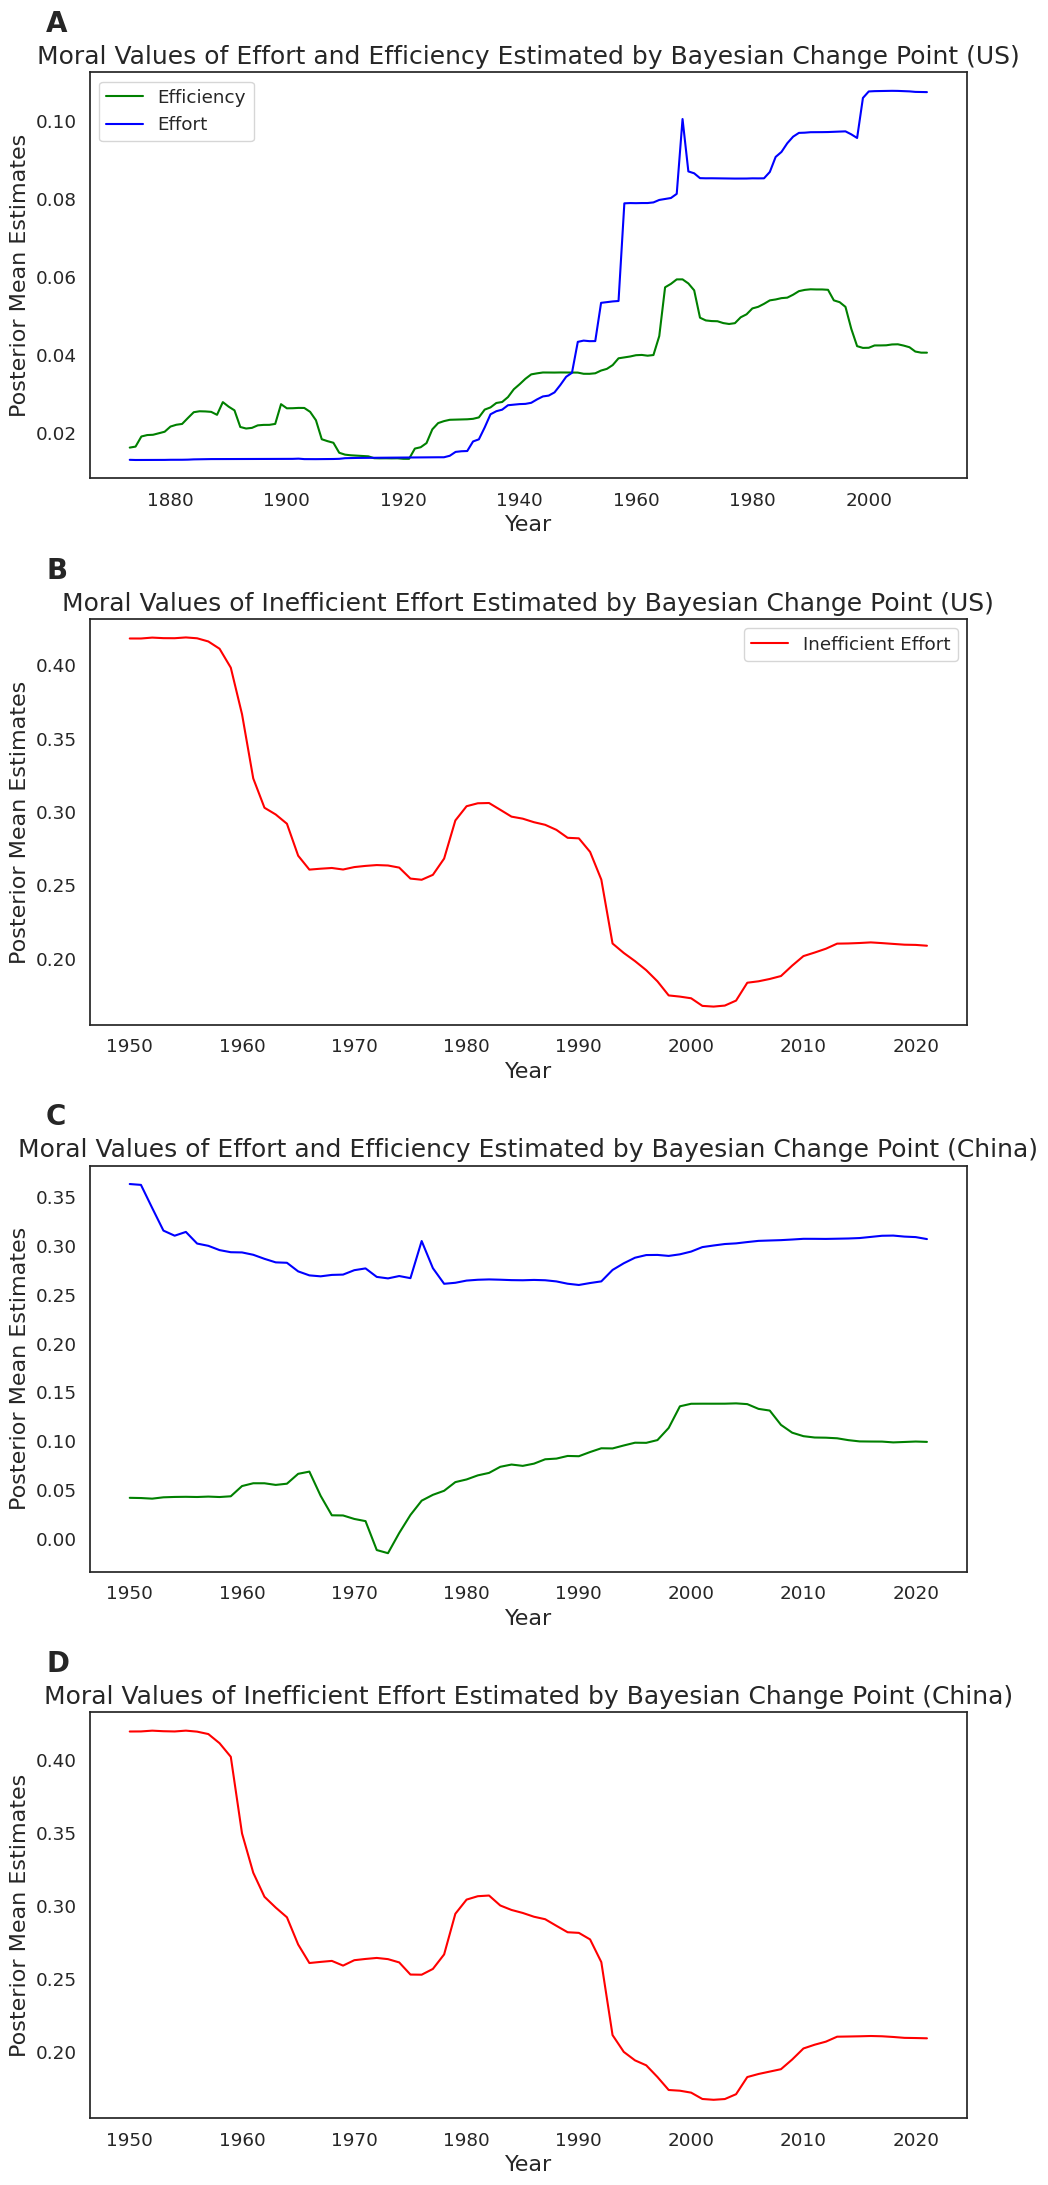

In [ ]:
import matplotlib.pyplot as plt

# Define where each set of data is plotted
subplot_label_positions = (-0.05, 1.1)  # Position for subplot labels

# Setup the plot
fig, axs = plt.subplots(4, 1, figsize=(10, 24))  # Change to 1 row and 4 columns

# Plot for US Effort and Efficiency
axs[0].plot(us_efficiency['Year'], us_efficiency['Means'], label='Efficiency', color='green')
axs[0].plot(us_effort['Year'], us_effort['Means'], label='Effort', color='blue')
axs[0].set_title('Moral Values of Effort and Efficiency Estimated by Bayesian Change Point (US)', fontsize=18)
axs[0].set_xlabel('Year', fontsize=16)
axs[0].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[0].legend()
axs[0].annotate('A', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

# Plot for US Inefficient Effort
axs[1].plot(us_effort_efficiency_virtue['Year'], us_effort_efficiency_virtue['Means'], color='red', label='Inefficient Effort')
axs[1].set_title('Moral Values of Inefficient Effort Estimated by Bayesian Change Point (US)', fontsize=18)
axs[1].set_xlabel('Year', fontsize=16)
axs[1].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[1].legend()
axs[1].annotate('B', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

# Plot for China Effort and Efficiency
axs[2].plot(chi_efficiency['Year'], chi_efficiency['Means'], label='Efficiency', color='green')
axs[2].plot(chi_effort['Year'], chi_effort['Means'], label='Effort', color='blue')
axs[2].set_title('Moral Values of Effort and Efficiency Estimated by Bayesian Change Point (China)', fontsize=18)
axs[2].set_xlabel('Year', fontsize=16)
axs[2].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[2].annotate('C', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

# Plot for China Inefficient Effort
axs[3].plot(chi_effort_efficiency_virtue['Year'], chi_effort_efficiency_virtue['Means'], color='red')
axs[3].set_title('Moral Values of Inefficient Effort Estimated by Bayesian Change Point (China)', fontsize=18)
axs[3].set_xlabel('Year', fontsize=16)
axs[3].set_ylabel('Posterior Mean Estimates', fontsize=16)
axs[3].annotate('D', xy=subplot_label_positions, xycoords='axes fraction', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
